In [3]:
import pandas as pd
from pathlib import Path

def merge_calendar_snapshots_simple_mean(base_path, city, output_filename=None):
    """
    Merge calendar data from different snapshots into one comprehensive dataset
    using only the mean price for each listing-date combination.
    
    Parameters:
    base_path (str): Path to the root directory containing city folders
    city (str): Name of the city to process (e.g., 'paris', 'amsterdam')
    output_filename (str, optional): Name for the output CSV file
    
    Returns:
    pd.DataFrame: Merged calendar data with mean prices
    """
    # Set default output filename if not provided
    if output_filename is None:
        output_filename = f"{city}_merged_calendar_mean.csv"
    
    # Get all date folders for the specified city
    city_path = Path(base_path) / city
    date_folders = sorted([d for d in city_path.iterdir() if d.is_dir()])
    
    print(f"Processing {len(date_folders)} snapshot folders for {city}...")
    
    # Initialize list to store DataFrames from each snapshot
    all_snapshots = []
    
    # Process each snapshot folder
    for i, date_folder in enumerate(date_folders, 1):
        calendar_file = date_folder / 'calendar.csv'
        if calendar_file.exists():
            print(f"Reading snapshot {i}/{len(date_folders)}: {date_folder.name}")
            
            # Read only the necessary columns to save memory
            df = pd.read_csv(calendar_file, 
                             usecols=['listing_id', 'date', 'price', 'available'],
                             dtype={'listing_id': int, 'date': str, 'price': str, 'available': str},
                             low_memory=False)
            
            # Convert date to datetime
            df['date'] = pd.to_datetime(df['date'])
            
            # Clean price column - remove $ and commas, convert to float
            df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(float)
            
            # Append to list of snapshots
            all_snapshots.append(df)
            
            print(f"  Loaded {len(df):,} rows")
    
    # Concatenate all snapshots into a single DataFrame
    print("\nCombining all snapshots...")
    combined_df = pd.concat(all_snapshots, ignore_index=True)
    print(f"Combined dataset: {len(combined_df):,} rows")
    
    # Calculate mean prices for each listing-date combination
    print("Calculating mean prices...")
    
    # Group by listing_id and date, calculate mean price and handle availability
    merged_df = combined_df.groupby(['listing_id', 'date']).agg({
        'price': 'mean',
        'available': lambda x: 't' if 't' in x.values else 'f'  # Use 'available' if any snapshot says available
    }).reset_index()
    
    # Sort by listing_id and date
    merged_df = merged_df.sort_values(['listing_id', 'date'])
    
    # Save to CSV
    print(f"Saving merged calendar to {output_filename}...")
    merged_df.to_csv(output_filename, index=False)
    
    # Print summary statistics
    print("\nMerged Calendar Summary:")
    print(f"Total rows: {len(merged_df):,}")
    print(f"Unique listings: {merged_df['listing_id'].nunique():,}")
    print(f"Date range: {merged_df['date'].min()} to {merged_df['date'].max()}")
    
    # Show sample of the merged data
    print("\nSample of merged data:")
    print(merged_df.head(10).to_string())
    
    return merged_df

# Example usage:
base_folder = 'C:/Users/mvk/Documents/DATA_school/thesis/data_new'
city = "paris"
merged_calendar = merge_calendar_snapshots_simple_mean(base_folder, city)

Processing 6 snapshot folders for paris...
Reading snapshot 1/6: 2023-06-06
  Loaded 22,521,650 rows
Reading snapshot 2/6: 2023-09-04
  Loaded 24,798,862 rows
Reading snapshot 3/6: 2023-12-12
  Loaded 27,134,477 rows
Reading snapshot 4/6: 2024-03-16
  Loaded 30,804,889 rows
Reading snapshot 5/6: 2024-06-10
  Loaded 34,997,121 rows
Reading snapshot 6/6: 2024-09-06
  Loaded 34,842,829 rows

Combining all snapshots...
Combined dataset: 175,099,828 rows
Calculating mean prices...
Saving merged calendar to paris_merged_calendar_mean.csv...

Merged Calendar Summary:
Total rows: 79,418,789
Unique listings: 128,063
Date range: 2023-06-07 00:00:00 to 2025-09-12 00:00:00

Sample of merged data:
   listing_id       date  price available
0        3109 2023-09-05  110.0         f
1        3109 2023-09-06  110.0         f
2        3109 2023-09-07  110.0         f
3        3109 2023-09-08  110.0         t
4        3109 2023-09-09  110.0         t
5        3109 2023-09-10  110.0         t
6        310

Processing 6 folders for paris...
Sampled 20 listings for analysis
Reading data from 2023-06-06
Reading data from 2023-09-04
Reading data from 2023-12-12
Reading data from 2024-03-16
Reading data from 2024-06-10
Reading data from 2024-09-06
Processing listing 1/20: ID 963722328741162466


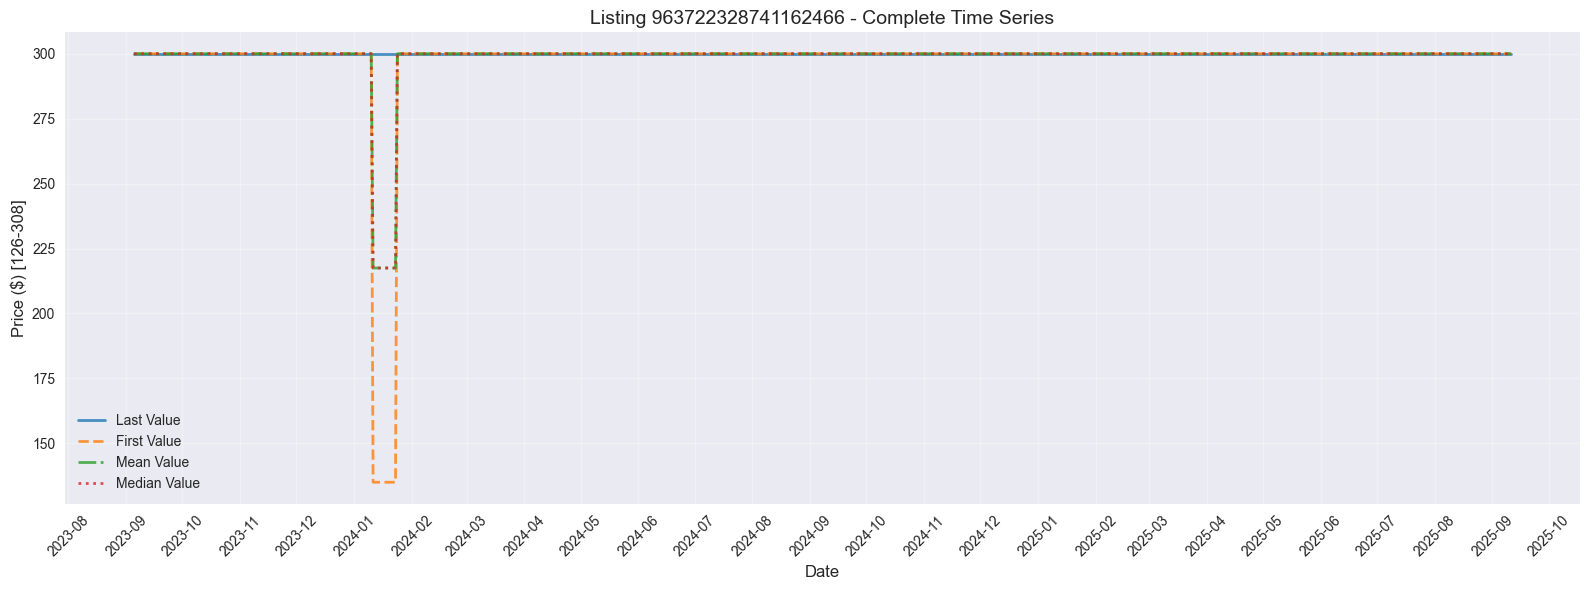

Processing listing 2/20: ID 13089618


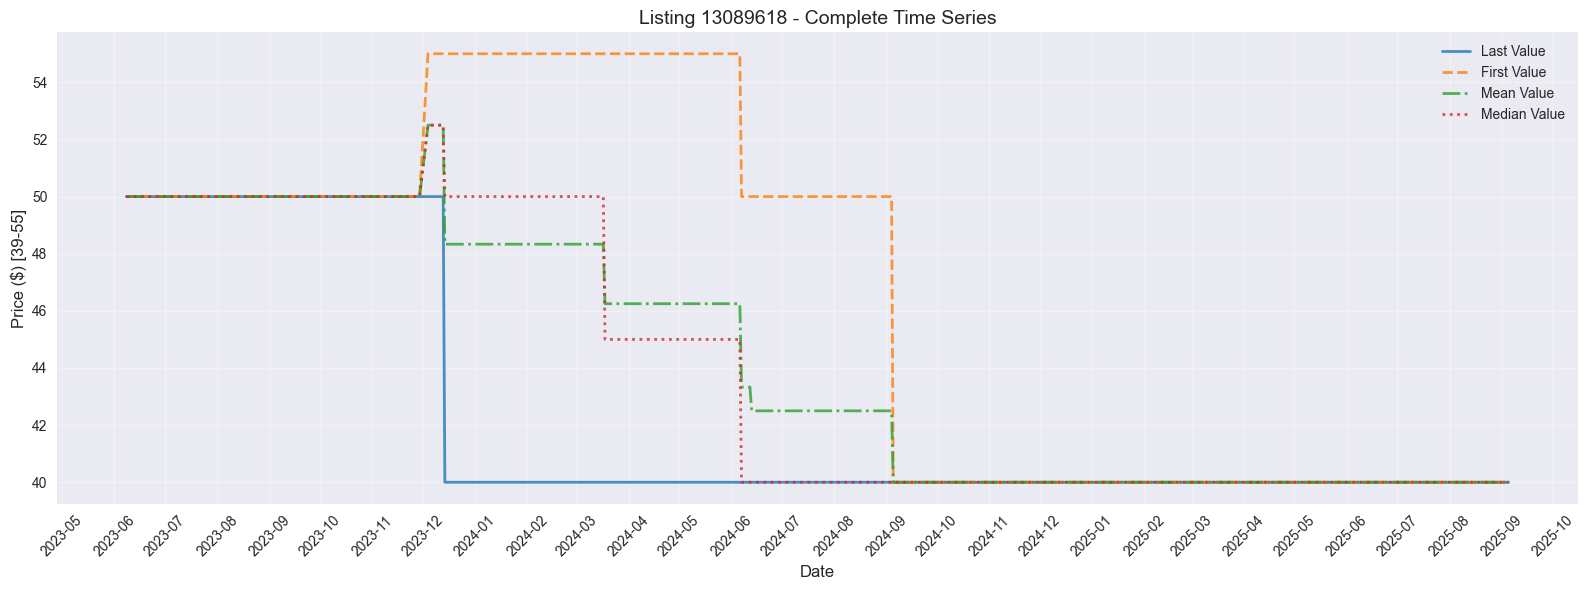

Processing listing 3/20: ID 1196393134718980158


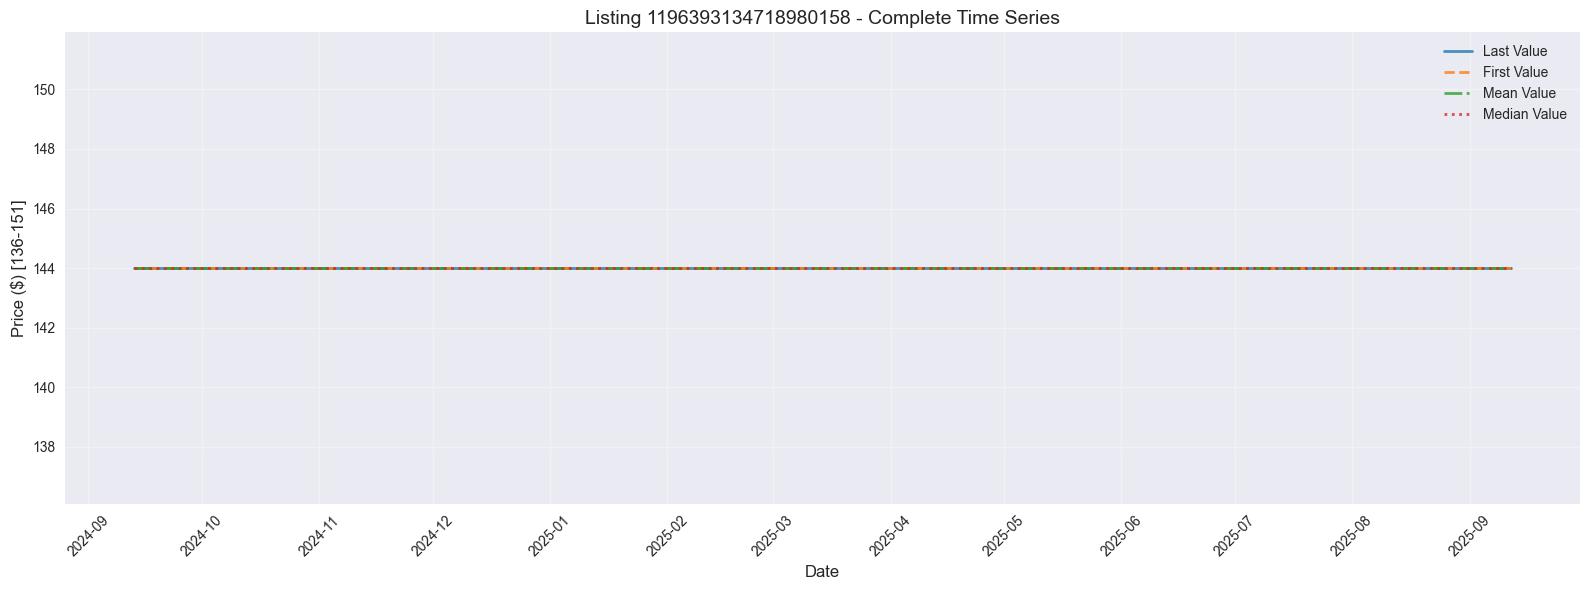

Processing listing 4/20: ID 31611383


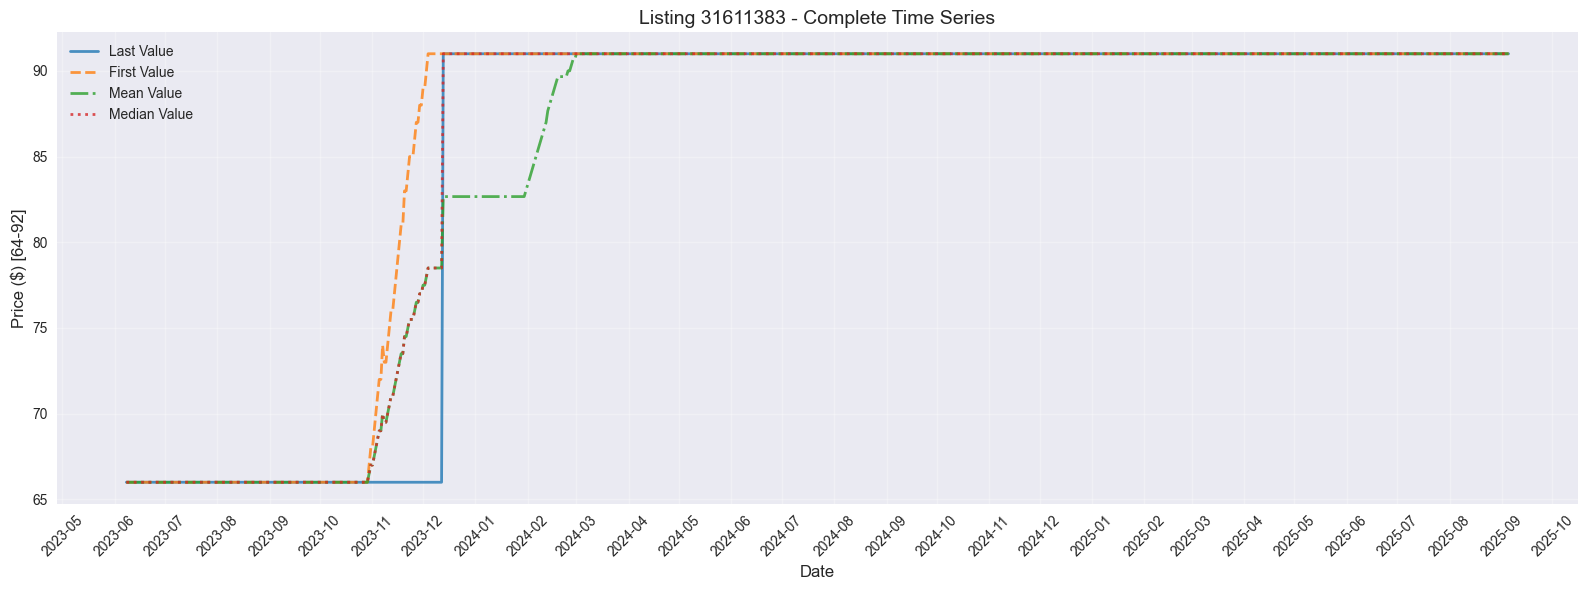

Processing listing 5/20: ID 1158033190621281565


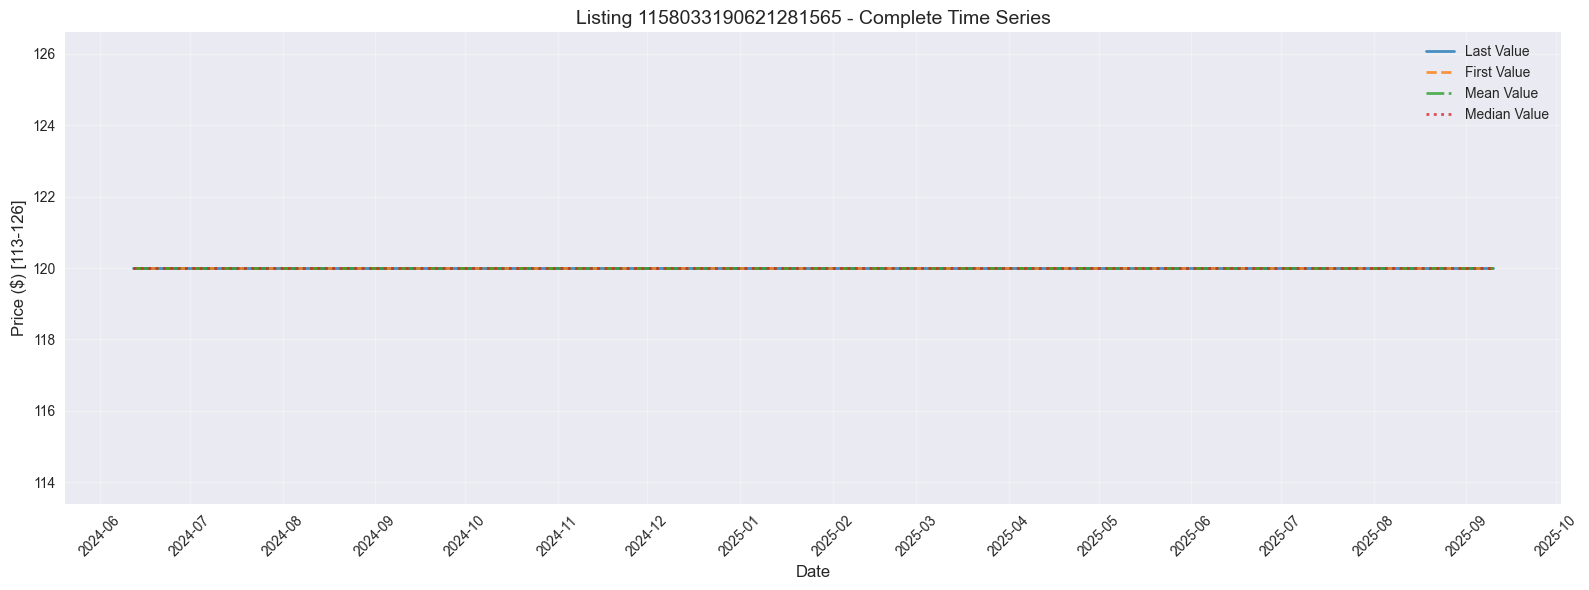

Processing listing 6/20: ID 51627418


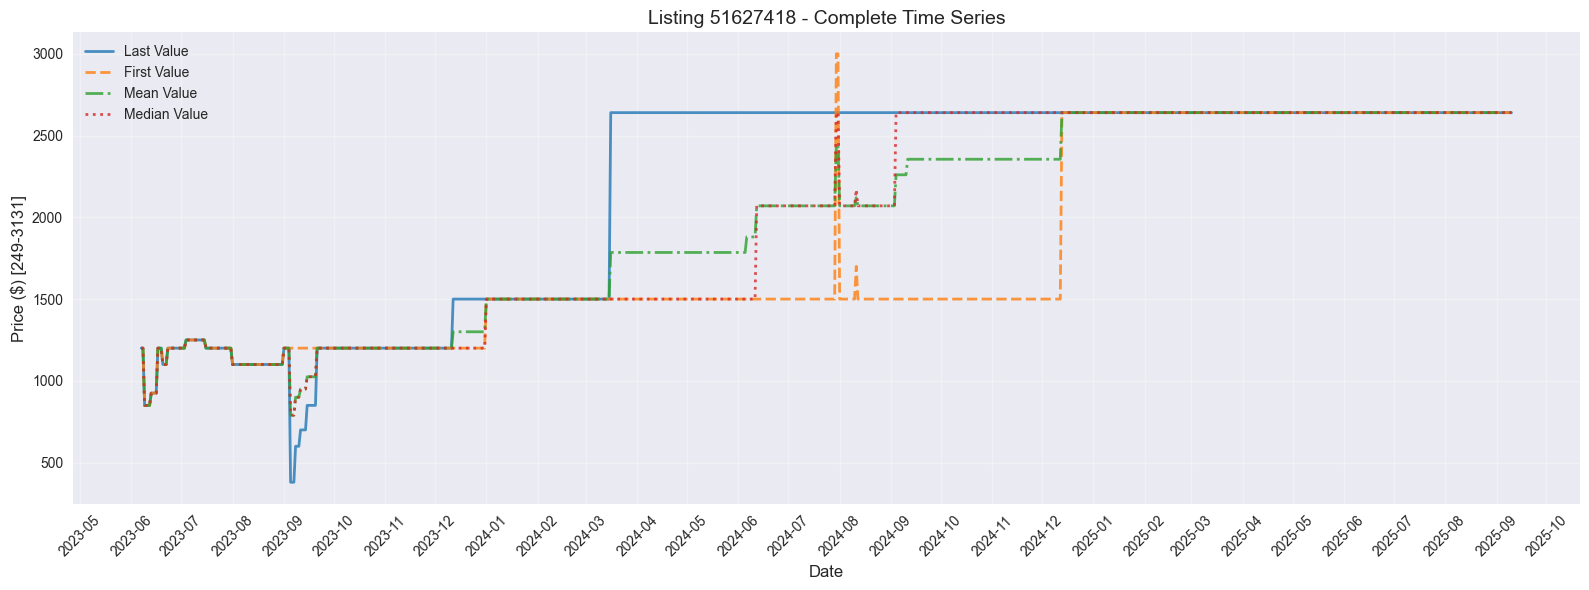

Processing listing 7/20: ID 710657031768153103


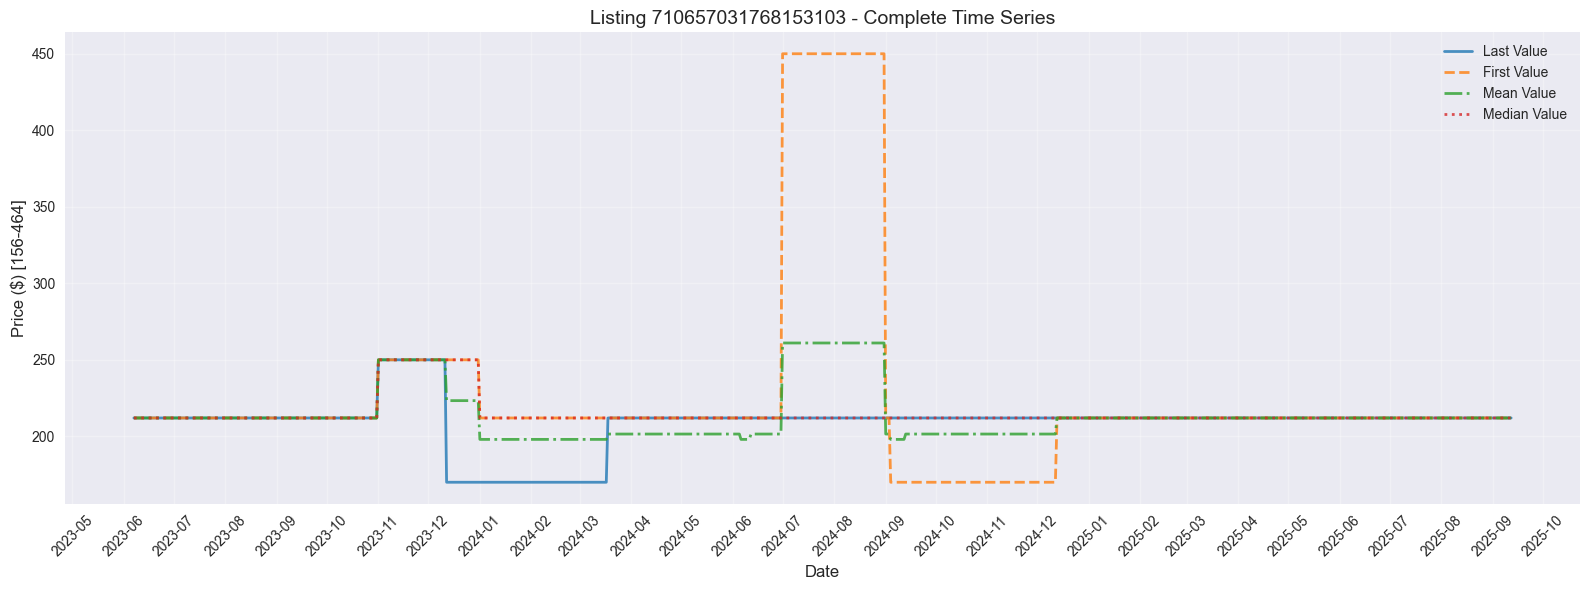

Processing listing 8/20: ID 915295603757492336


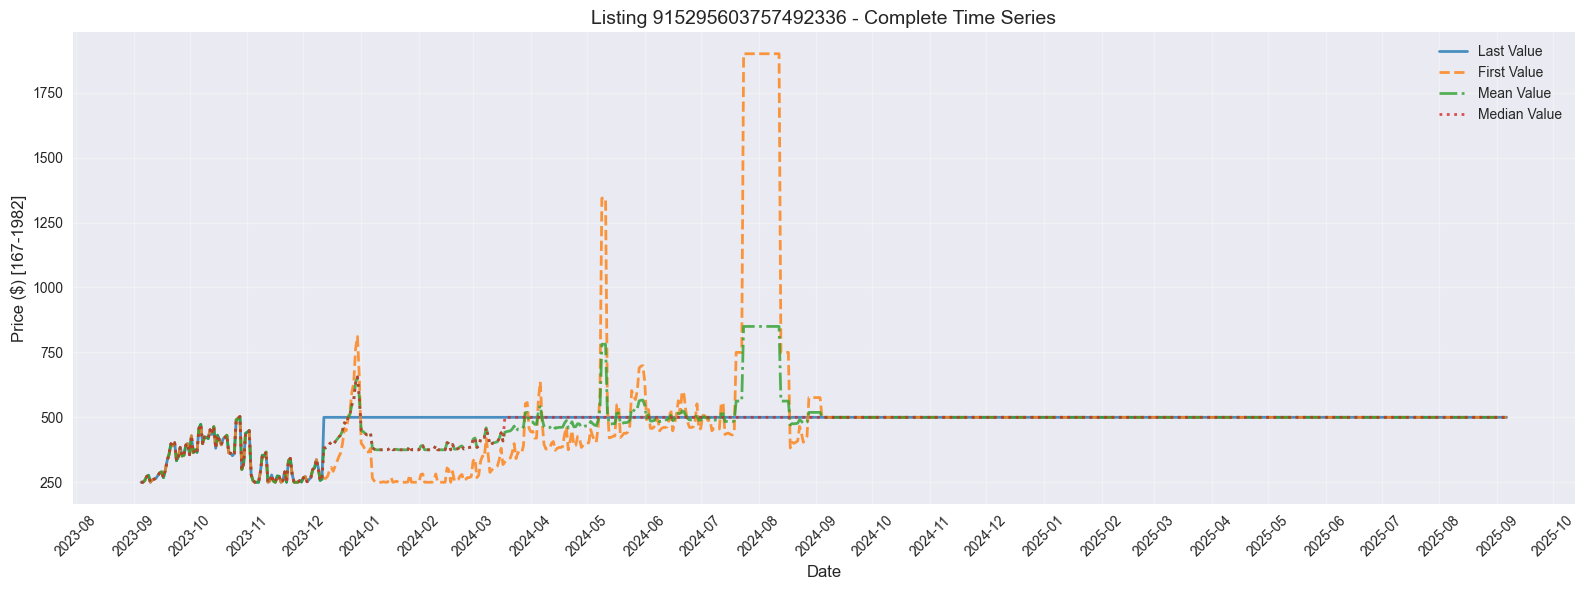

Processing listing 9/20: ID 45872673


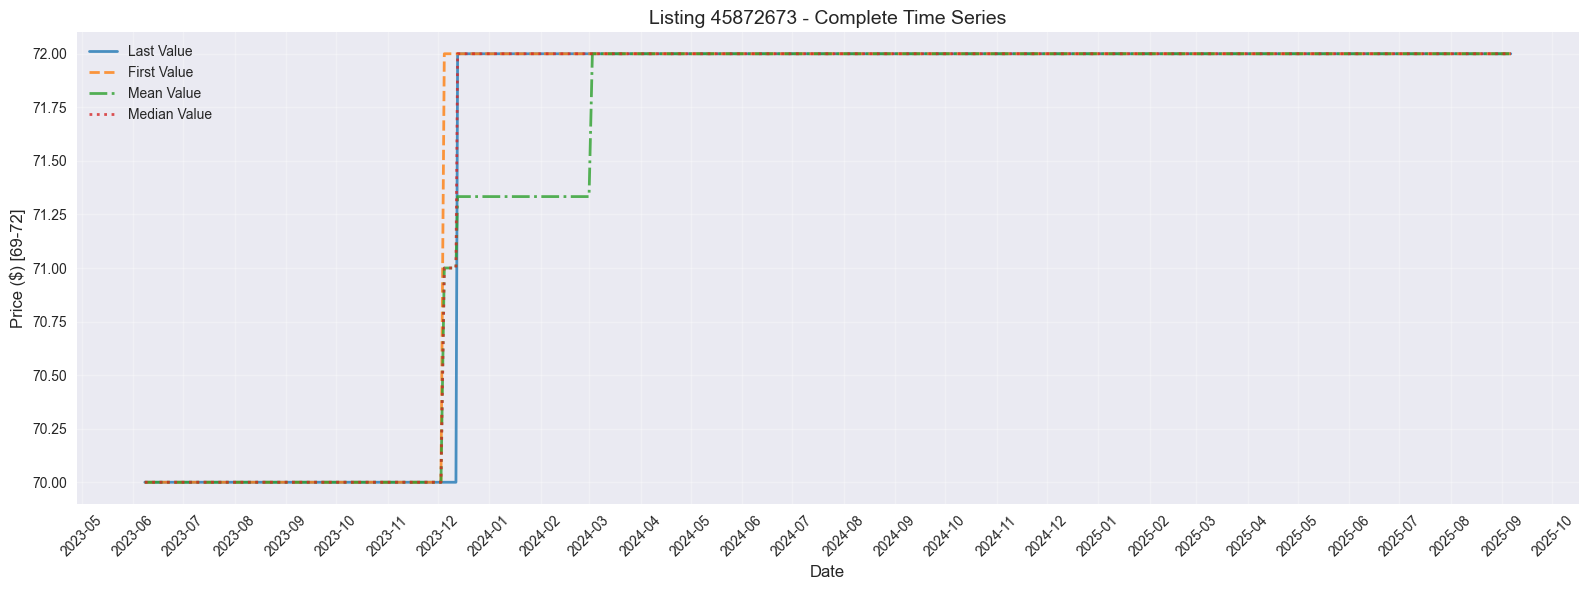

Processing listing 10/20: ID 2018724


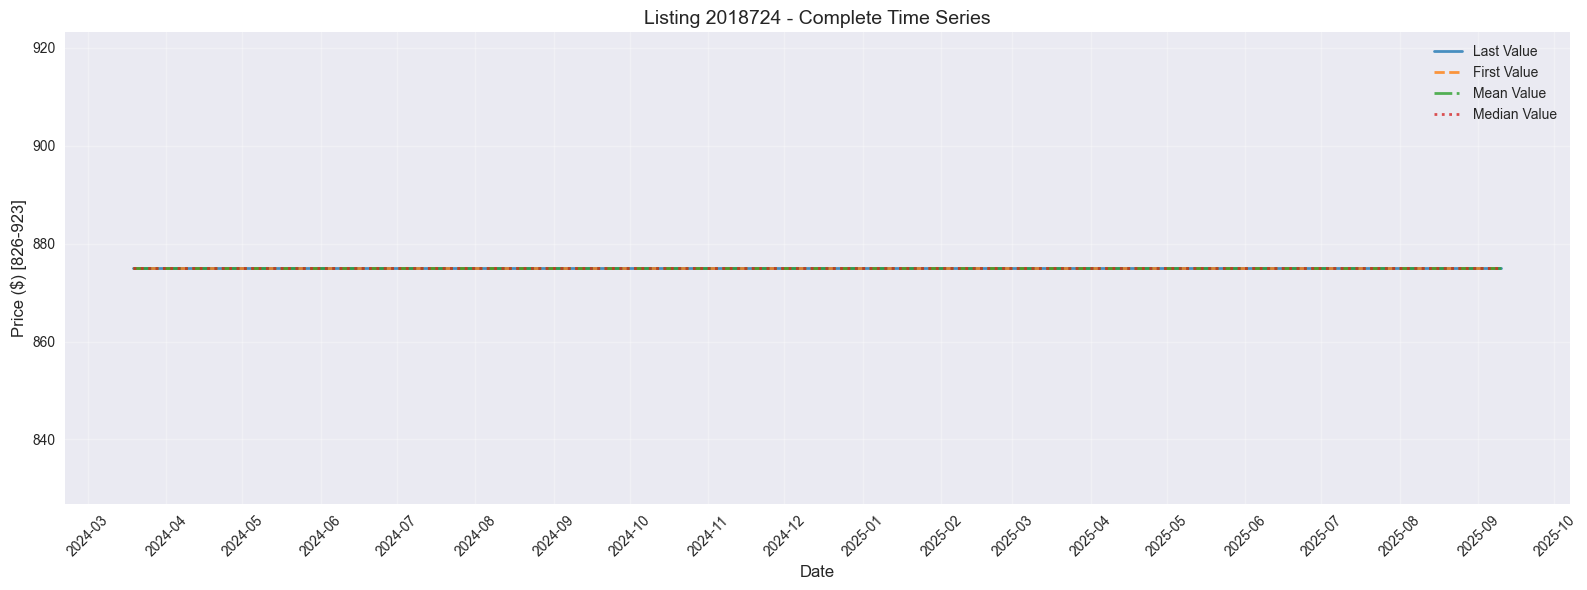

Processing listing 11/20: ID 28995839


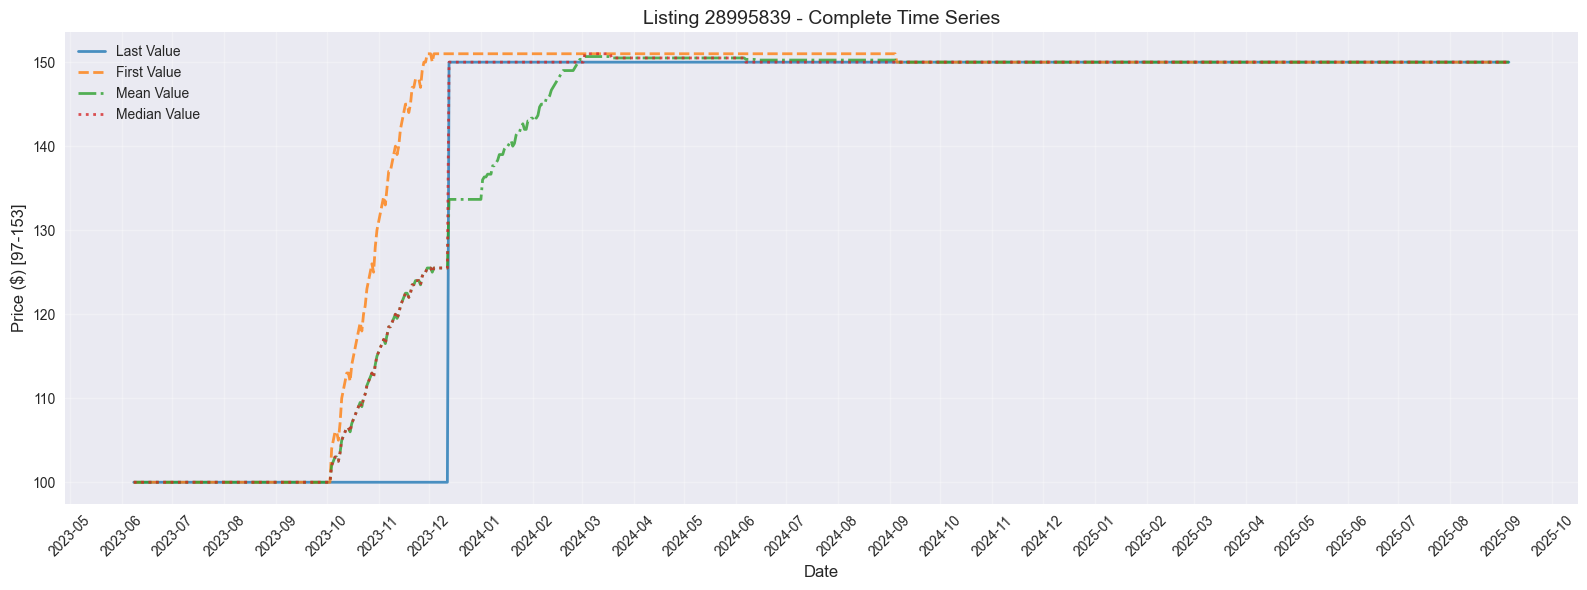

Processing listing 12/20: ID 19955987


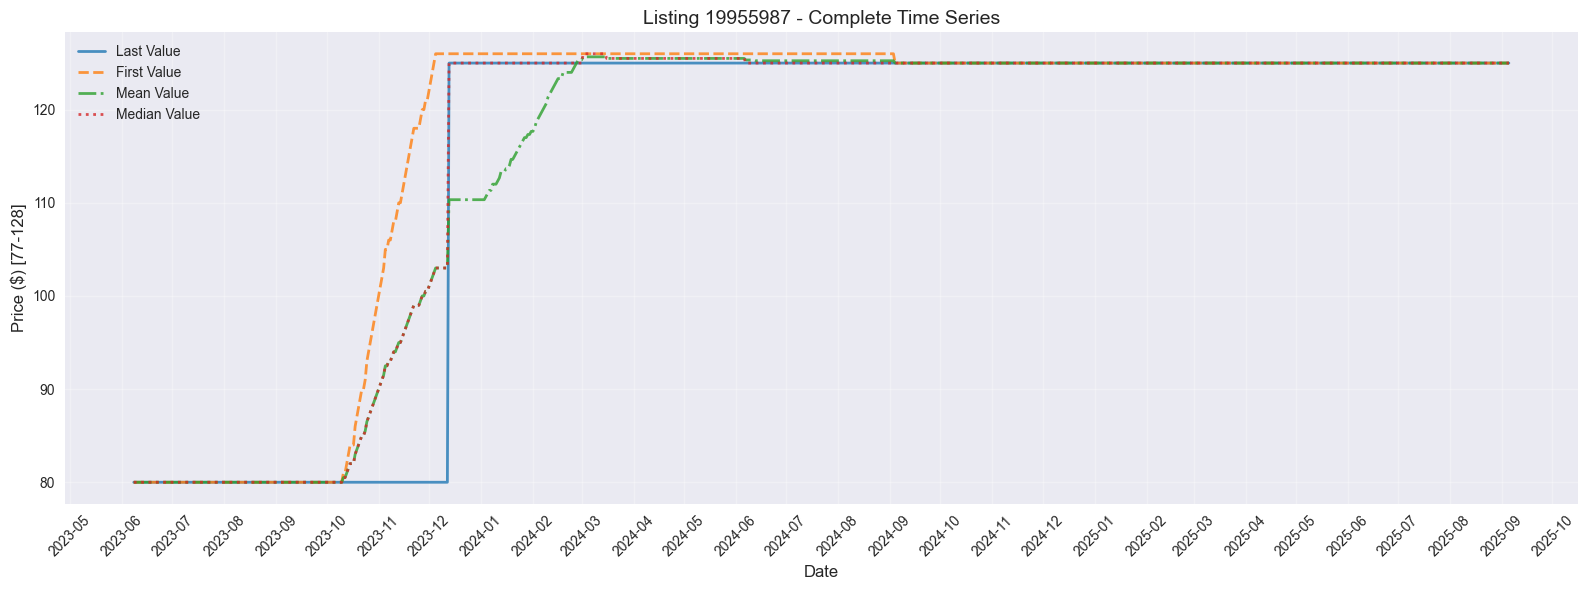

Processing listing 13/20: ID 1039067948234576204


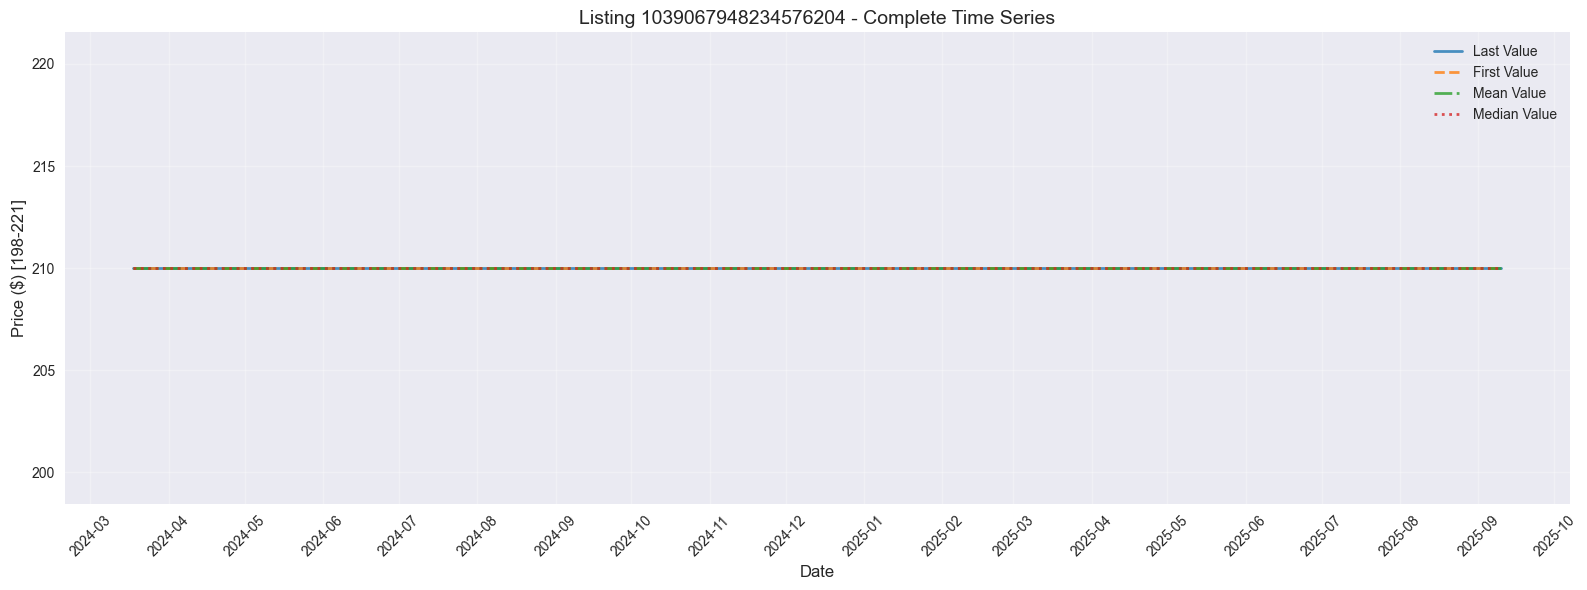

Processing listing 14/20: ID 879623872449678928


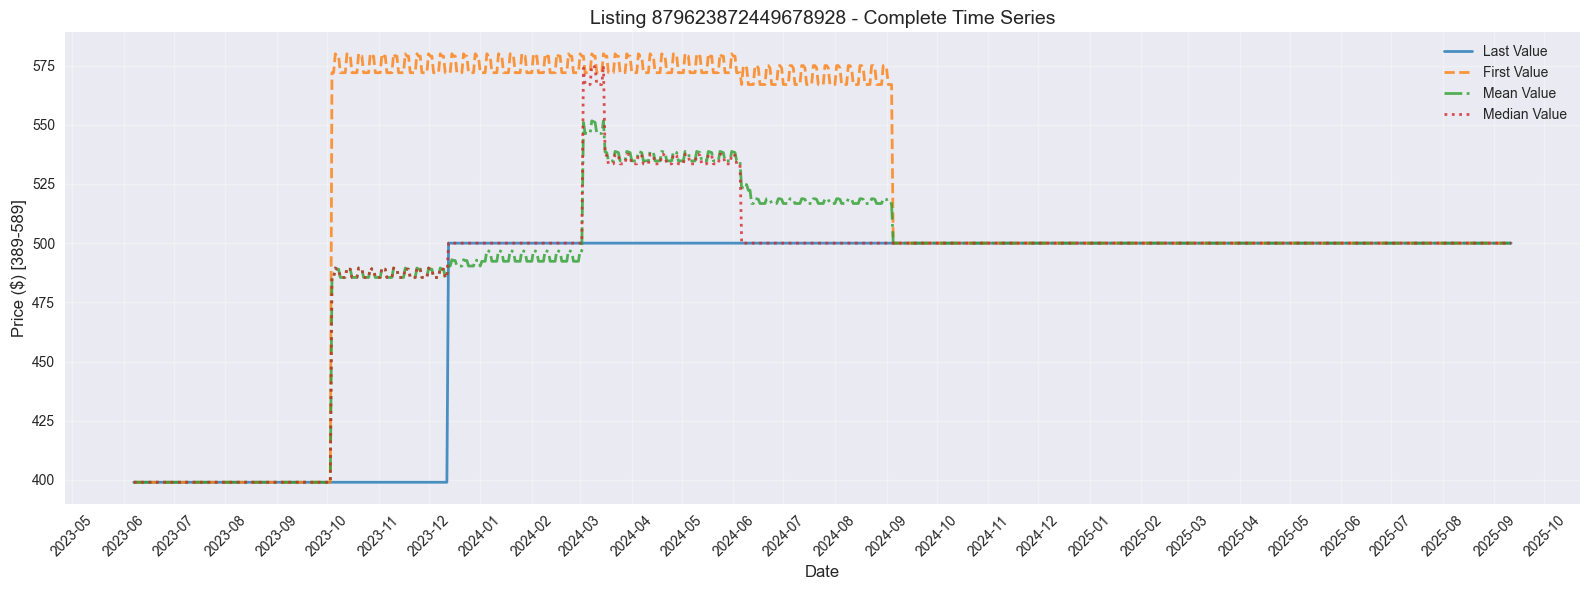

Processing listing 15/20: ID 1123309217751553233


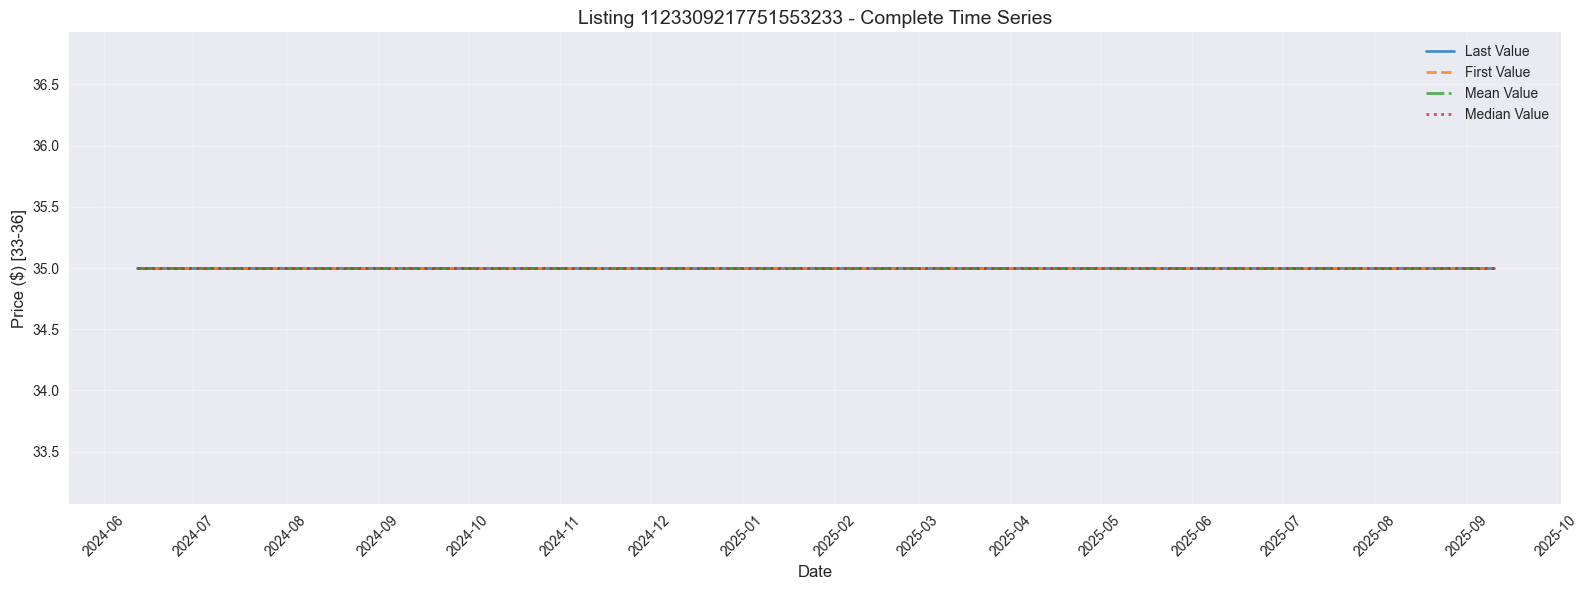

Processing listing 16/20: ID 1009118964193816022


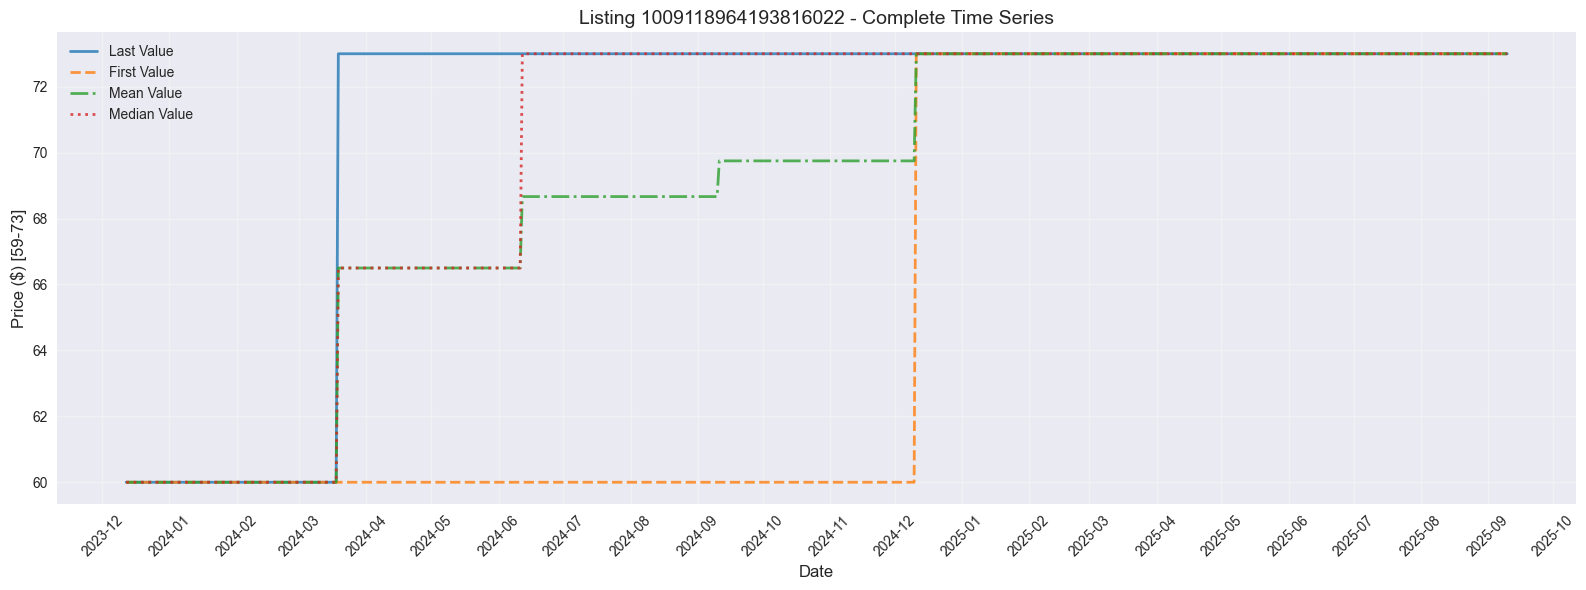

Processing listing 17/20: ID 1187510081549410845


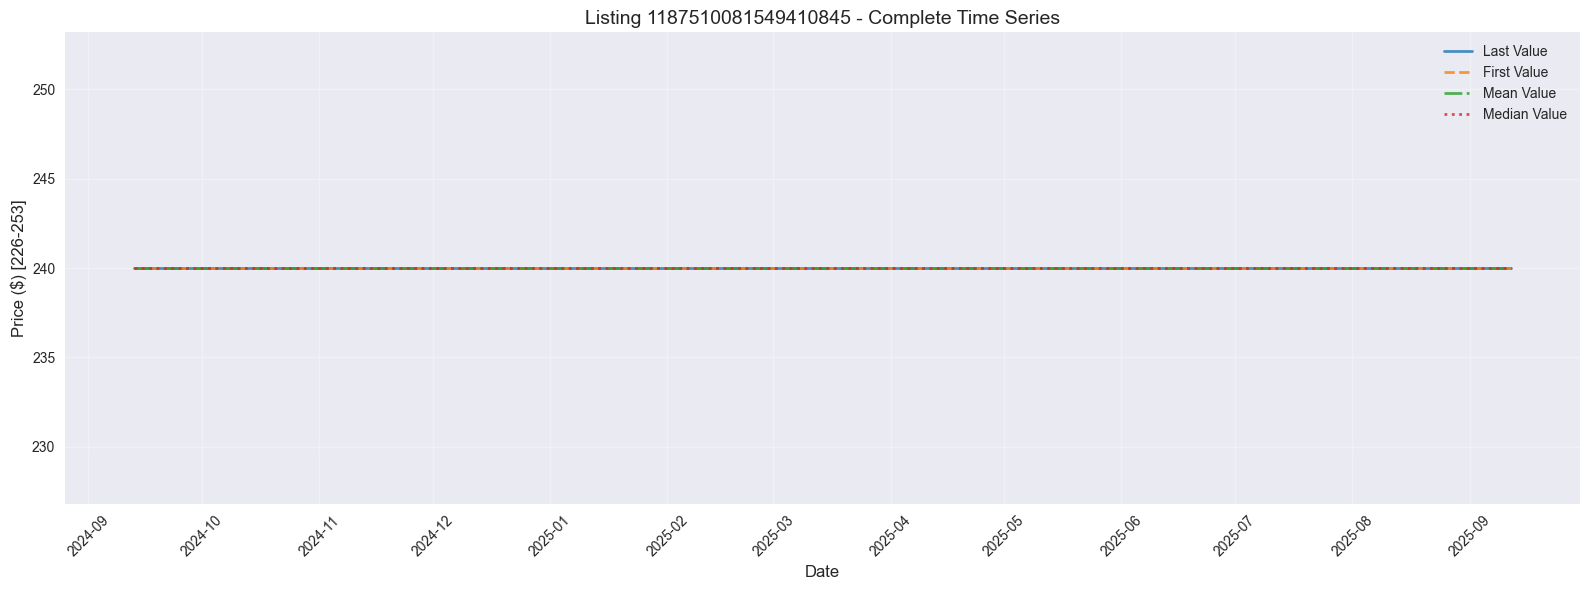

Processing listing 18/20: ID 24056143


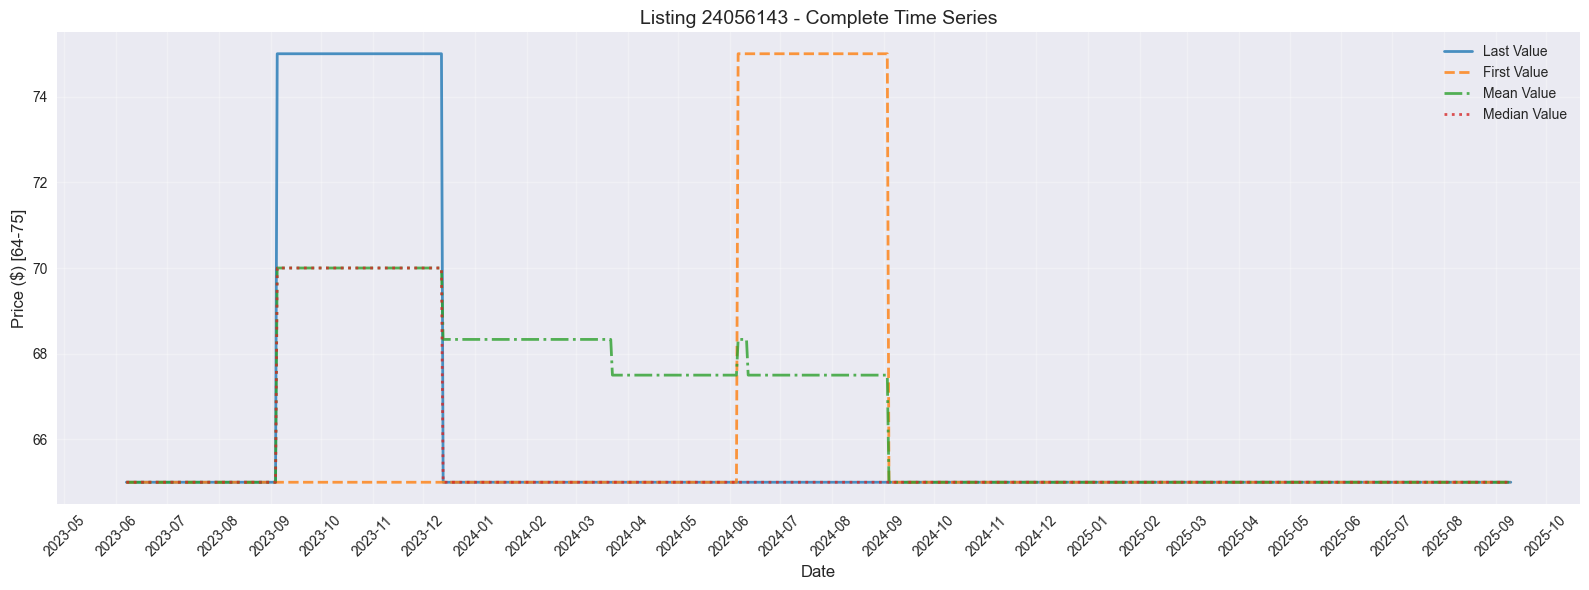

Processing listing 19/20: ID 28133054


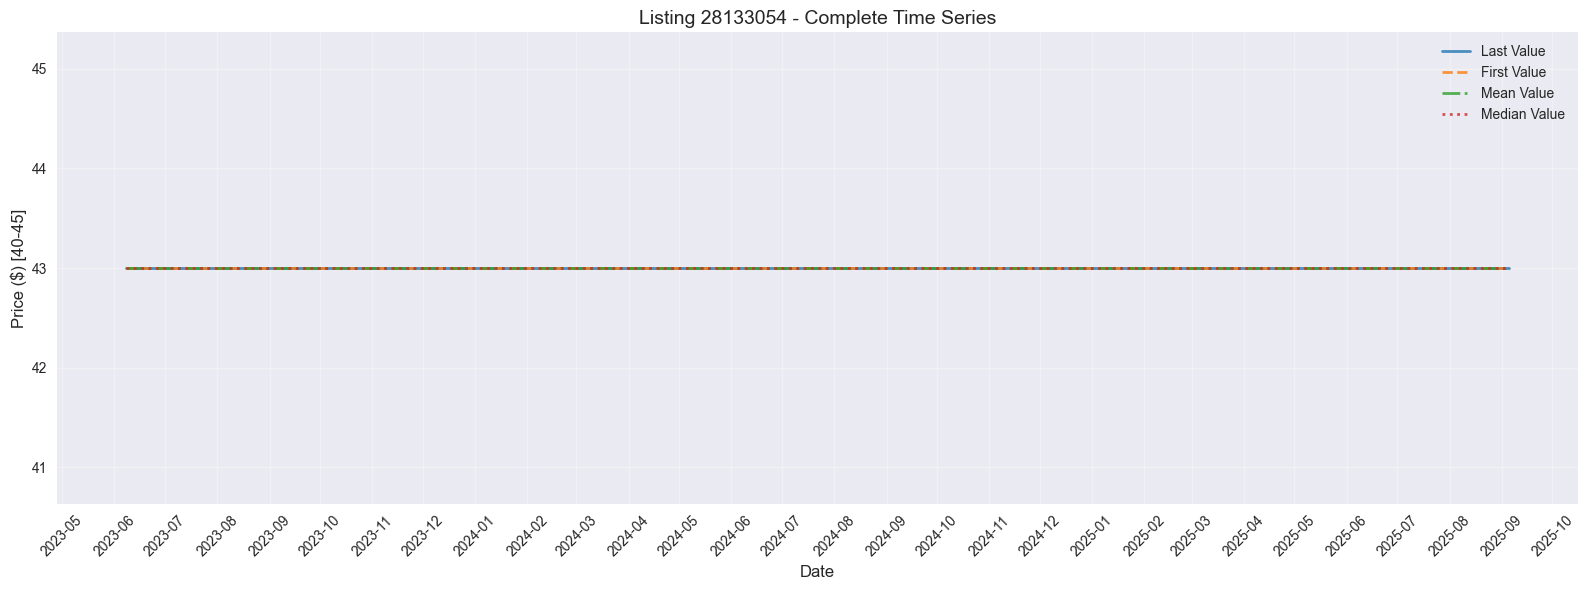

Processing listing 20/20: ID 1046953206709746429


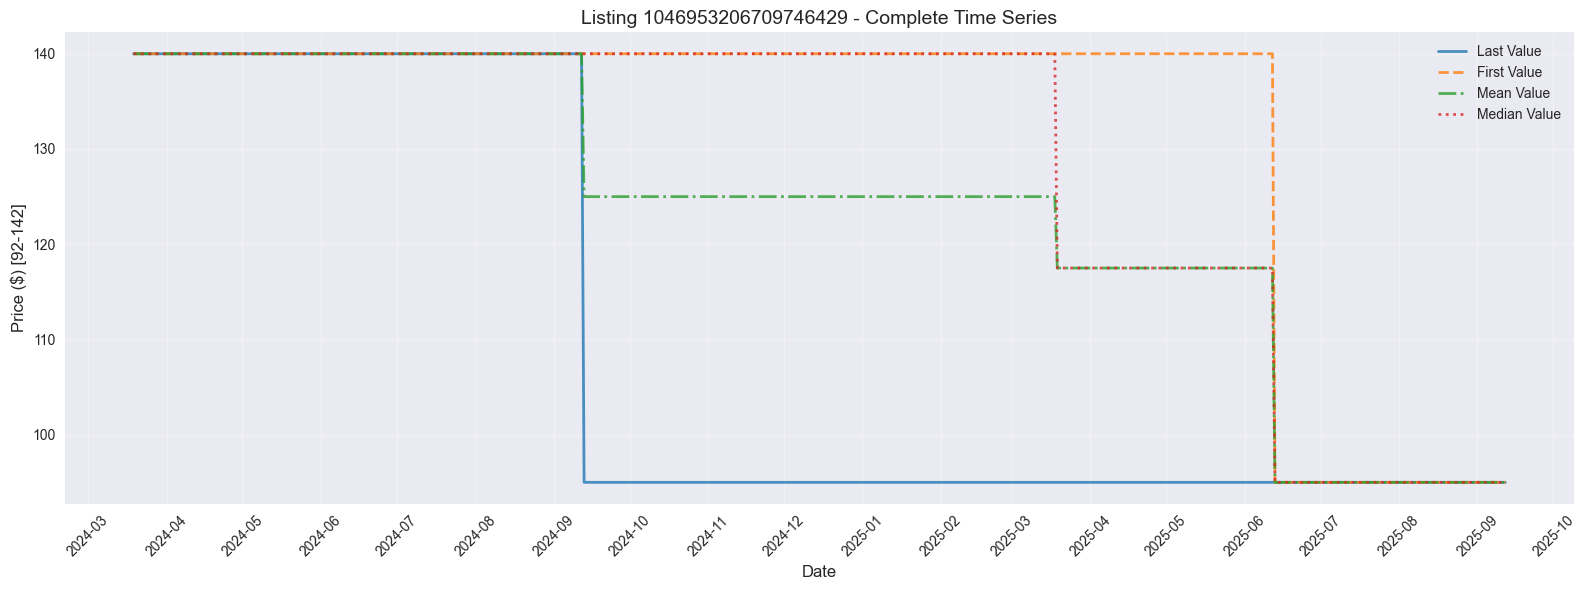


Visualization Complete!
Generated 20 time series plots in the 'listing_timeseries' folder

Legend explanation:
- Solid line (blue): Last Value - price from most recent snapshot
- Dashed line (orange): First Value - price from earliest snapshot
- Dash-dot line (green): Mean Value - average price across all snapshots
- Dotted line (red): Median Value - median price across all snapshots


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

def load_and_visualize_listings(base_path, city, num_listings=20):
    """
    Load data for a specified number of listings and visualize their complete time series 
    with different merging methods.
    
    Parameters:
    base_path (str): Path to the root directory
    city (str): Name of the city to process
    num_listings (int): Number of listings to sample
    """
    # Get all date folders for the specified city
    city_path = Path(base_path) / city
    date_folders = sorted([d for d in city_path.iterdir() if d.is_dir()])
    
    print(f"Processing {len(date_folders)} folders for {city}...")
    
    # First get a list of all listing IDs that appear in the most recent snapshot
    latest_folder = date_folders[-1]
    latest_calendar = pd.read_csv(latest_folder / 'calendar.csv', low_memory=False)
    
    # Sample random listing_ids
    sample_listings = latest_calendar['listing_id'].sample(num_listings, random_state=42).tolist()
    print(f"Sampled {num_listings} listings for analysis")
    
    # Initialize DataFrame to store all data for sampled listings
    all_data = pd.DataFrame()
    
    # Process each date folder
    for date_folder in date_folders:
        source_date = pd.to_datetime(date_folder.name)
        print(f"Reading data from {date_folder.name}")
        
        calendar_file = date_folder / 'calendar.csv'
        if calendar_file.exists():
            # Read only the columns we need and only for the sampled listings
            df = pd.read_csv(calendar_file, low_memory=False, 
                            usecols=['listing_id', 'date', 'price'],
                            dtype={'listing_id': int, 'date': str, 'price': str})
            
            # Filter for sampled listings
            sample_data = df[df['listing_id'].isin(sample_listings)].copy()
            
            if not sample_data.empty:
                # Convert date column to datetime
                sample_data['date'] = pd.to_datetime(sample_data['date'])
                
                # Clean price column
                sample_data['price'] = sample_data['price'].str.replace('$', '').str.replace(',', '').astype(float)
                
                # Add source date
                sample_data['source_date'] = source_date
                
                # Append to all_data
                all_data = pd.concat([all_data, sample_data])
    
    # Create output directory
    output_dir = Path("listing_timeseries")
    output_dir.mkdir(exist_ok=True)
    
    # Set plot style
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")
    
    # Visualize each listing
    for i, listing_id in enumerate(sample_listings, 1):
        print(f"Processing listing {i}/{num_listings}: ID {listing_id}")
        
        # Filter for this listing
        listing_df = all_data[all_data['listing_id'] == listing_id].copy()
        
        if listing_df.empty:
            print(f"No data found for listing {listing_id}")
            continue
        
        # Prepare different merging strategies
        # 1. Last value approach (most recent snapshot)
        last_values = listing_df.sort_values(['date', 'source_date']).drop_duplicates(subset=['date'], keep='last')
        
        # 2. First value approach (earliest snapshot)
        first_values = listing_df.sort_values(['date', 'source_date']).drop_duplicates(subset=['date'], keep='first')
        
        # 3. Mean price approach
        mean_values = listing_df.groupby('date')['price'].mean().reset_index()
        
        # 4. Median price approach
        median_values = listing_df.groupby('date')['price'].median().reset_index()
        
        # Create dataframe with all dates in range for complete visualization
        min_date = listing_df['date'].min()
        max_date = listing_df['date'].max()
        
        # Create a complete date range
        date_range = pd.date_range(start=min_date, end=max_date, freq='D')
        complete_df = pd.DataFrame({'date': date_range})
        
        # Add each strategy
        complete_df = pd.merge(complete_df, 
                              last_values[['date', 'price']].rename(columns={'price': 'Last Value'}),
                              on='date', how='left')
        
        complete_df = pd.merge(complete_df, 
                              first_values[['date', 'price']].rename(columns={'price': 'First Value'}),
                              on='date', how='left')
        
        complete_df = pd.merge(complete_df, 
                              mean_values.rename(columns={'price': 'Mean Value'}),
                              on='date', how='left')
        
        complete_df = pd.merge(complete_df, 
                              median_values.rename(columns={'price': 'Median Value'}),
                              on='date', how='left')
        
        # Create complete time series plot
        plt.figure(figsize=(16, 6))
        
        # Plot each strategy
        strategies = ['Last Value', 'First Value', 'Mean Value', 'Median Value']
        lines = ['-', '--', '-.', ':']
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        
        for strategy, line, color in zip(strategies, lines, colors):
            plt.plot(complete_df['date'], complete_df[strategy], 
                    linestyle=line, label=strategy, color=color, alpha=0.8, linewidth=2)
        
        # Format the plot
        plt.title(f'Listing {listing_id} - Complete Time Series', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Price ($)', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        
        # Format x-axis with month intervals
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.xticks(rotation=45)
        
        # Add price range to ylabel for context
        ymin, ymax = plt.ylim()
        plt.ylabel(f'Price ($) [{int(ymin)}-{int(ymax)}]', fontsize=12)
        
        plt.tight_layout()
        plt.savefig(output_dir / f"listing_{listing_id}_timeseries.png", dpi=300)
        plt.show()
        plt.close()
    
    # Print summary to guide interpretation
    print("\nVisualization Complete!")
    print(f"Generated {num_listings} time series plots in the 'listing_timeseries' folder")
    print("\nLegend explanation:")
    print("- Solid line (blue): Last Value - price from most recent snapshot")
    print("- Dashed line (orange): First Value - price from earliest snapshot")
    print("- Dash-dot line (green): Mean Value - average price across all snapshots")
    print("- Dotted line (red): Median Value - median price across all snapshots")
    
    return all_data, sample_listings

# Example usage:
base_folder = 'C:/Users/mvk/Documents/DATA_school/thesis/data_new'
city = "paris"
all_data, sample_listings = load_and_visualize_listings(base_folder, city)

Processing 6 folders for paris...
Sampled 20 listings for analysis
Reading data from 2023-06-06
Reading data from 2023-09-04
Reading data from 2023-12-12
Reading data from 2024-03-16
Reading data from 2024-06-10
Reading data from 2024-09-06
Processing listing 1/20: ID 963722328741162466


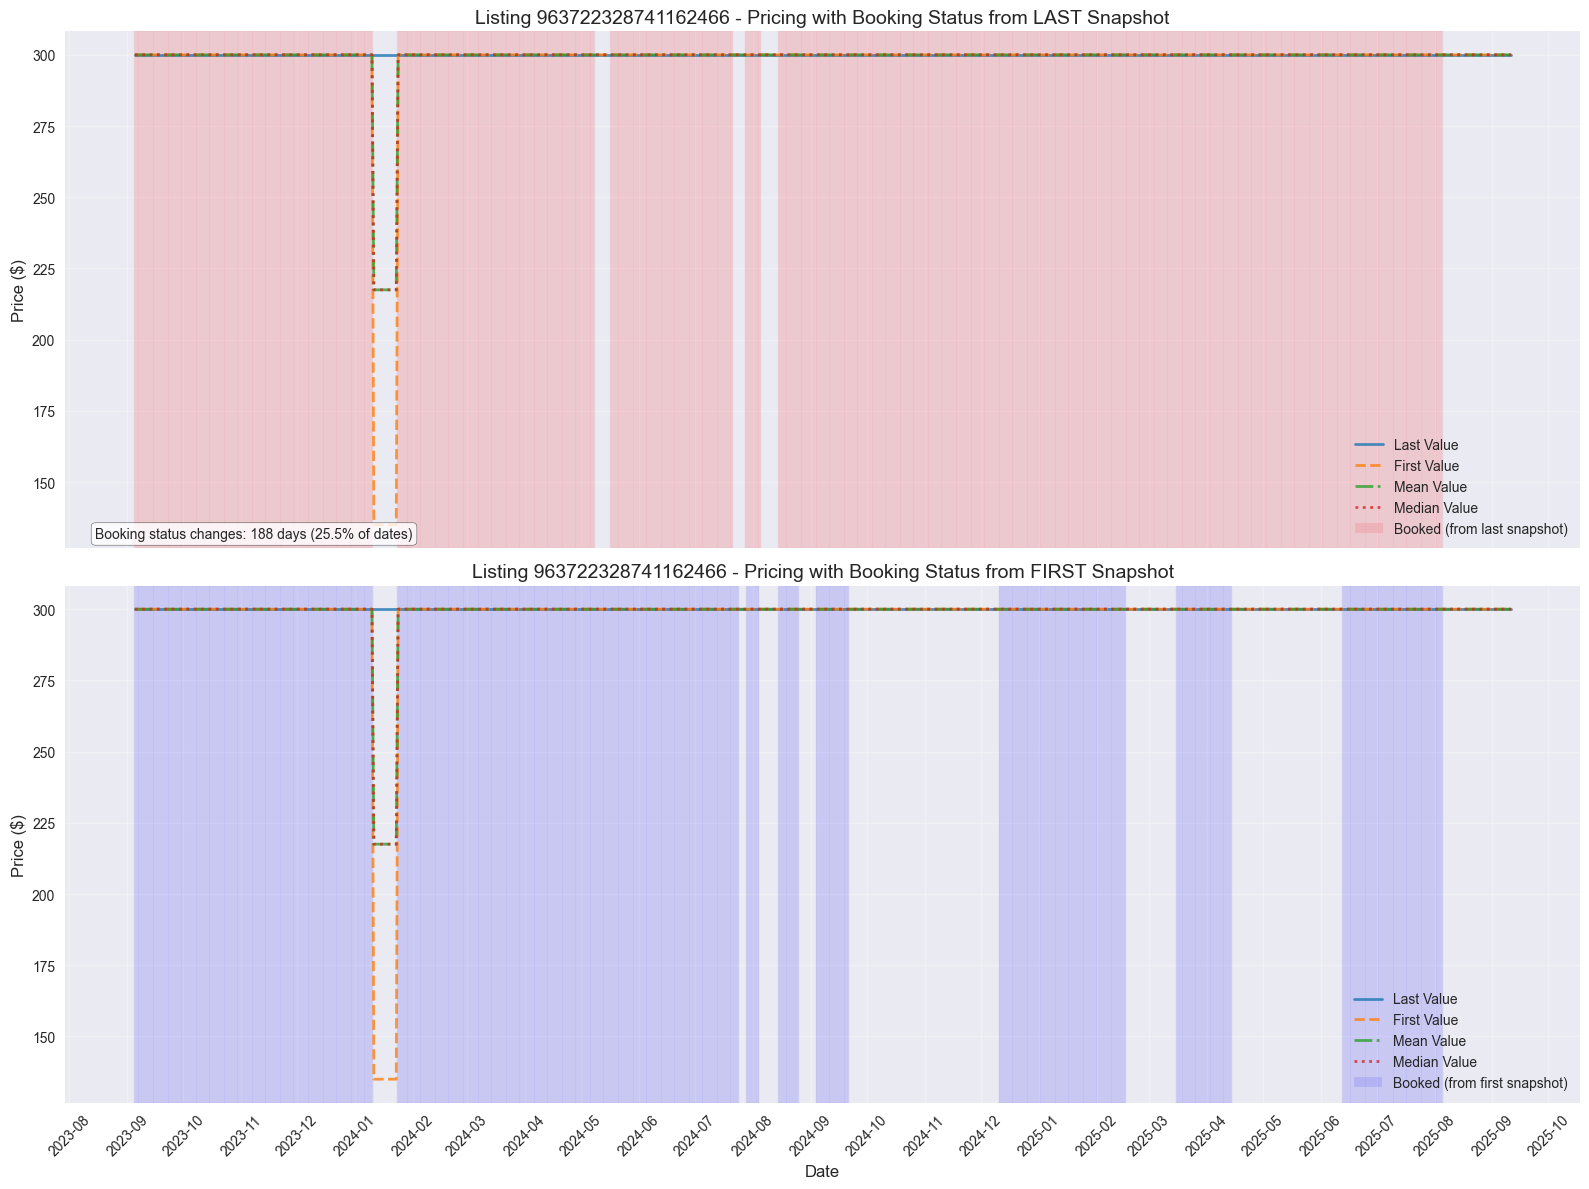

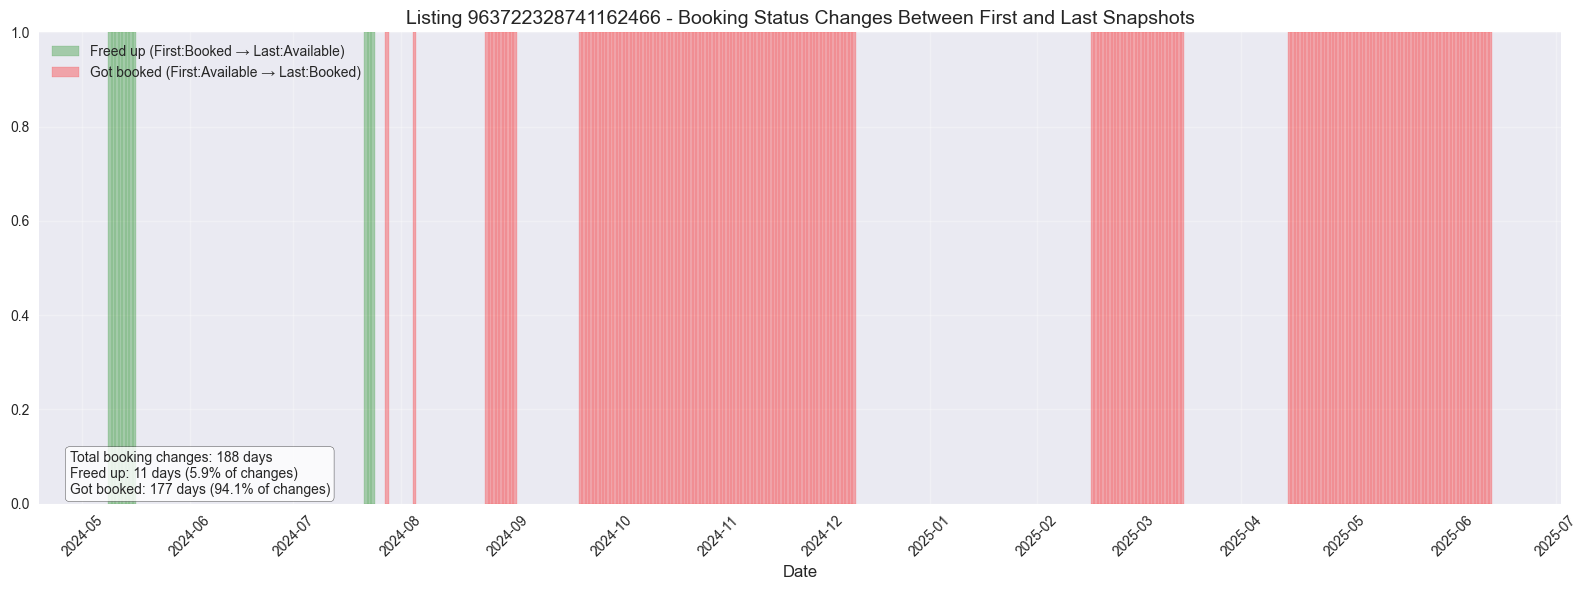

Processing listing 2/20: ID 13089618


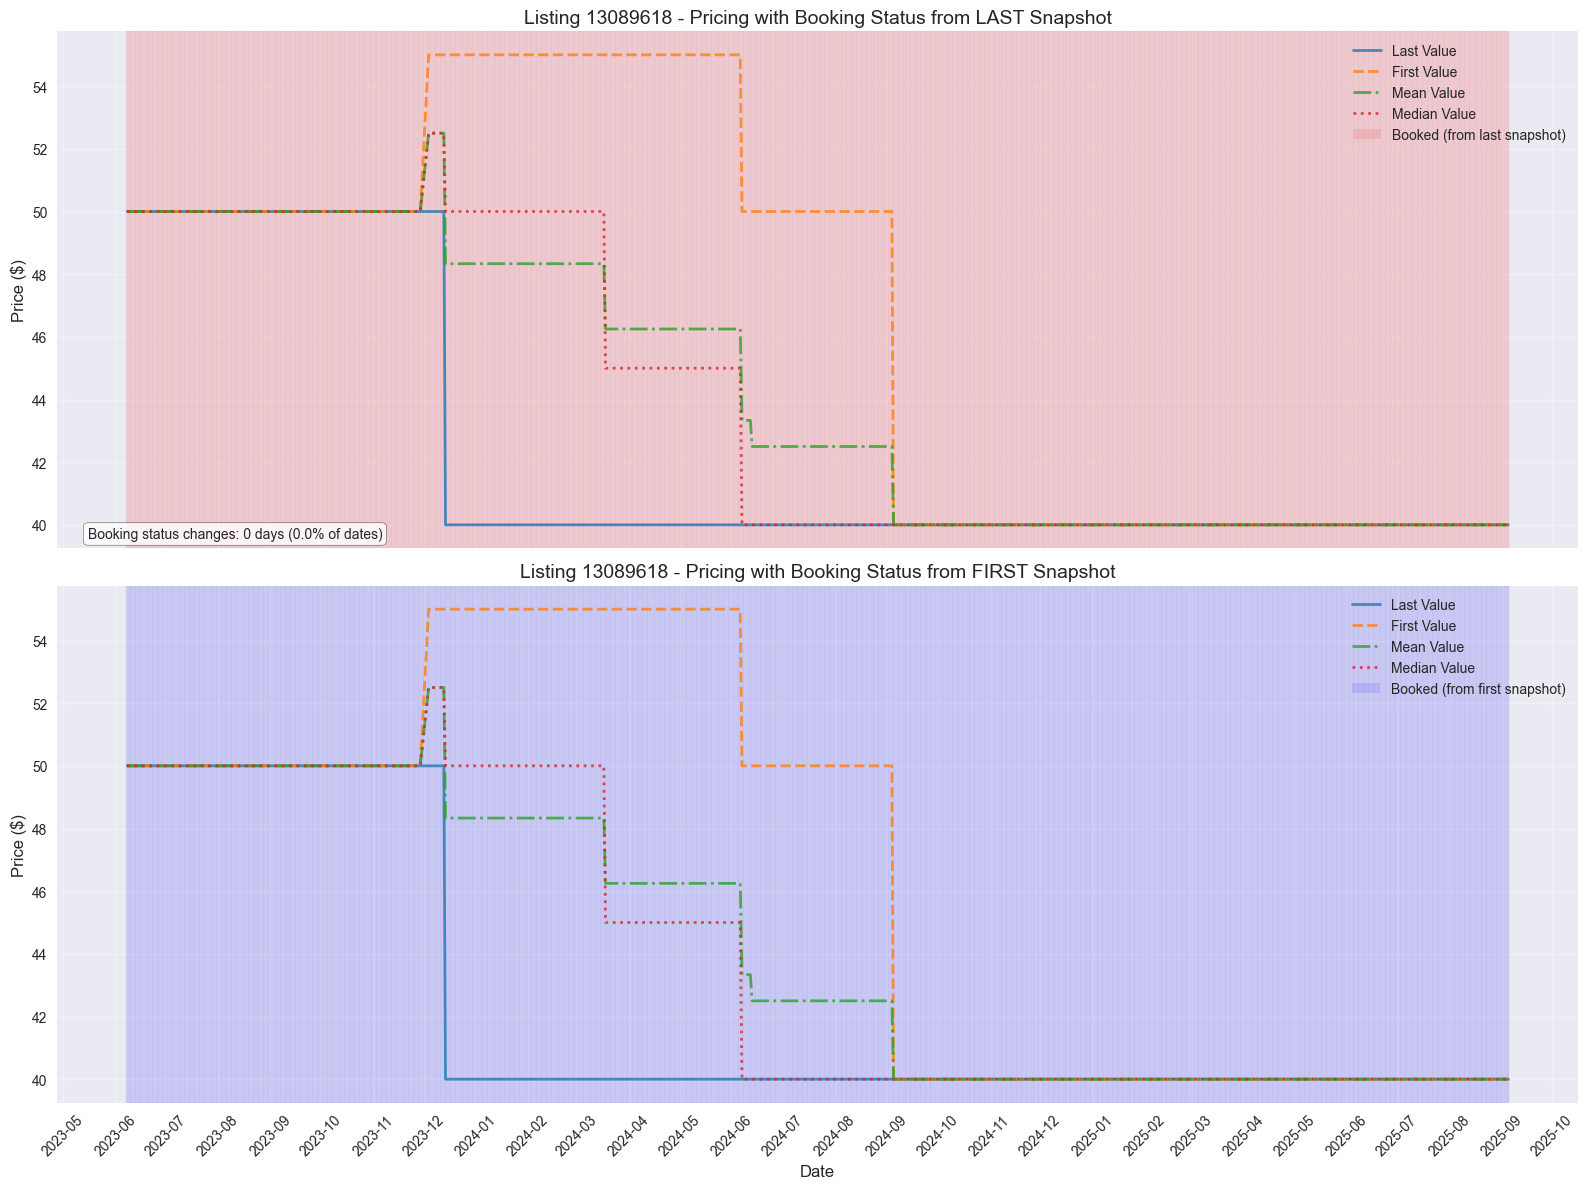

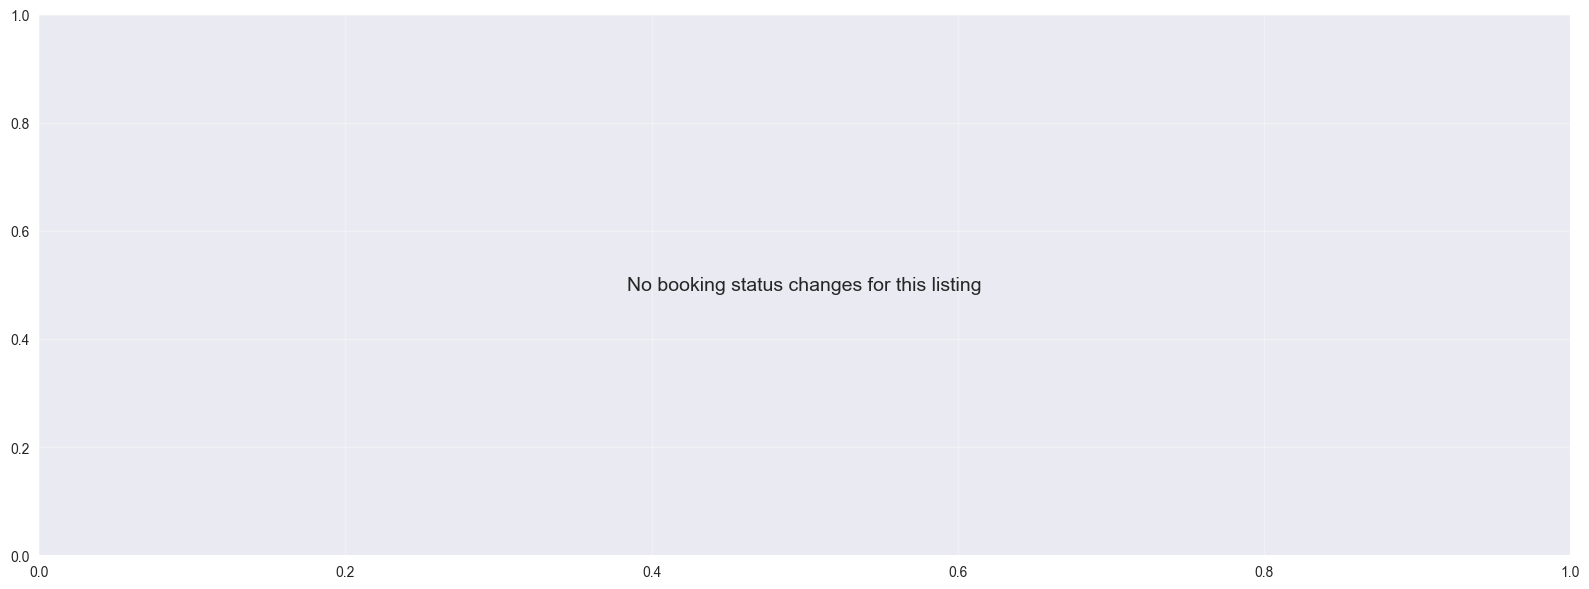

Processing listing 3/20: ID 1196393134718980158


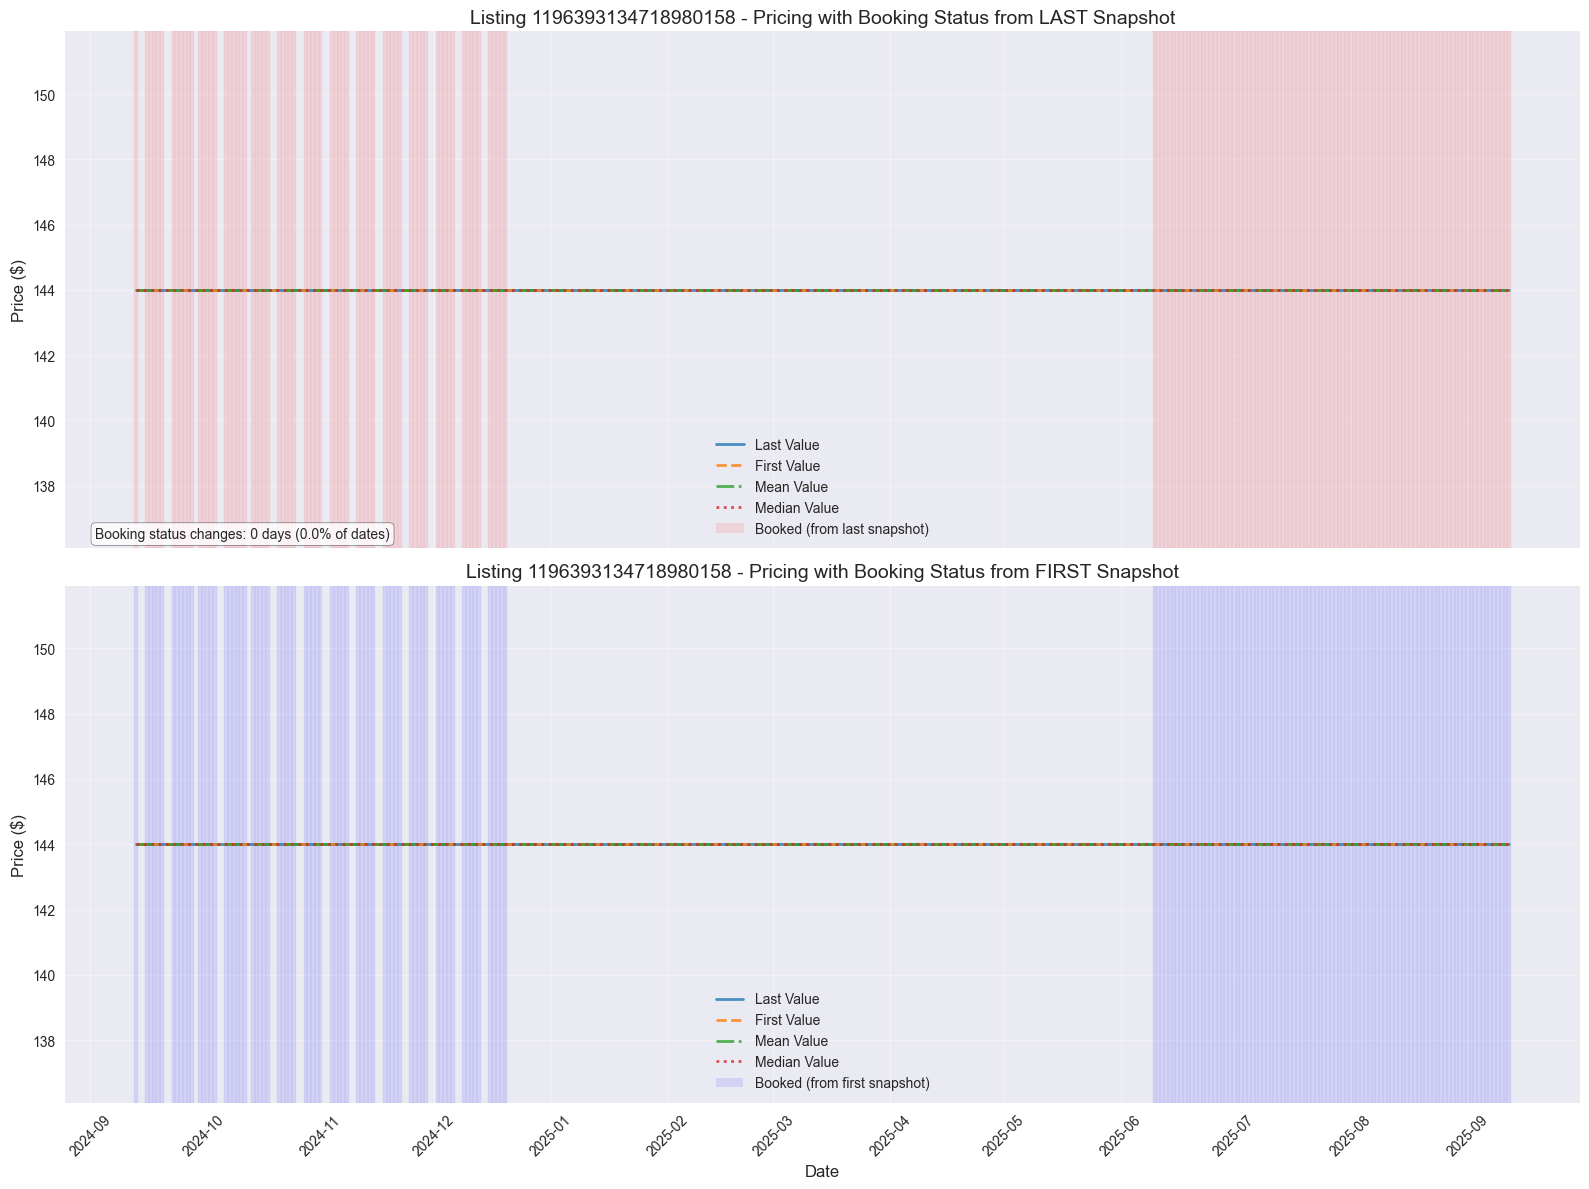

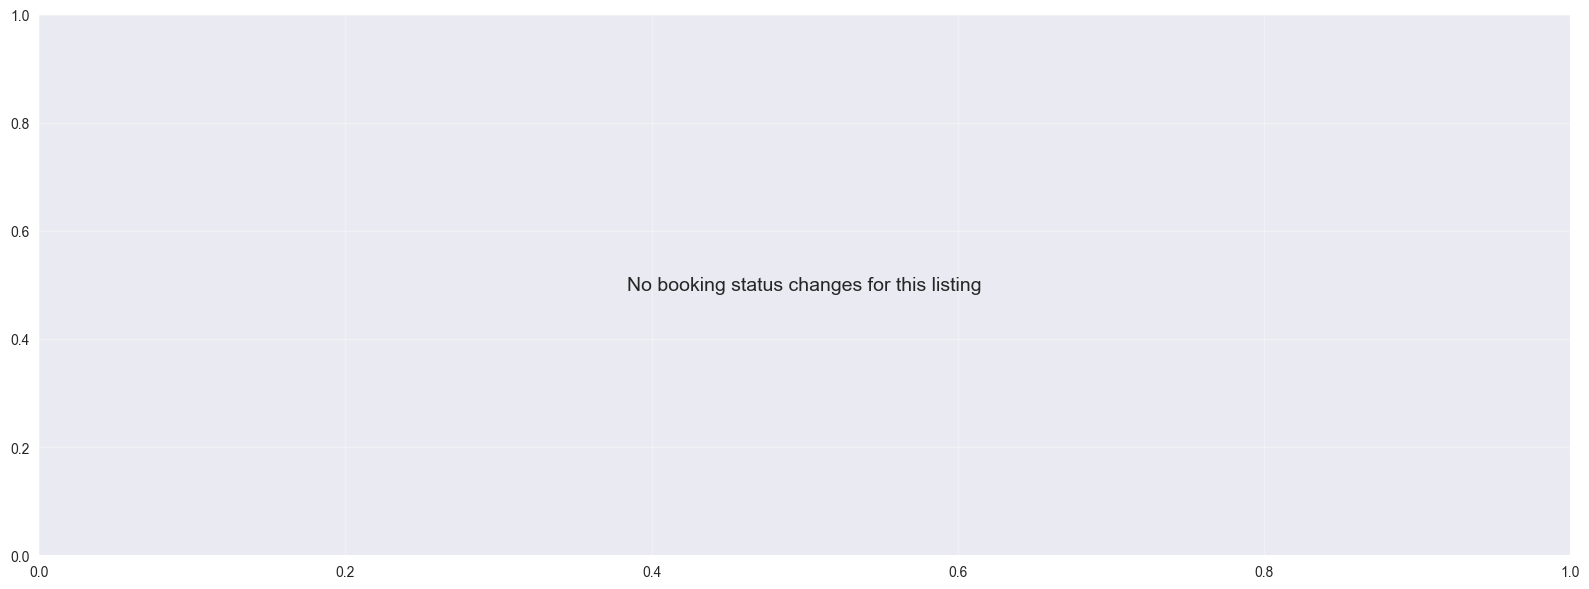

Processing listing 4/20: ID 31611383


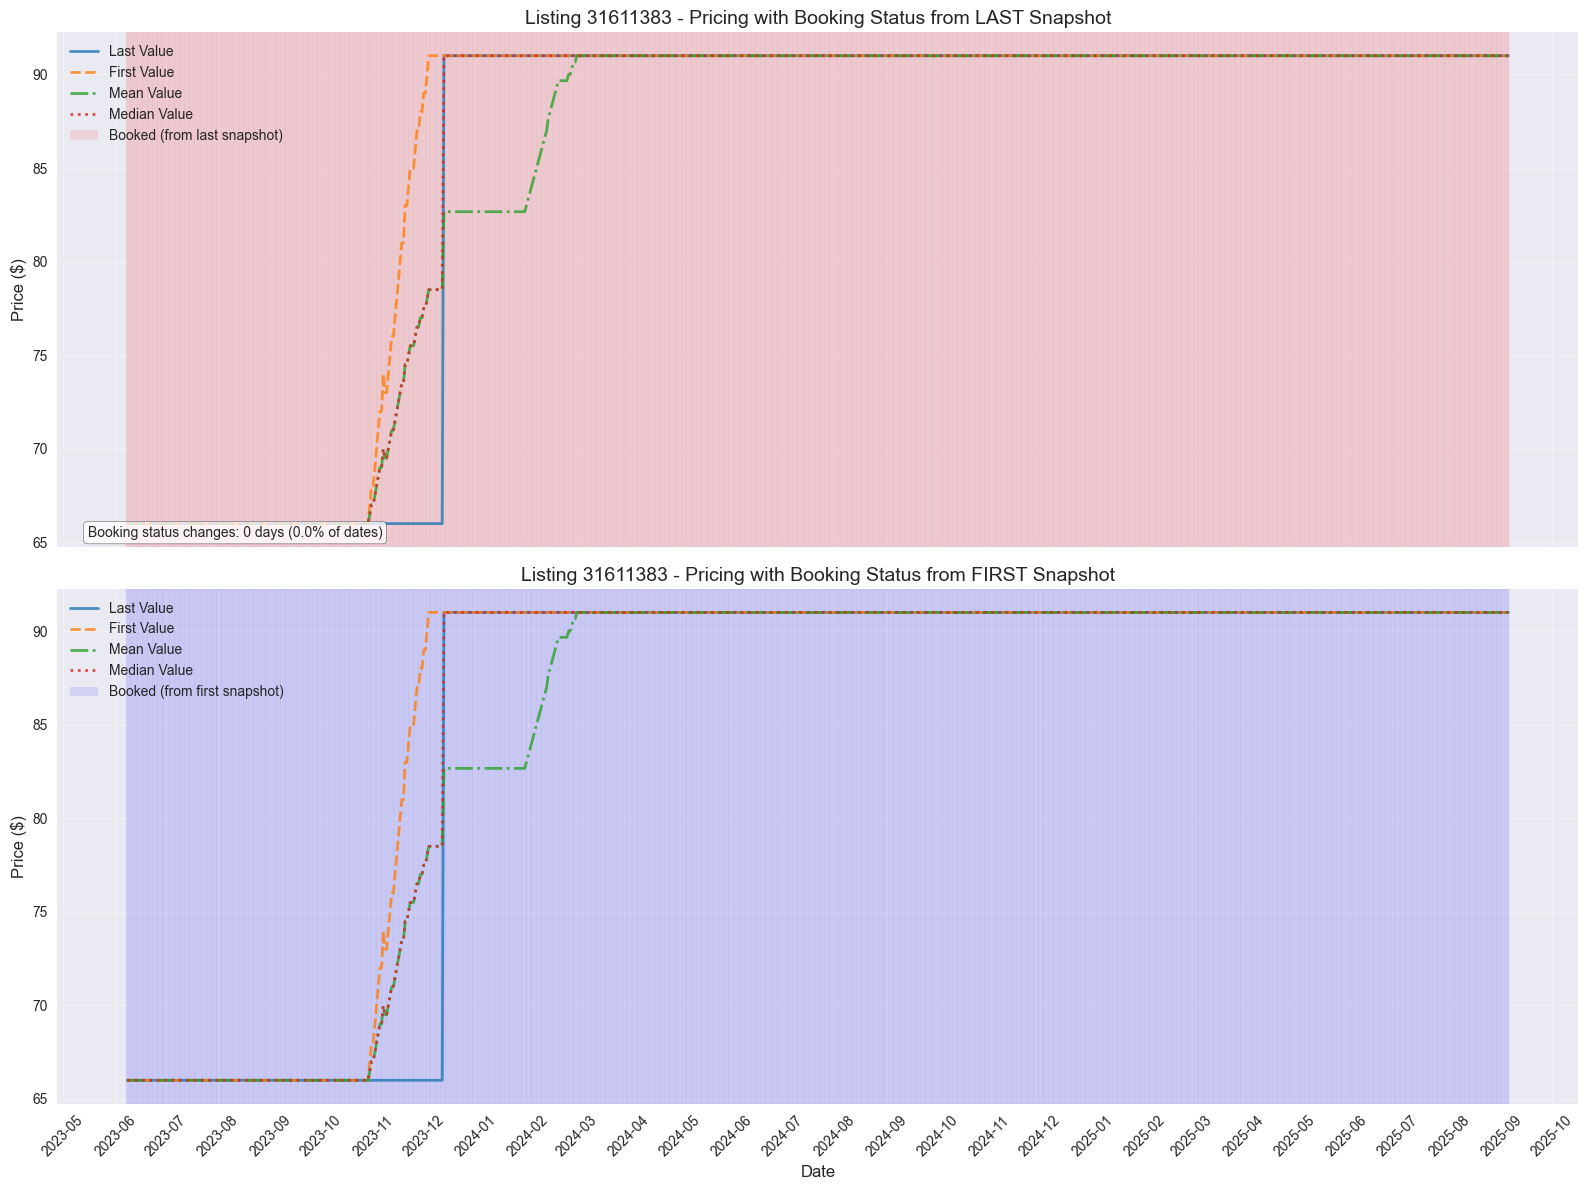

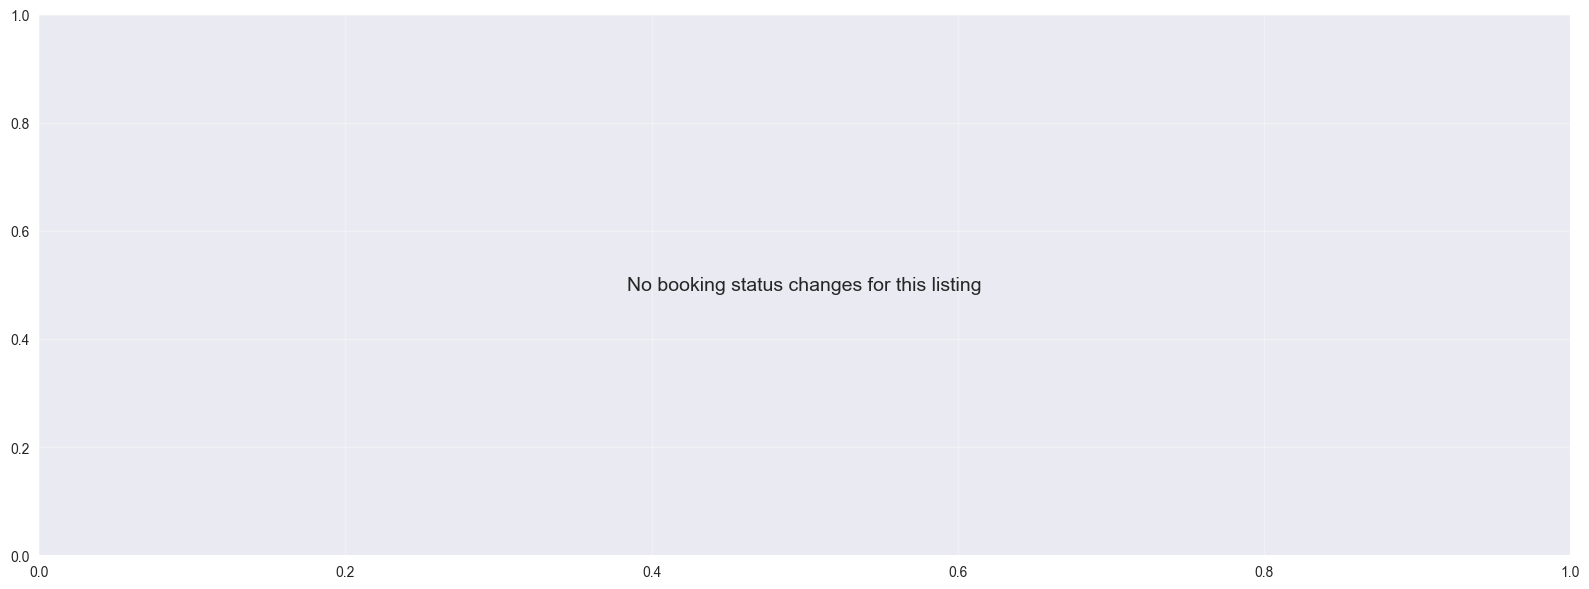

Processing listing 5/20: ID 1158033190621281565


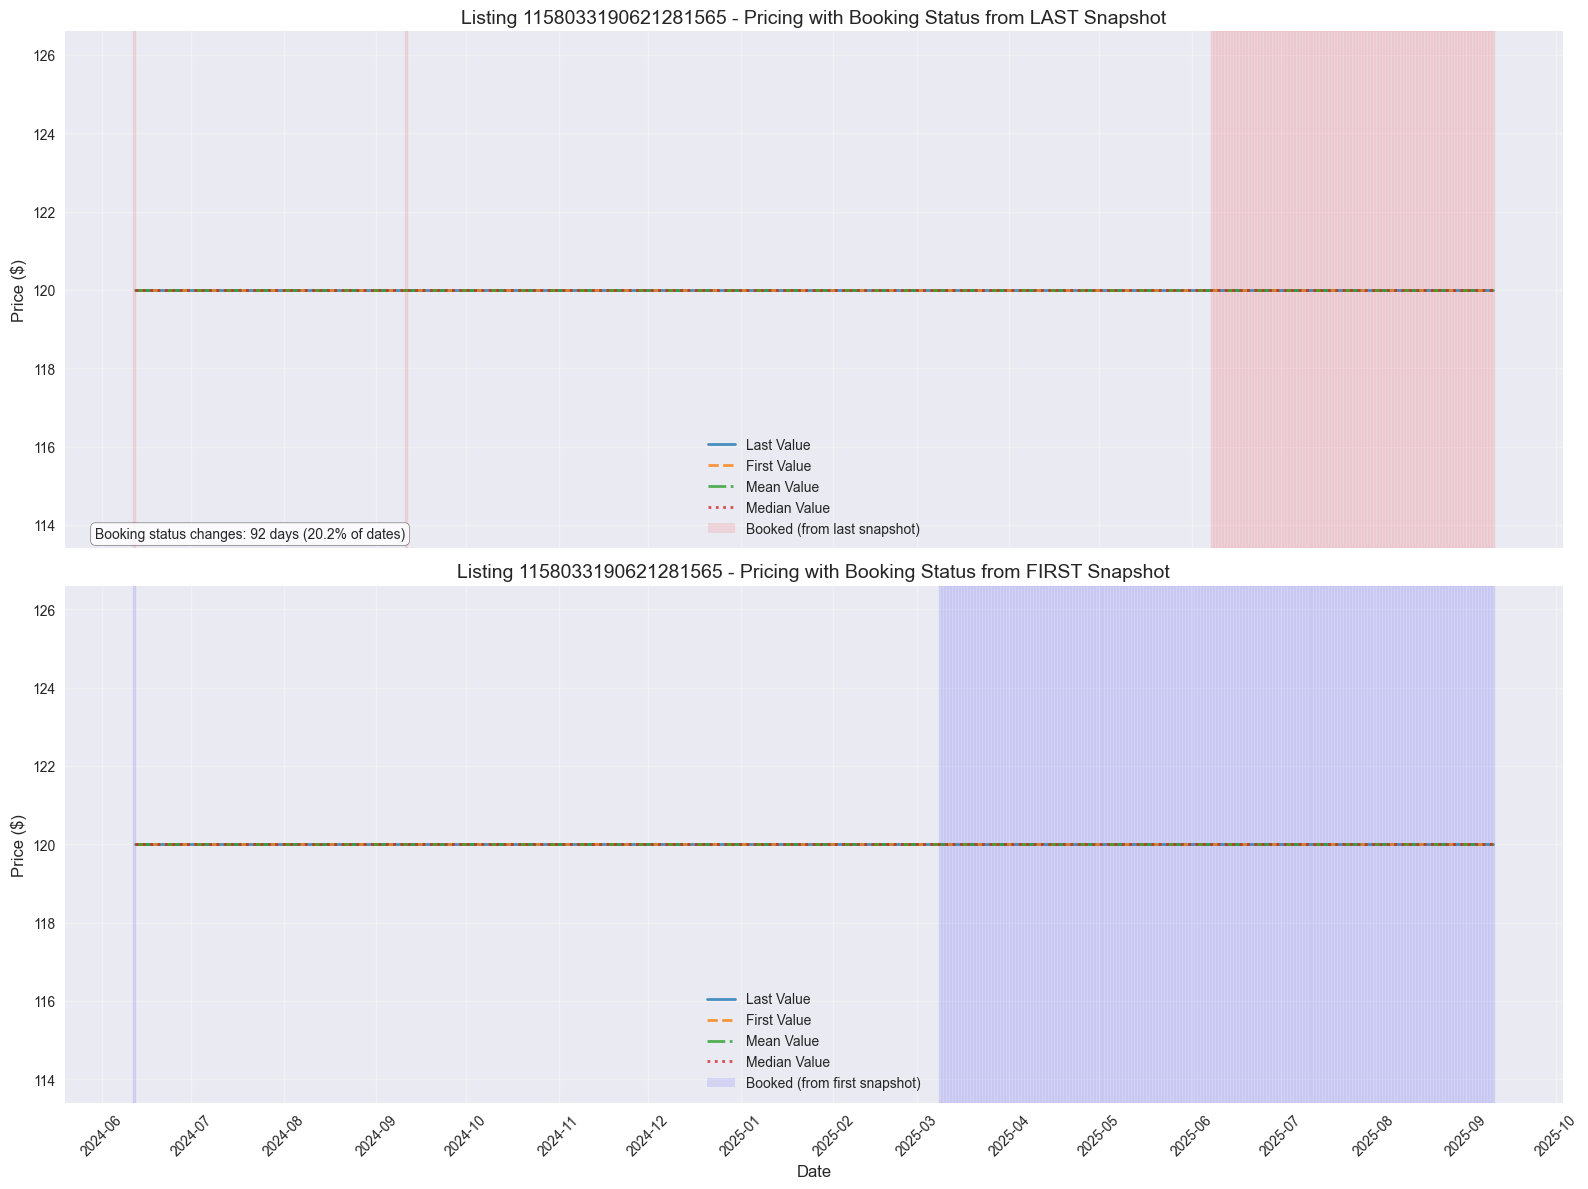

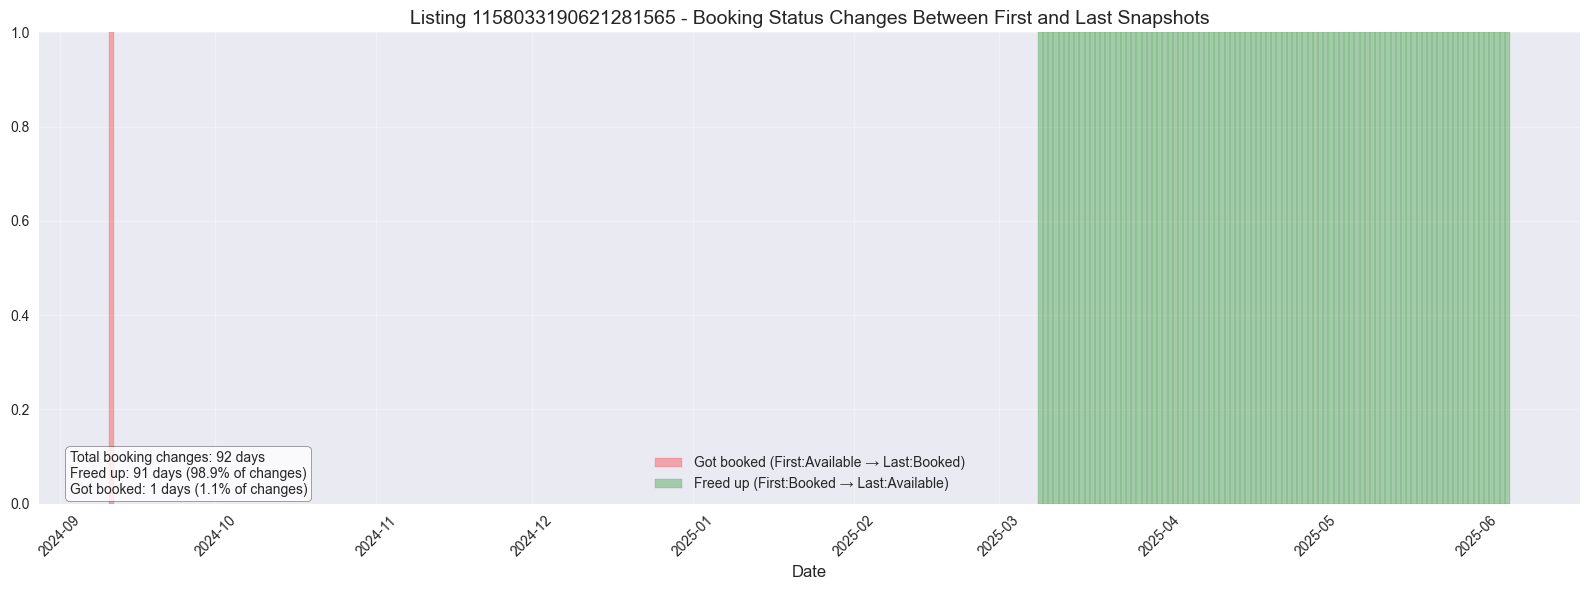

Processing listing 6/20: ID 51627418


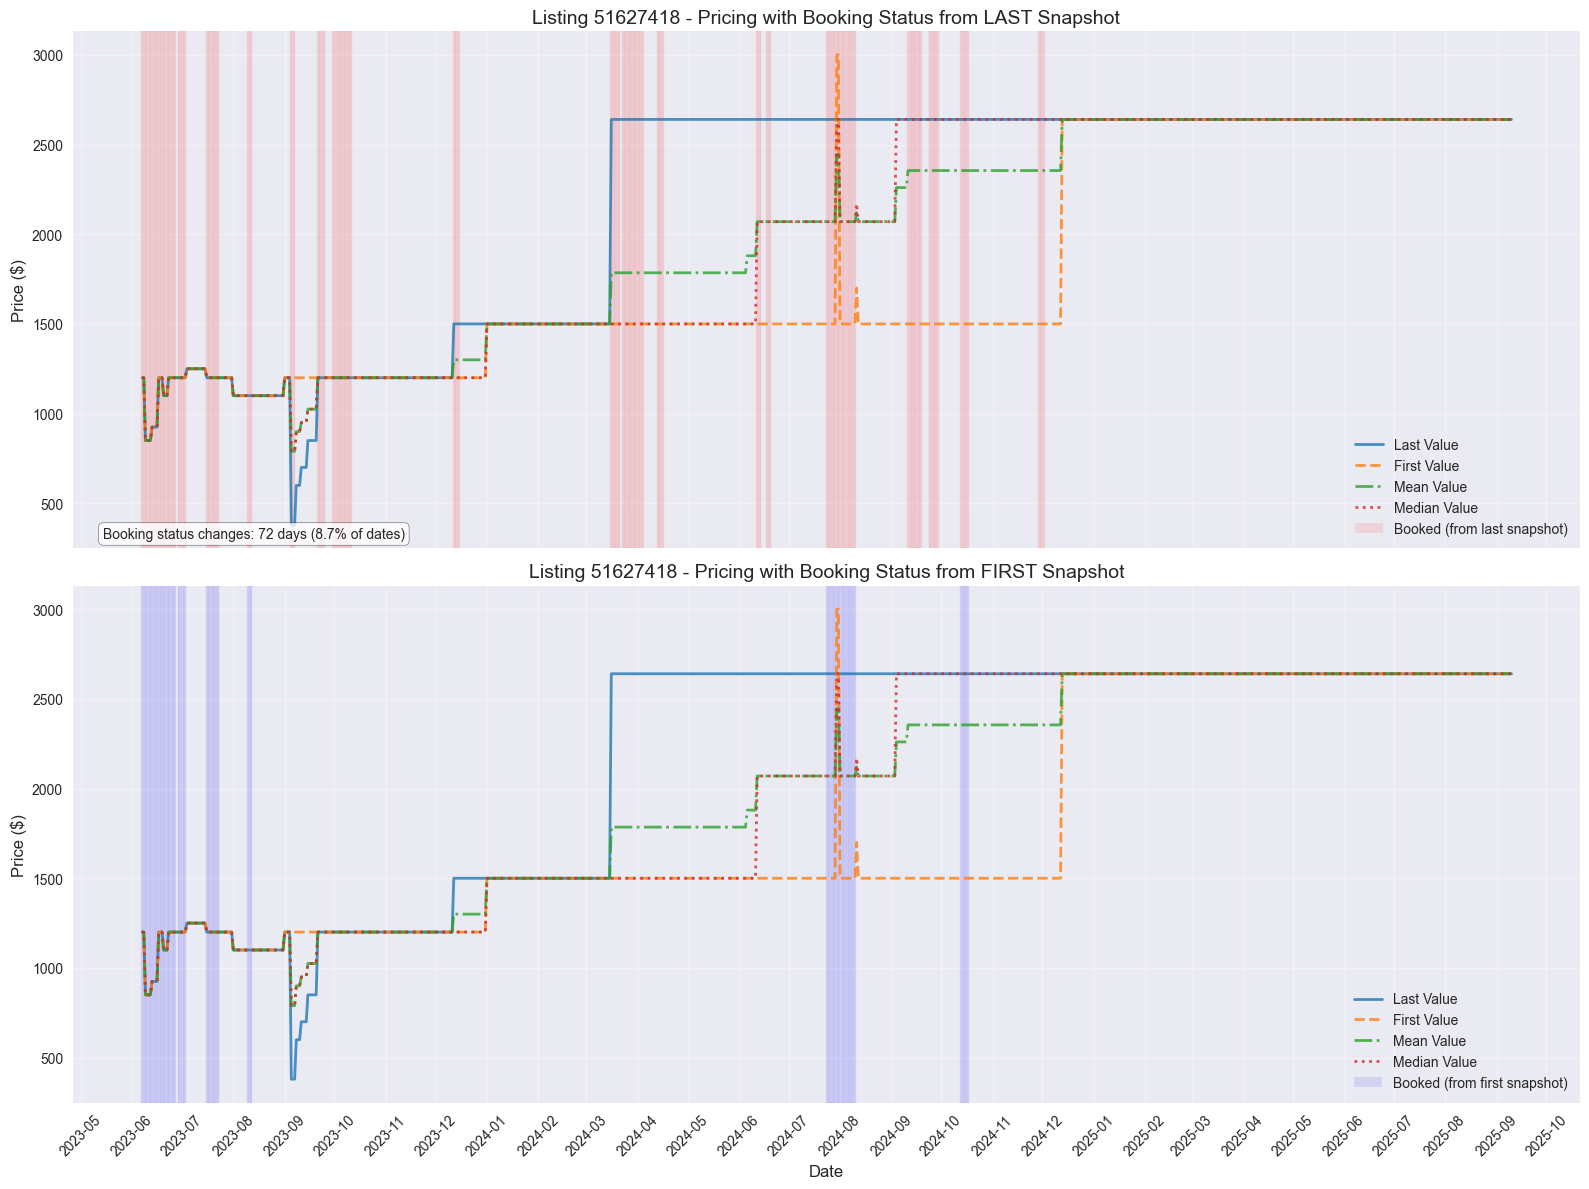

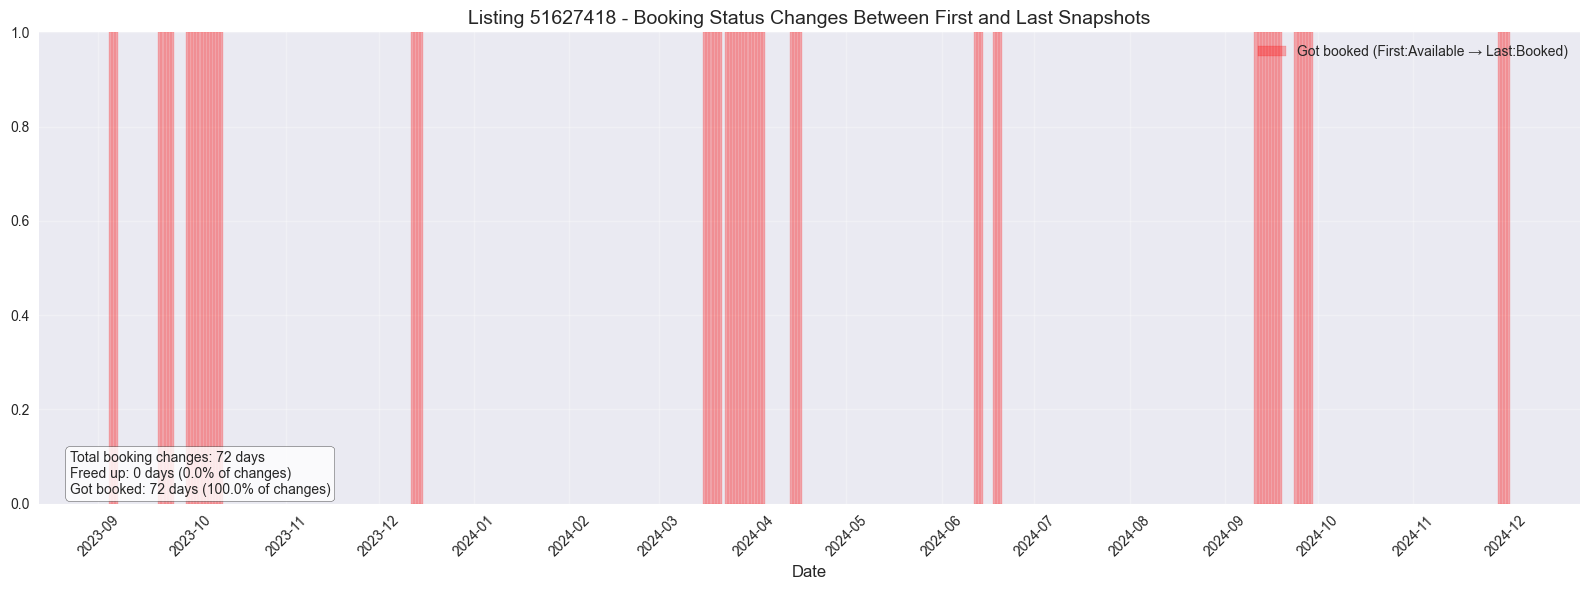

Processing listing 7/20: ID 710657031768153103


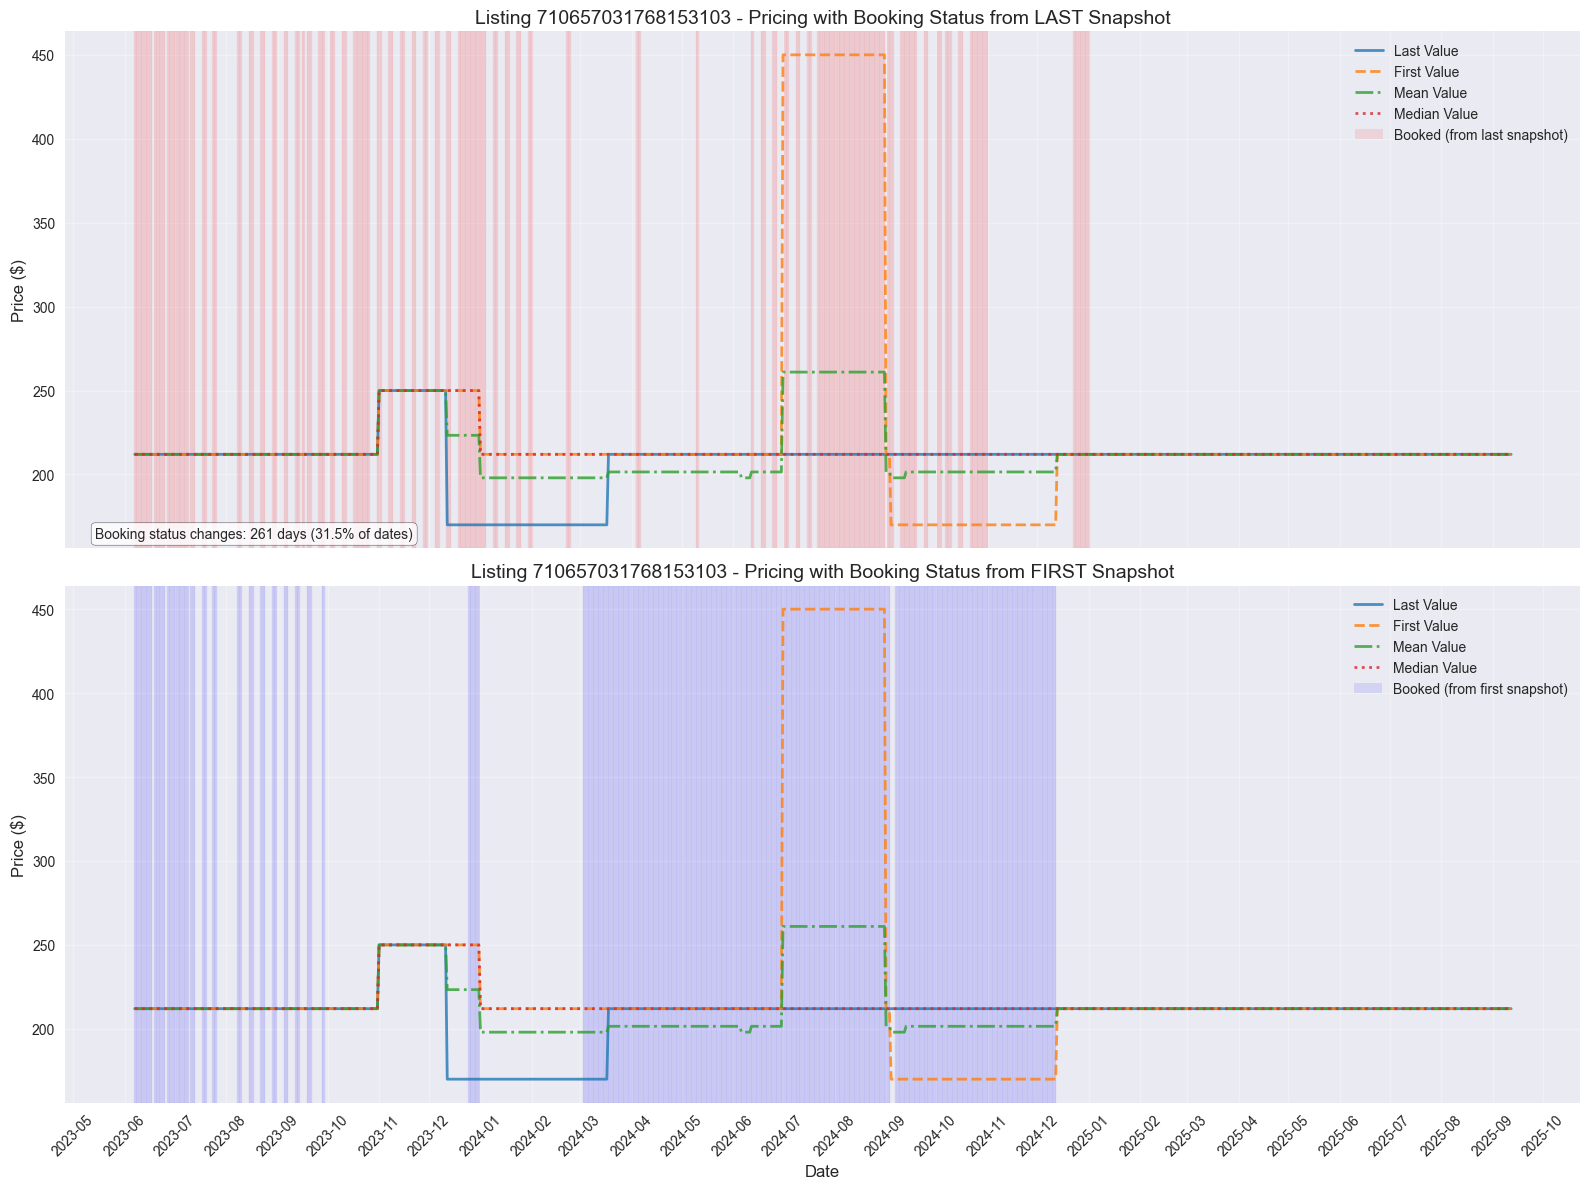

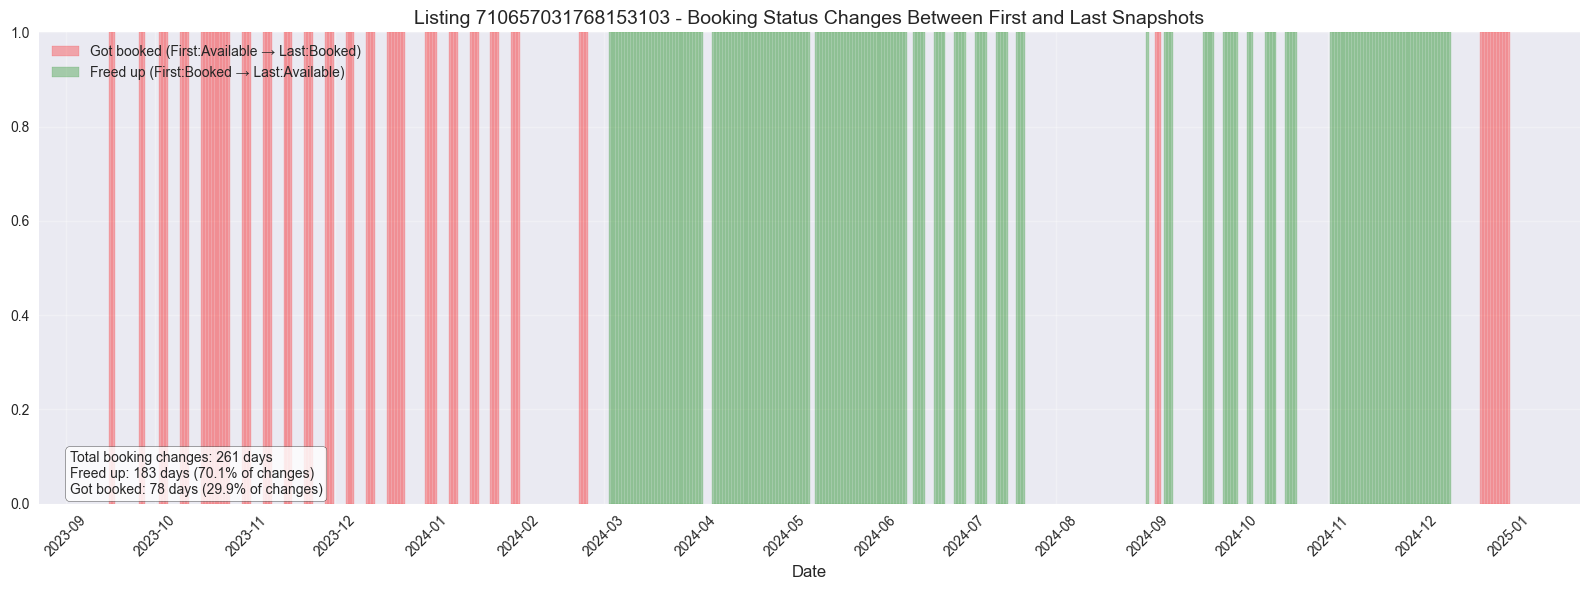

Processing listing 8/20: ID 915295603757492336


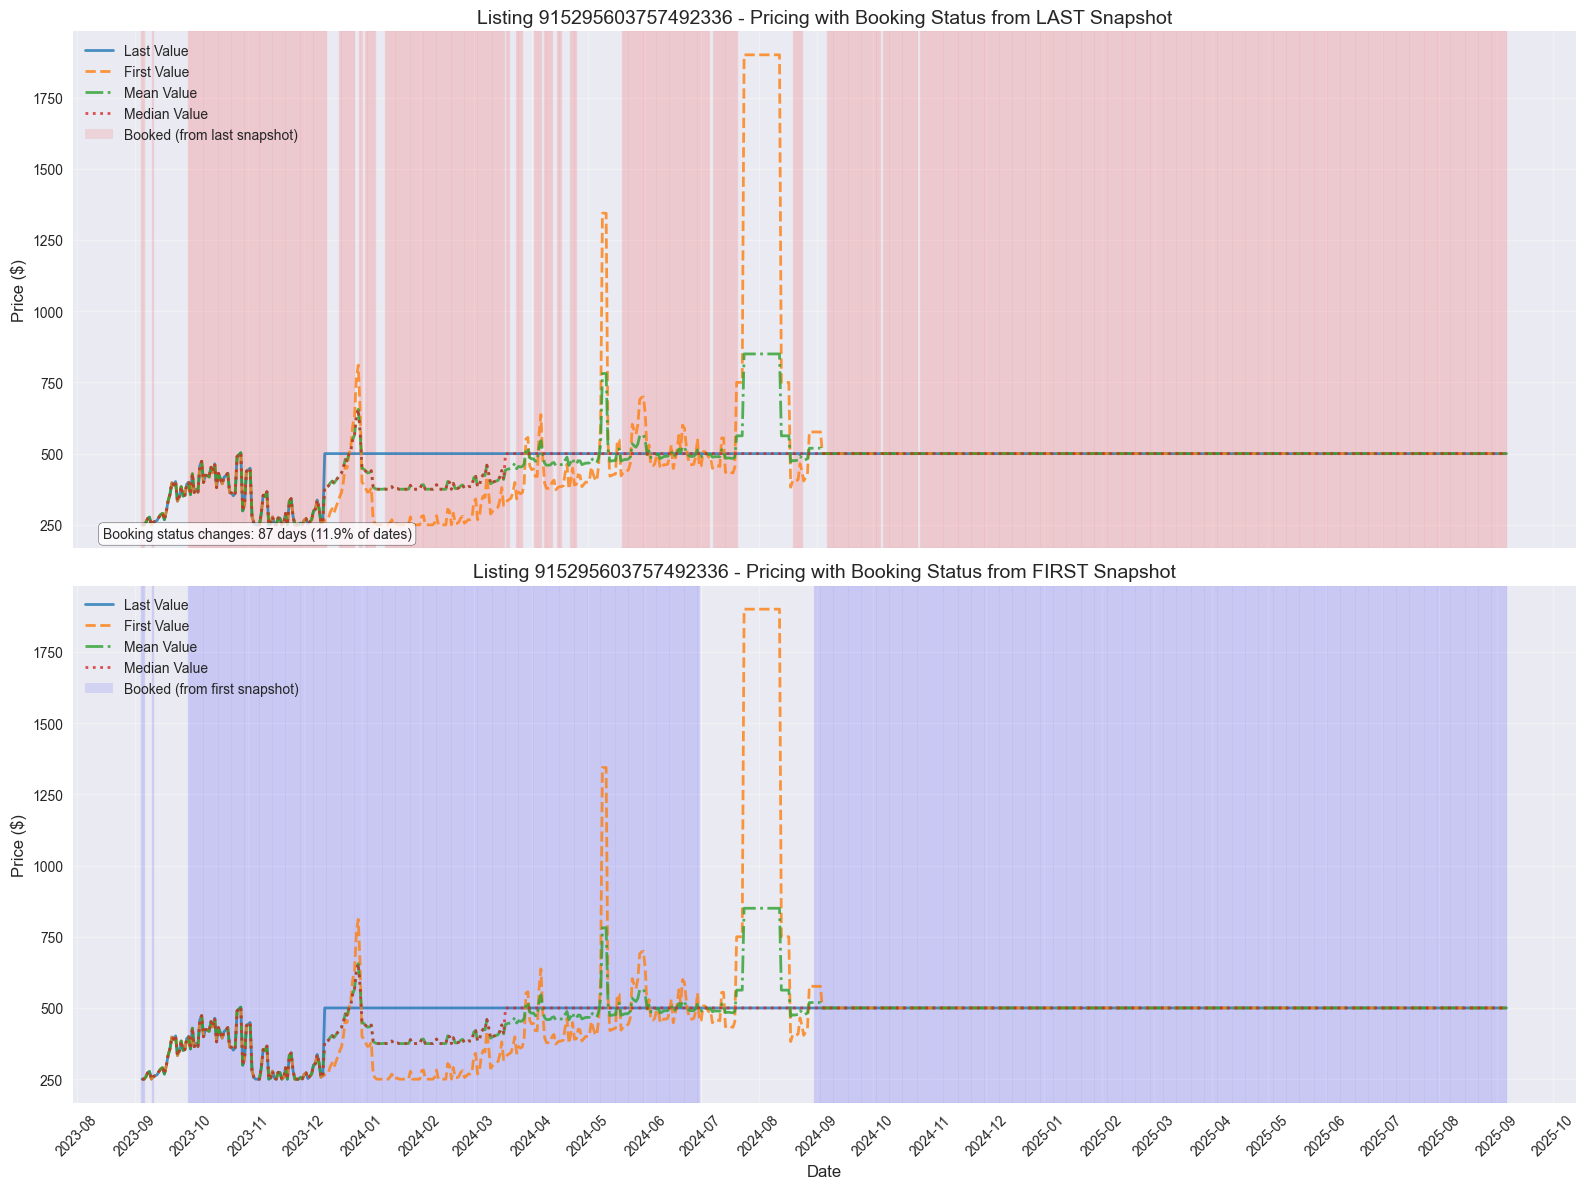

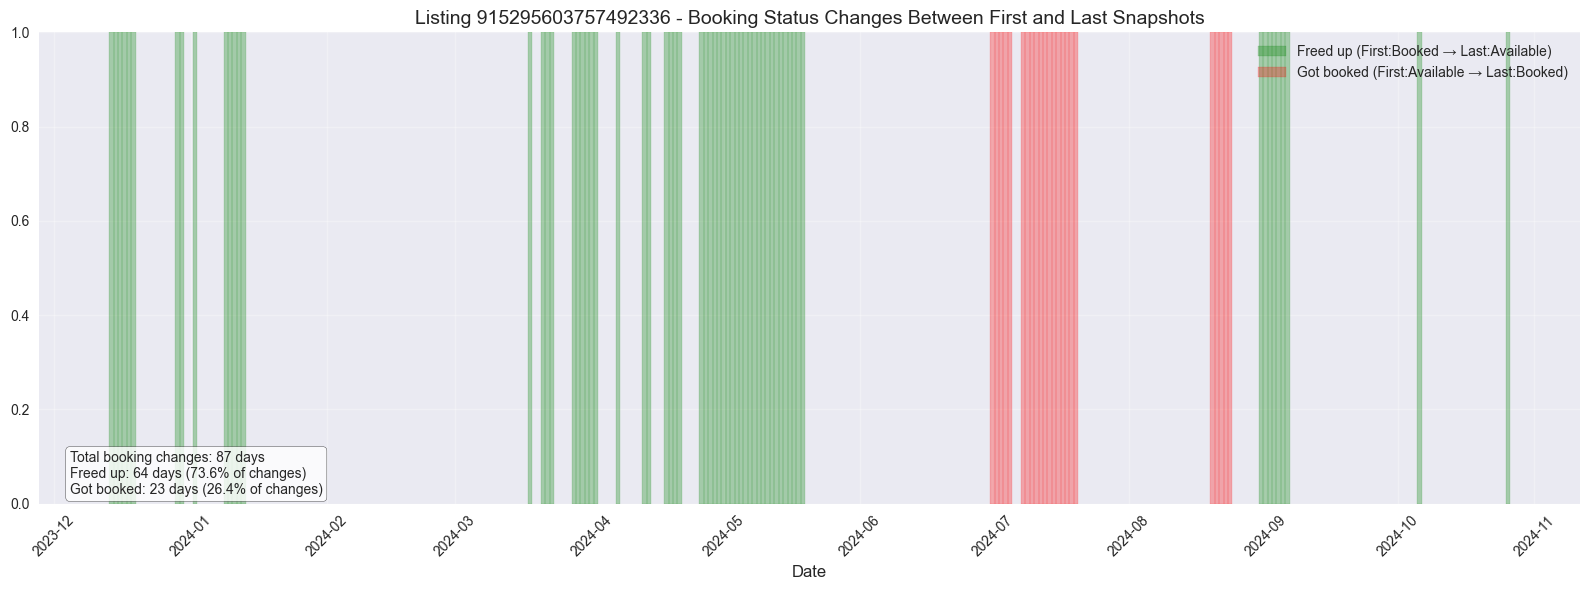

Processing listing 9/20: ID 45872673


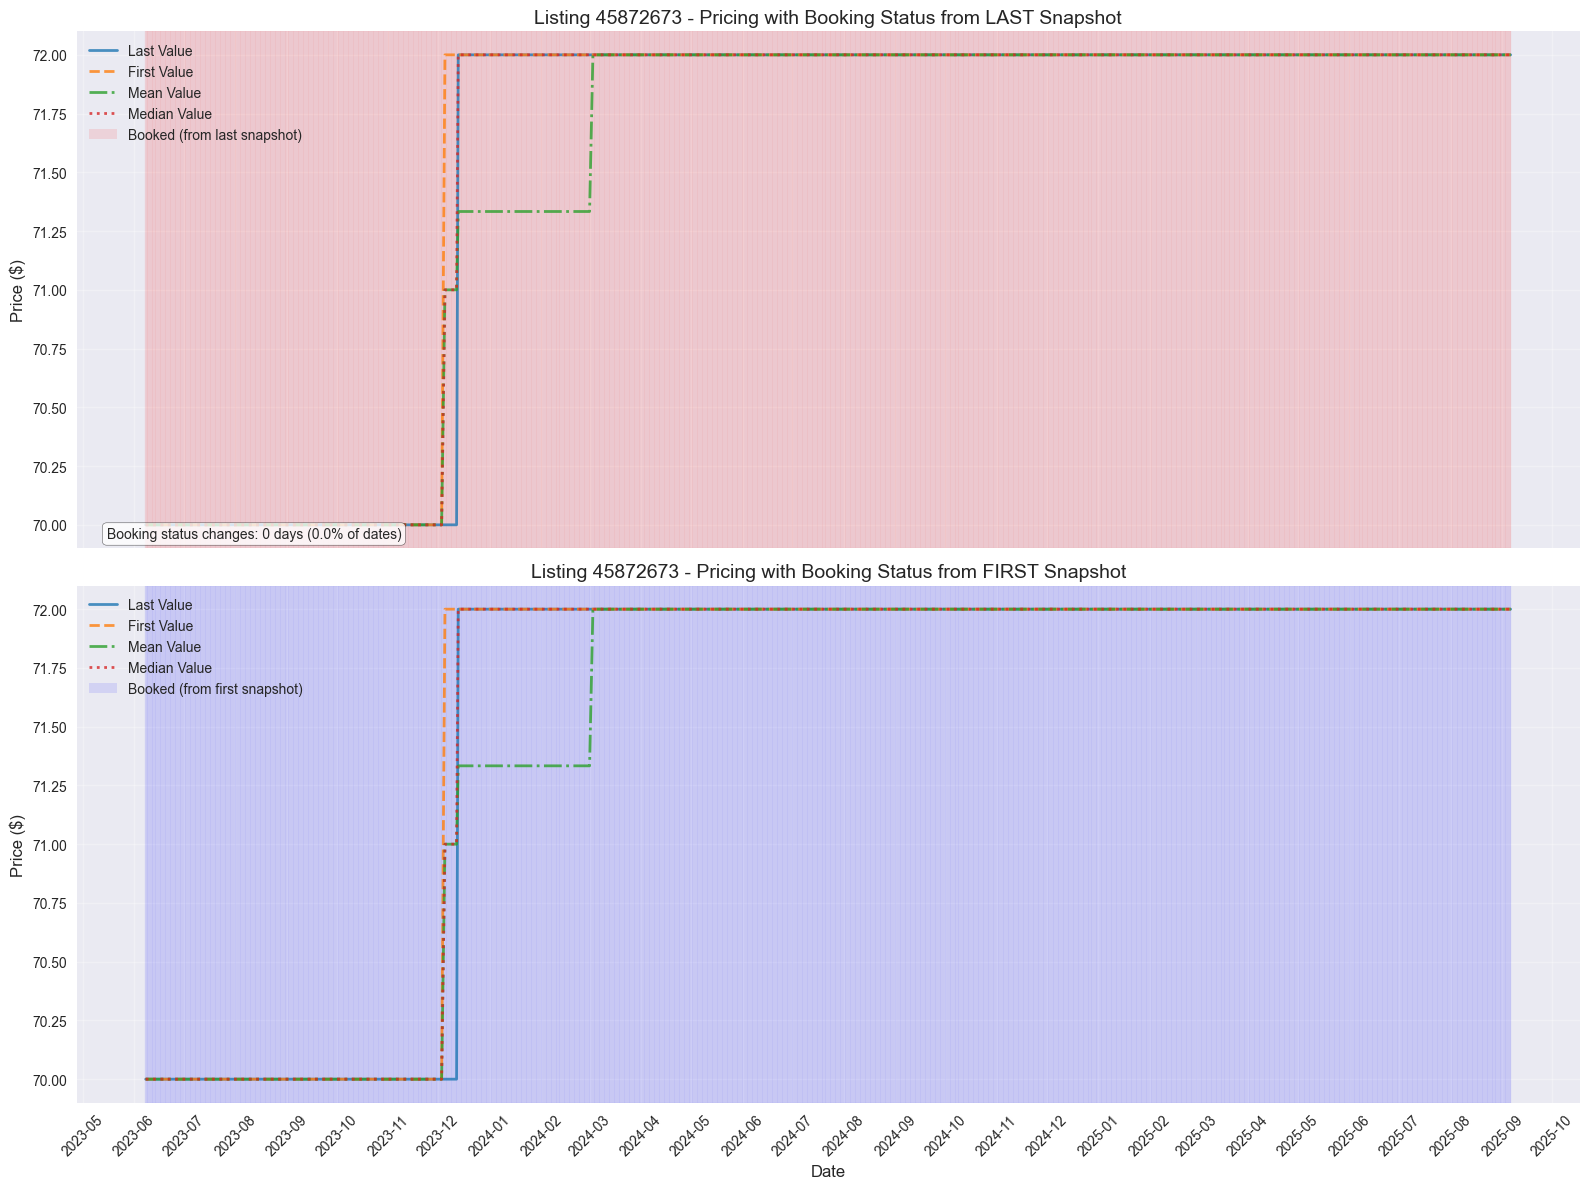

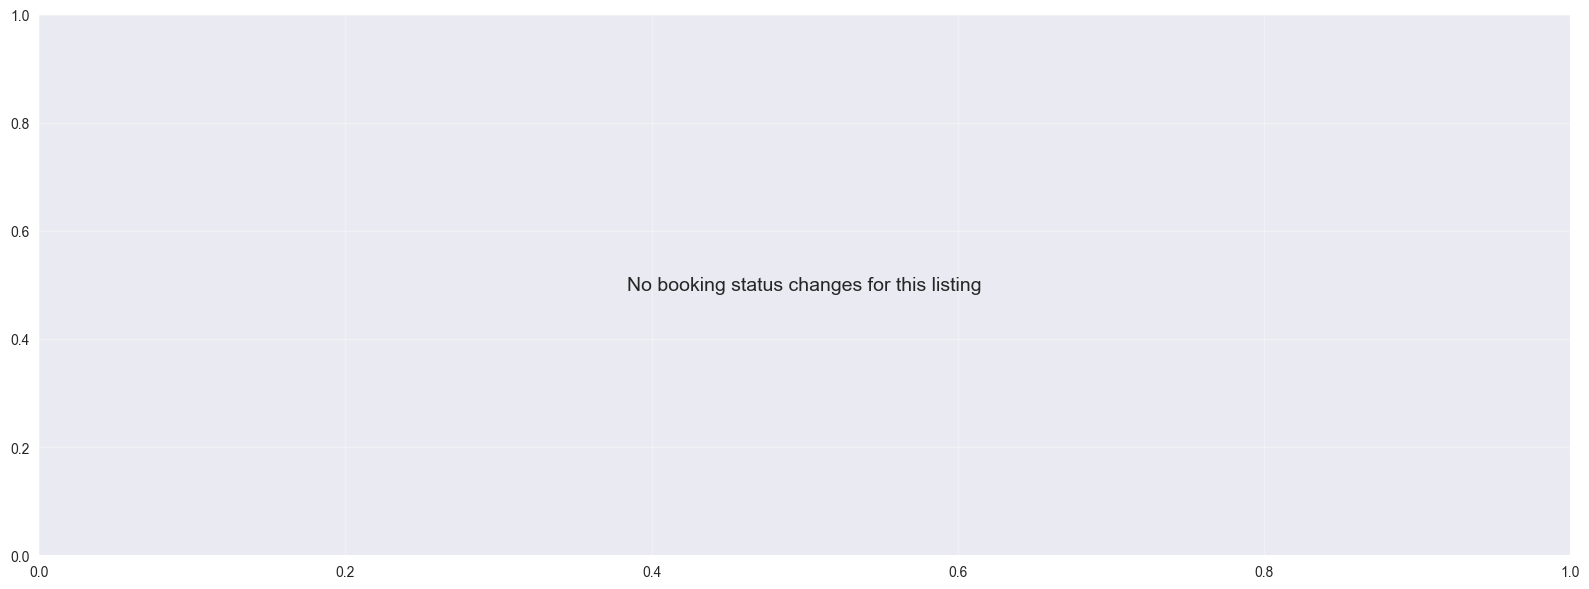

Processing listing 10/20: ID 2018724


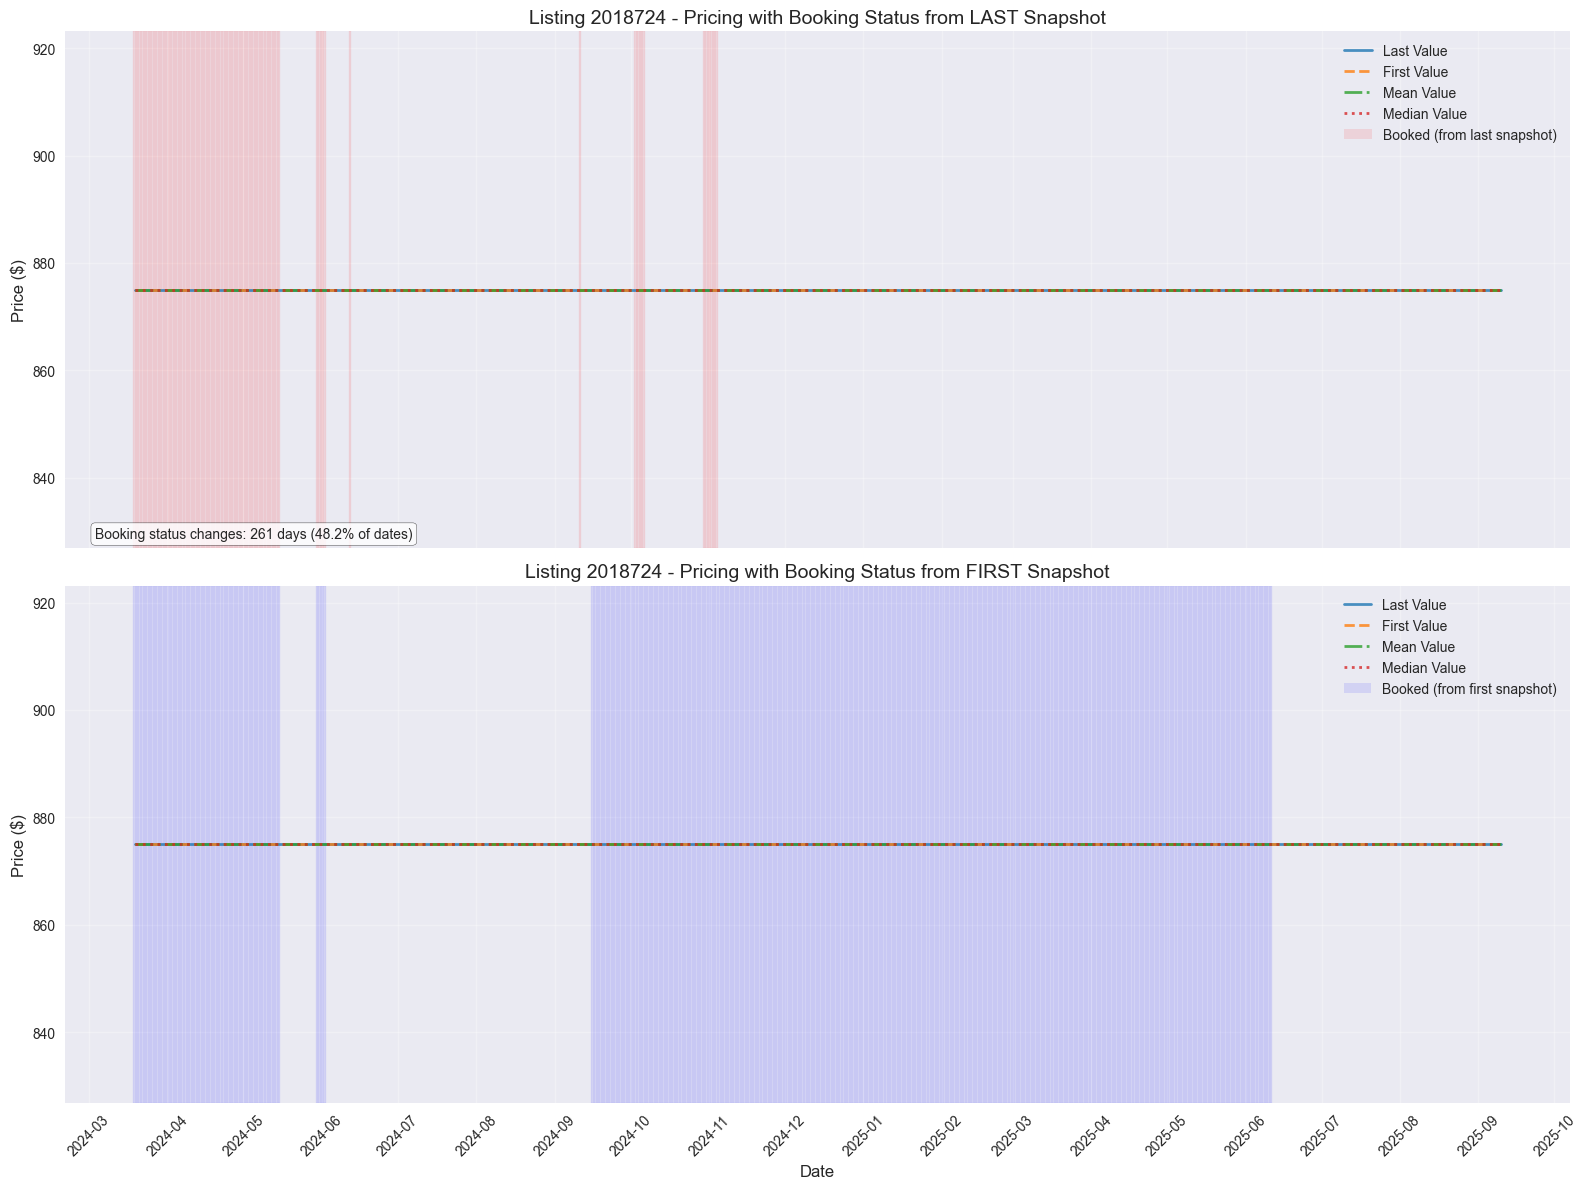

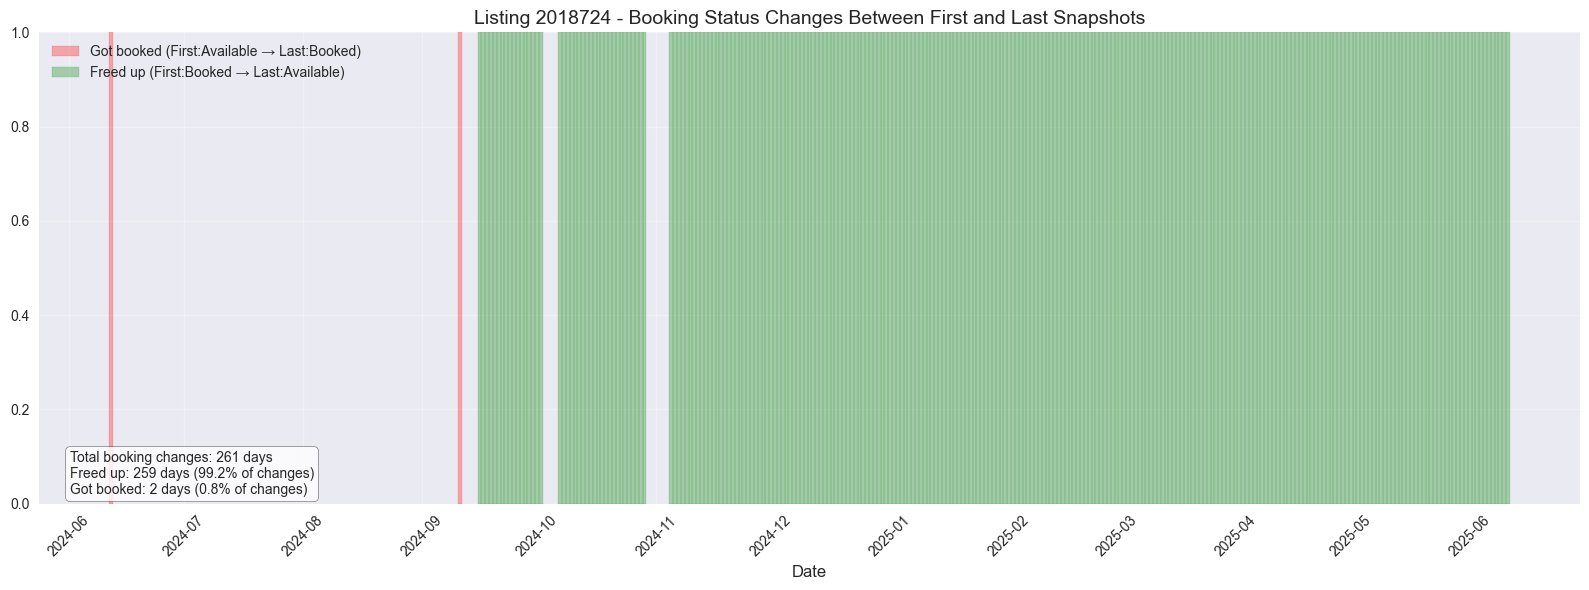

Processing listing 11/20: ID 28995839


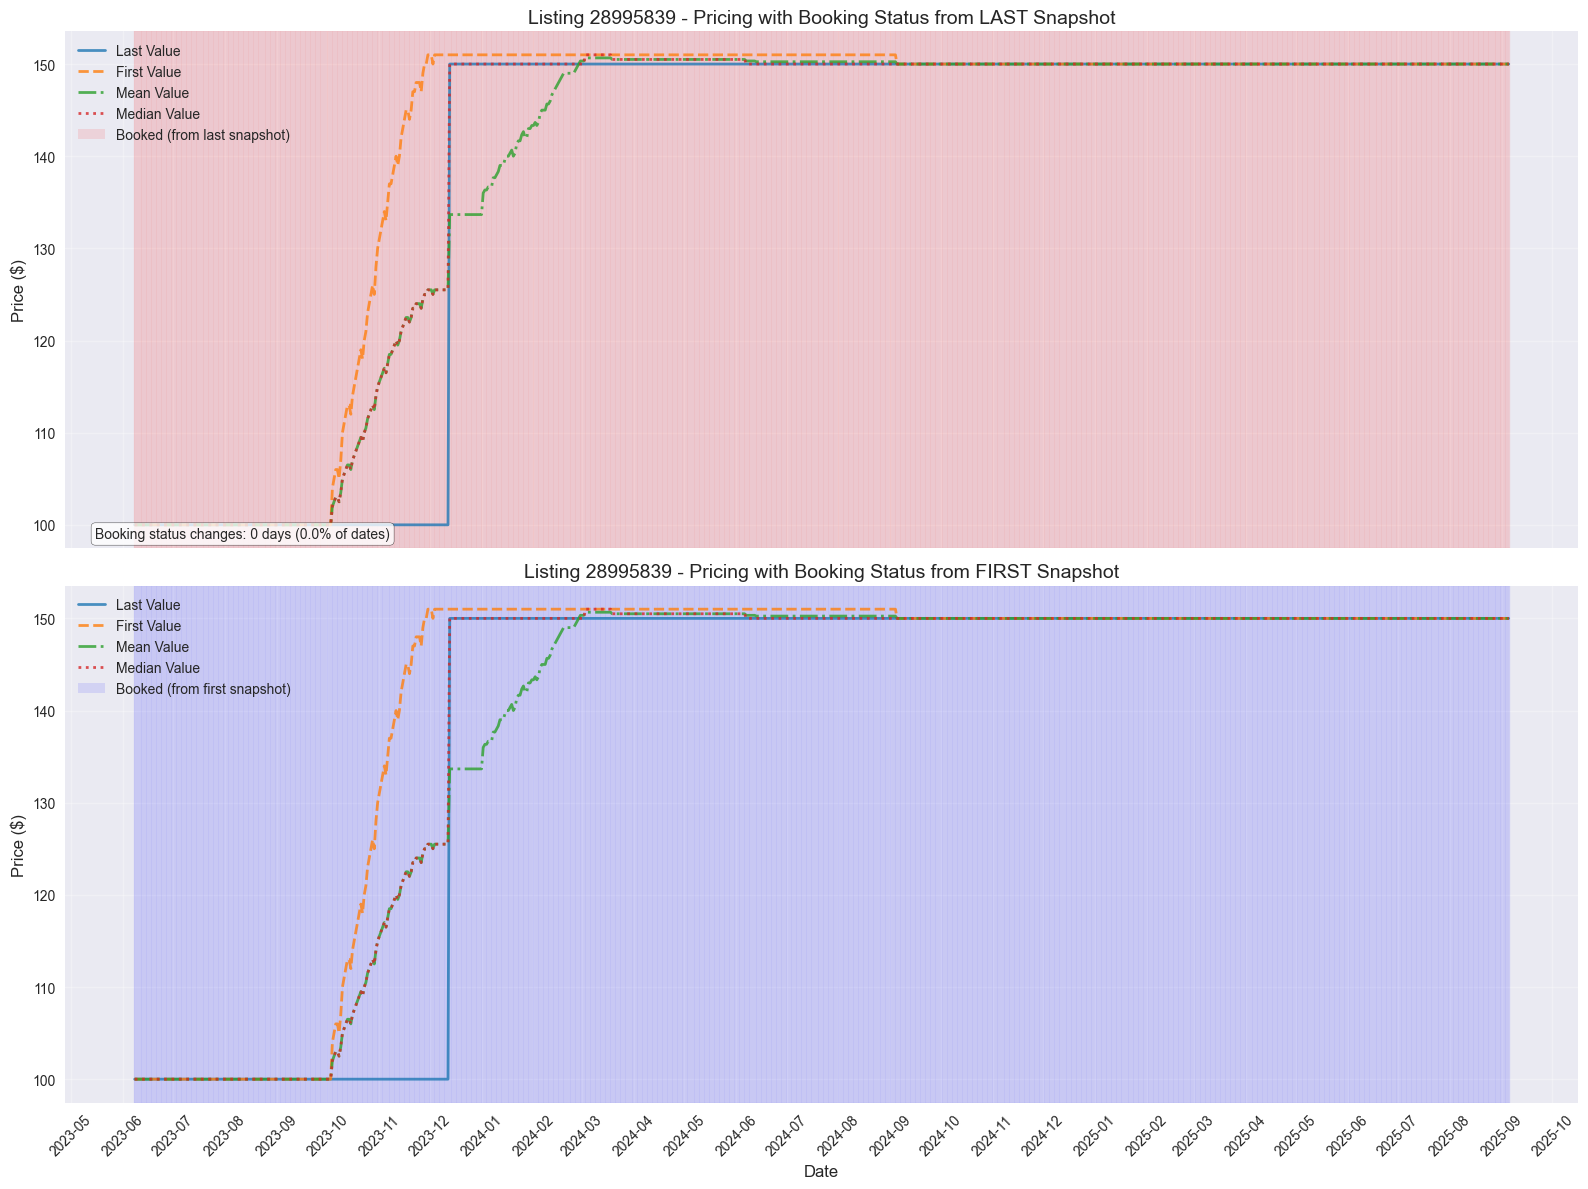

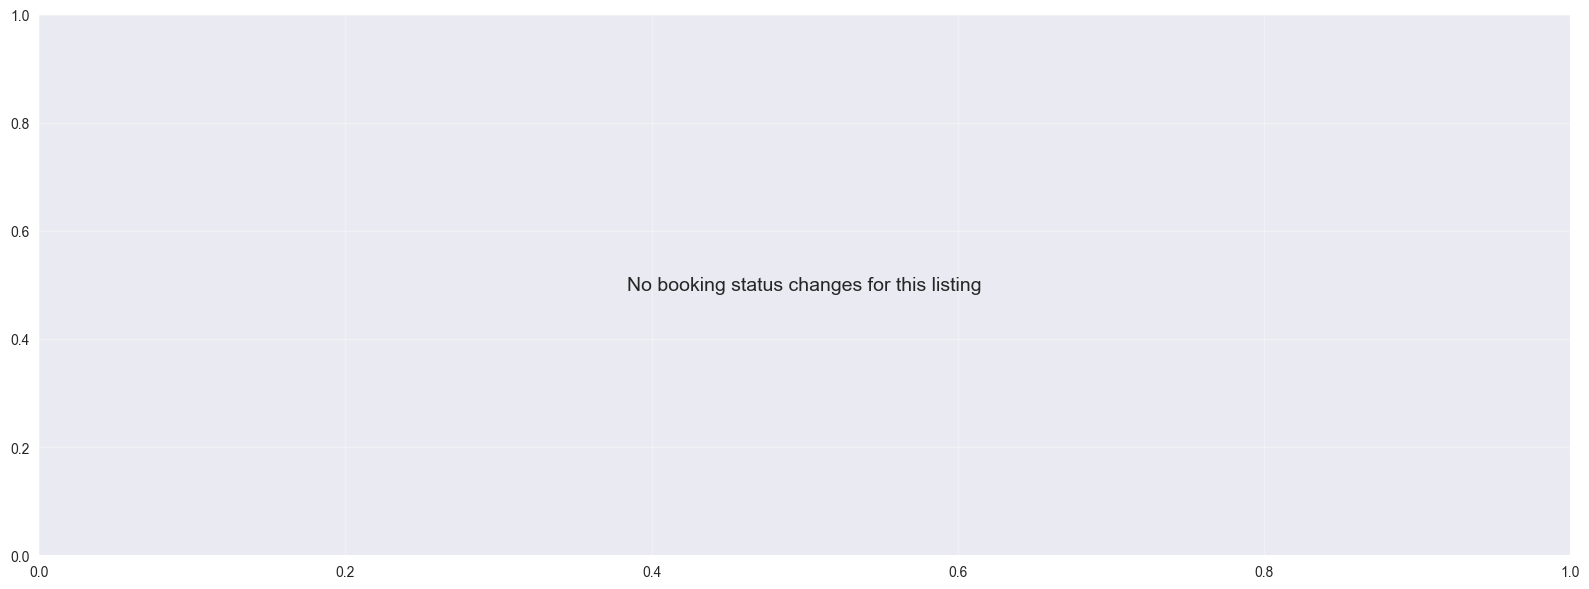

Processing listing 12/20: ID 19955987


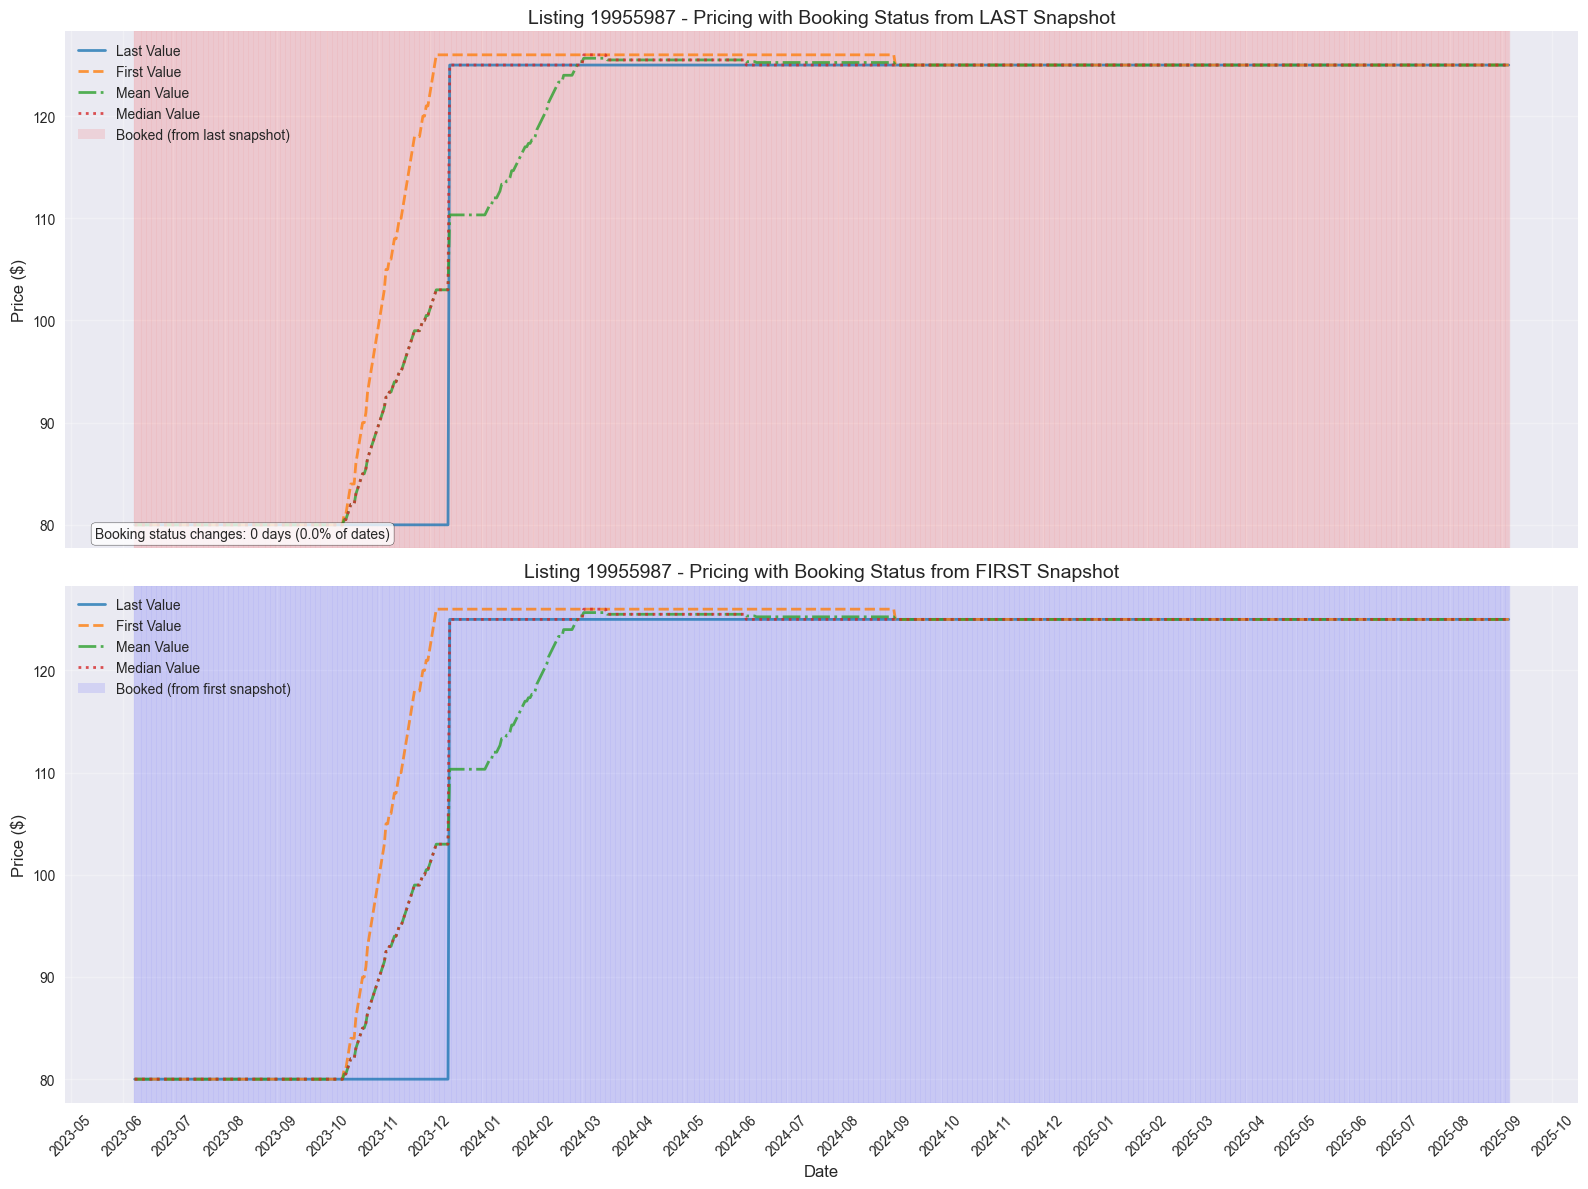

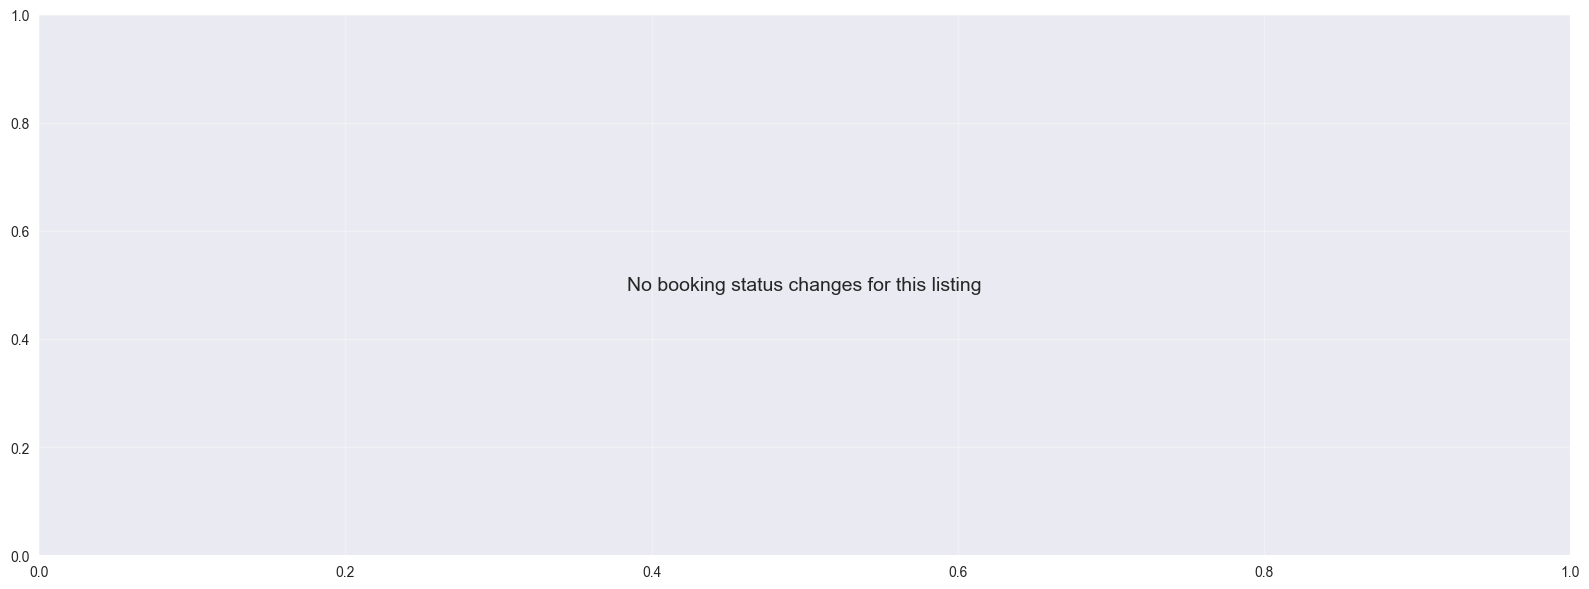

Processing listing 13/20: ID 1039067948234576204


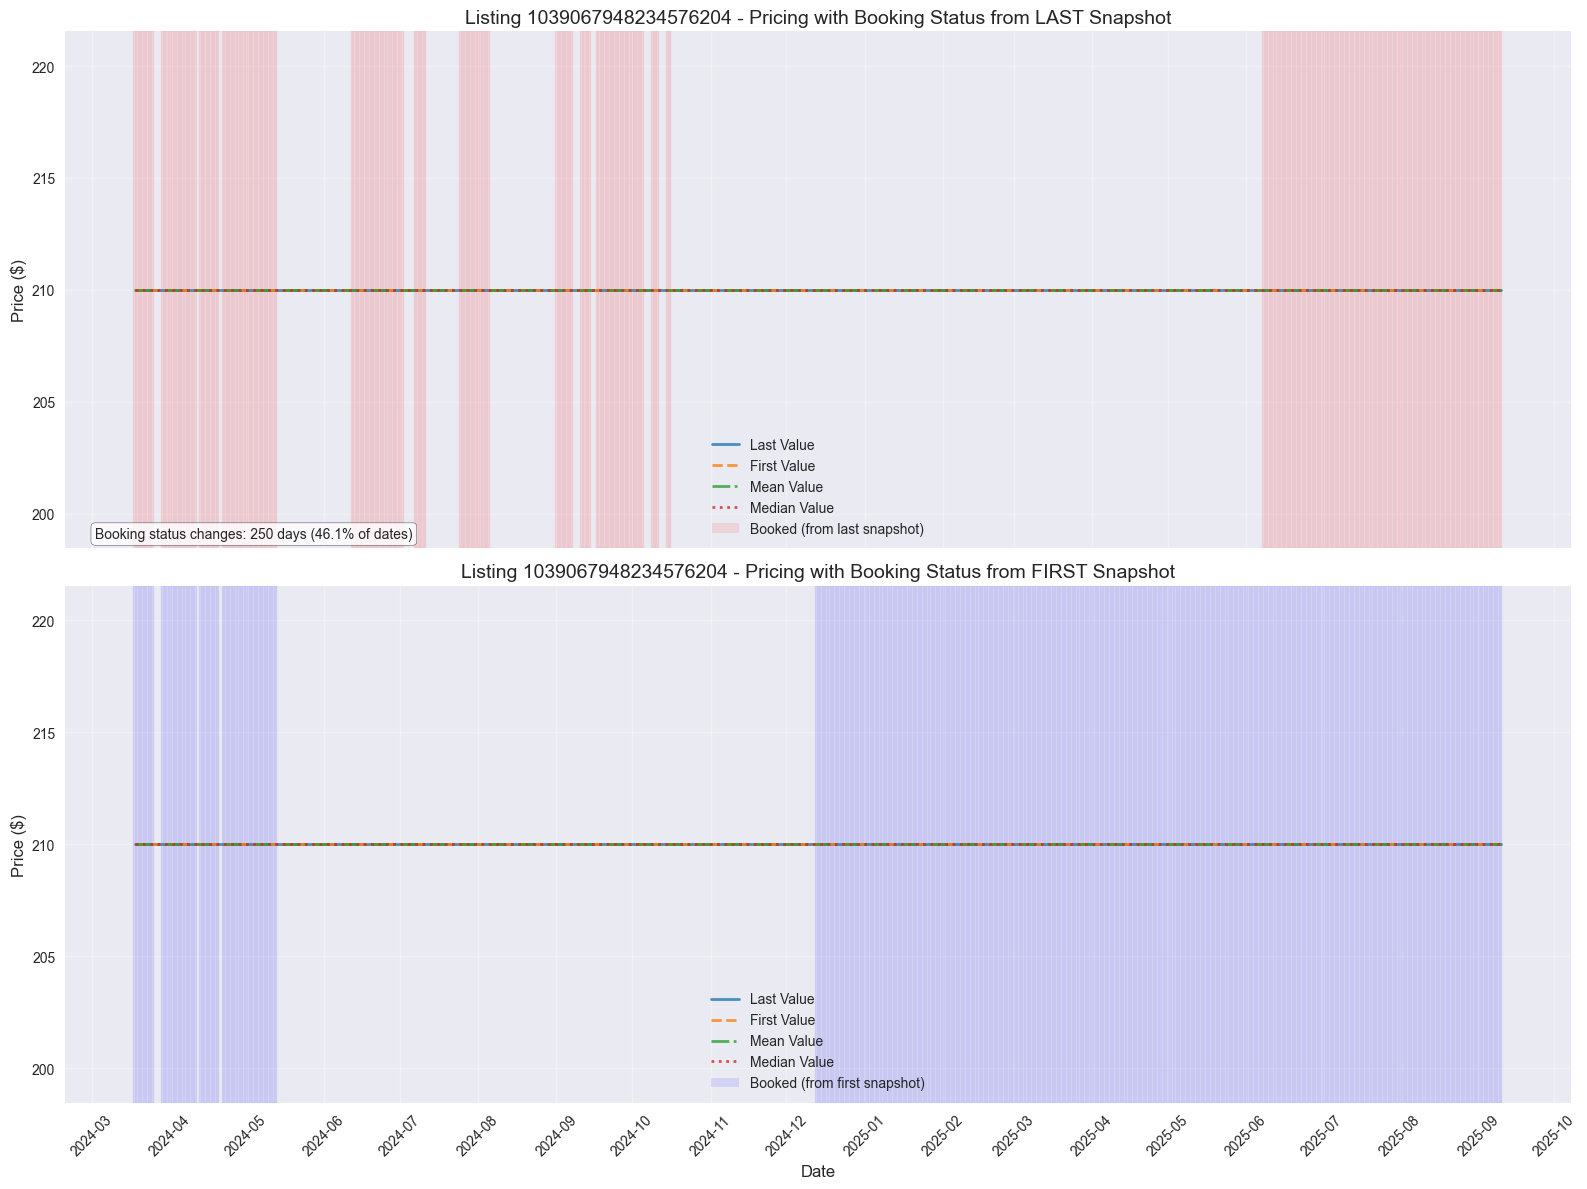

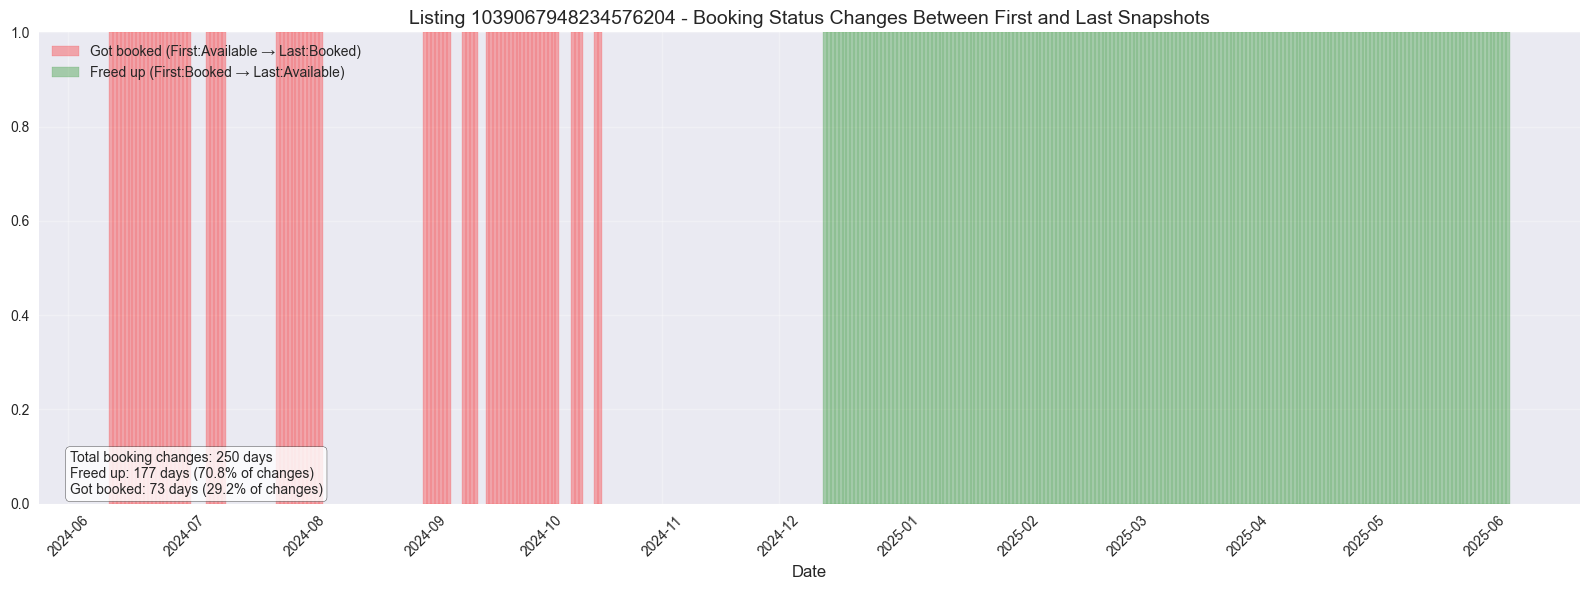

Processing listing 14/20: ID 879623872449678928


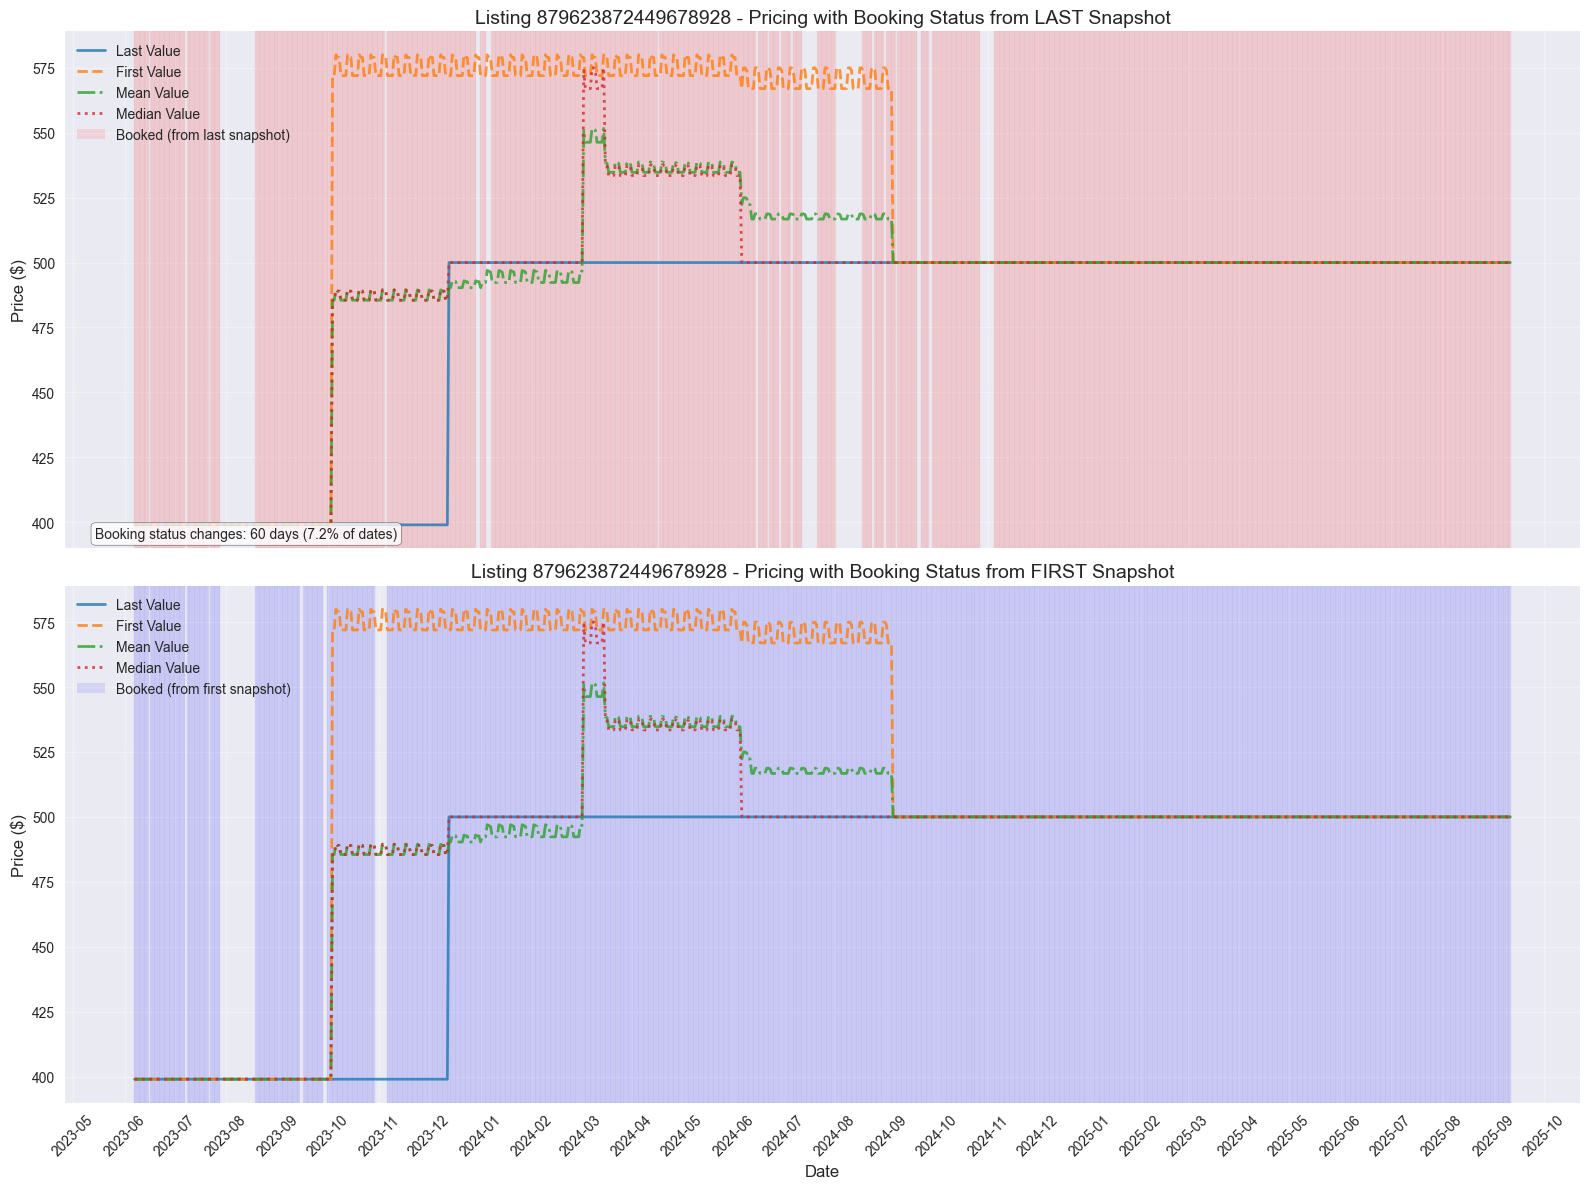

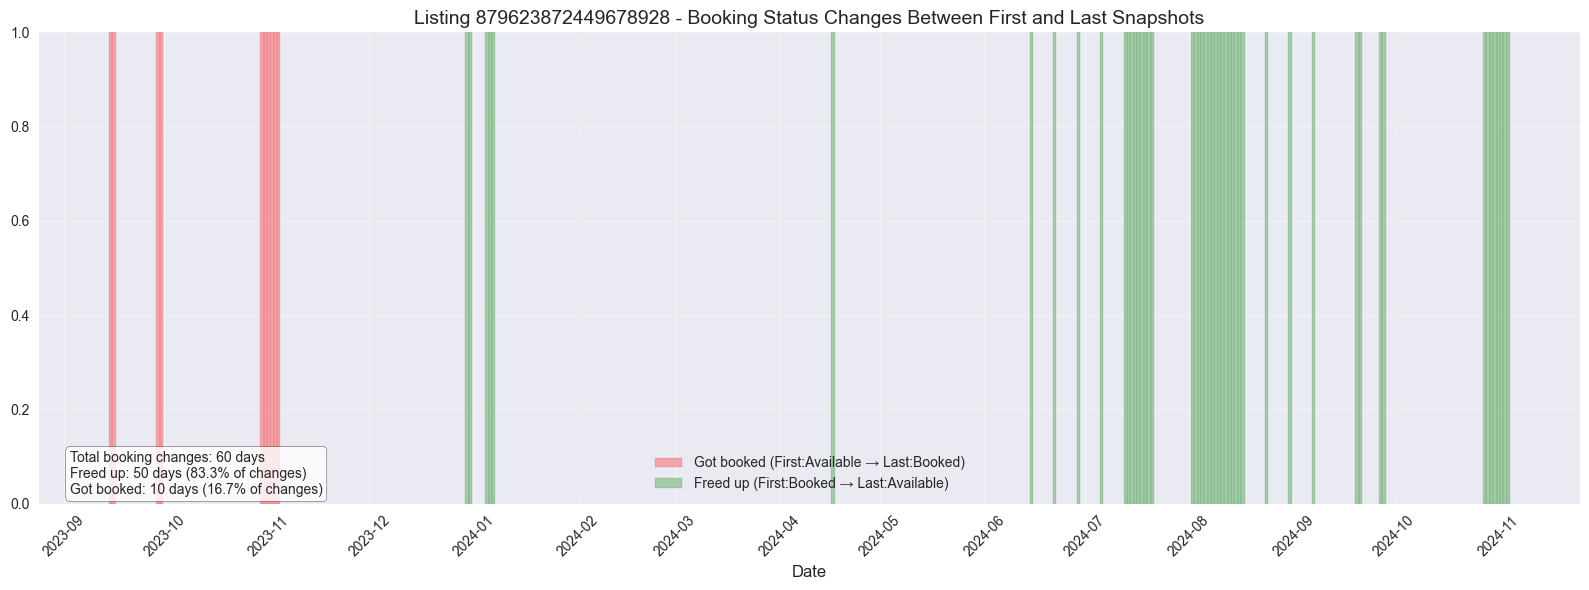

Processing listing 15/20: ID 1123309217751553233


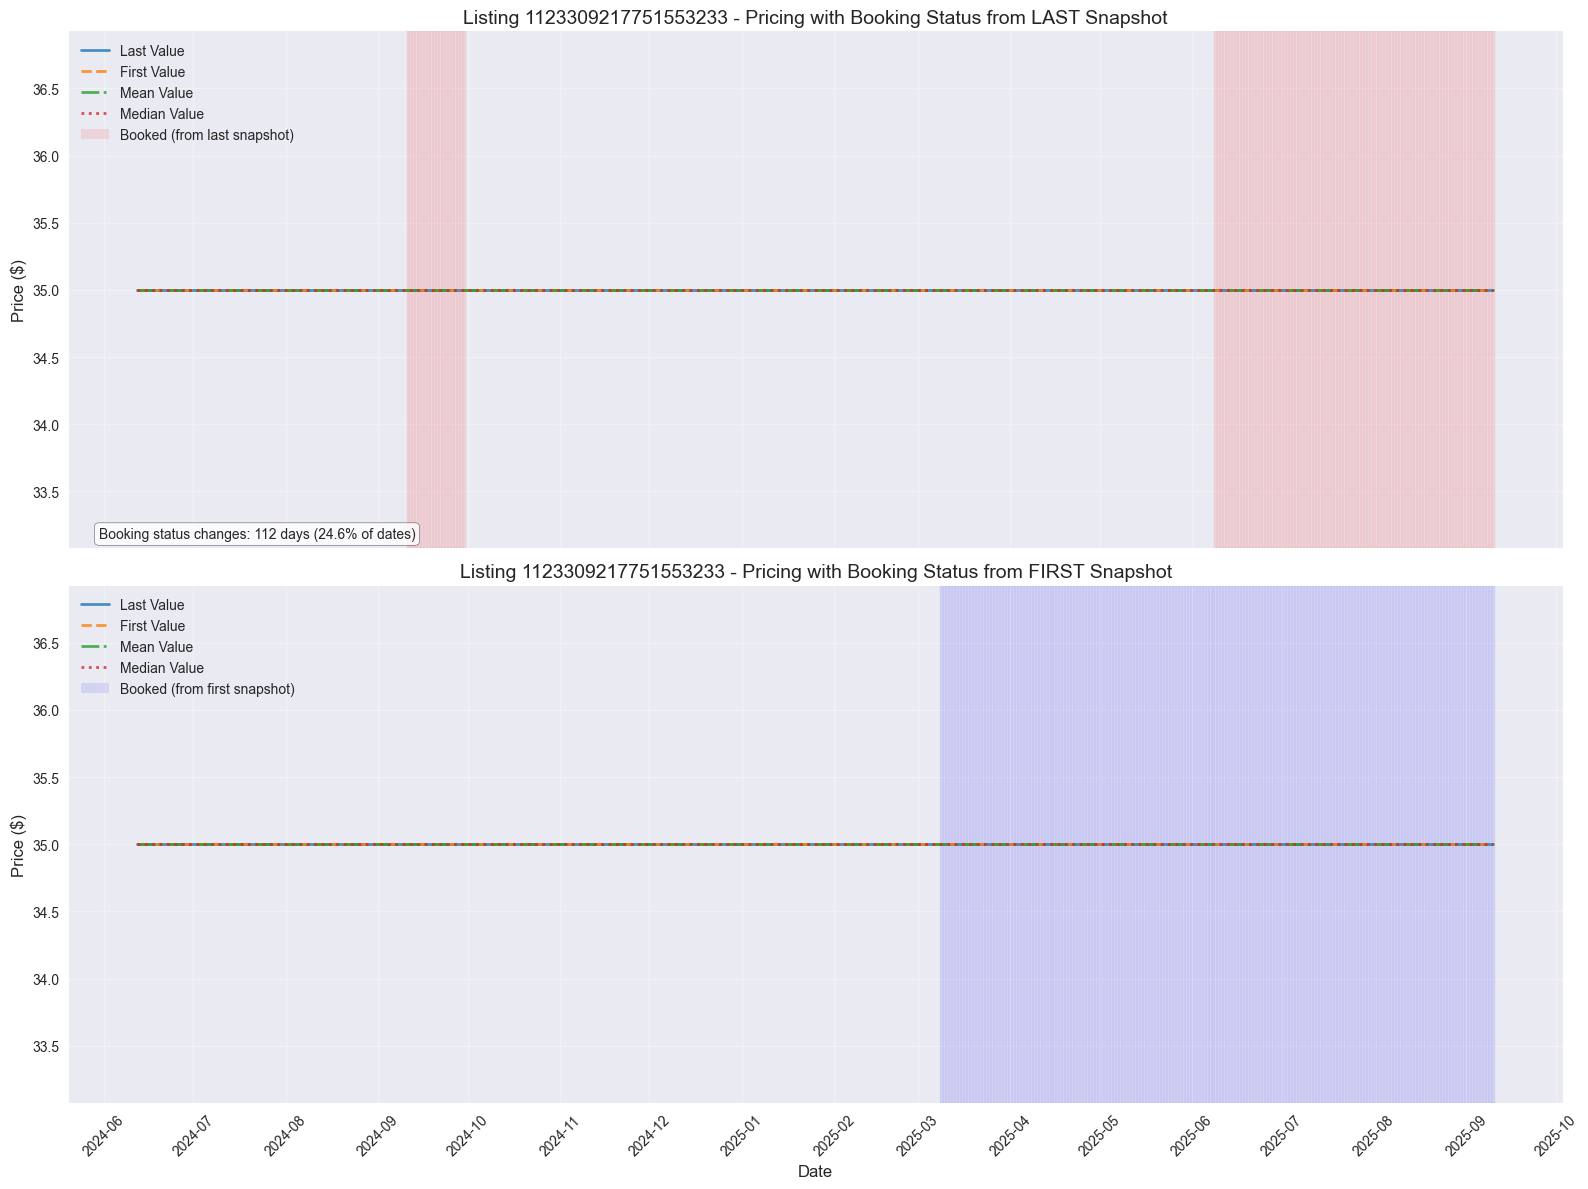

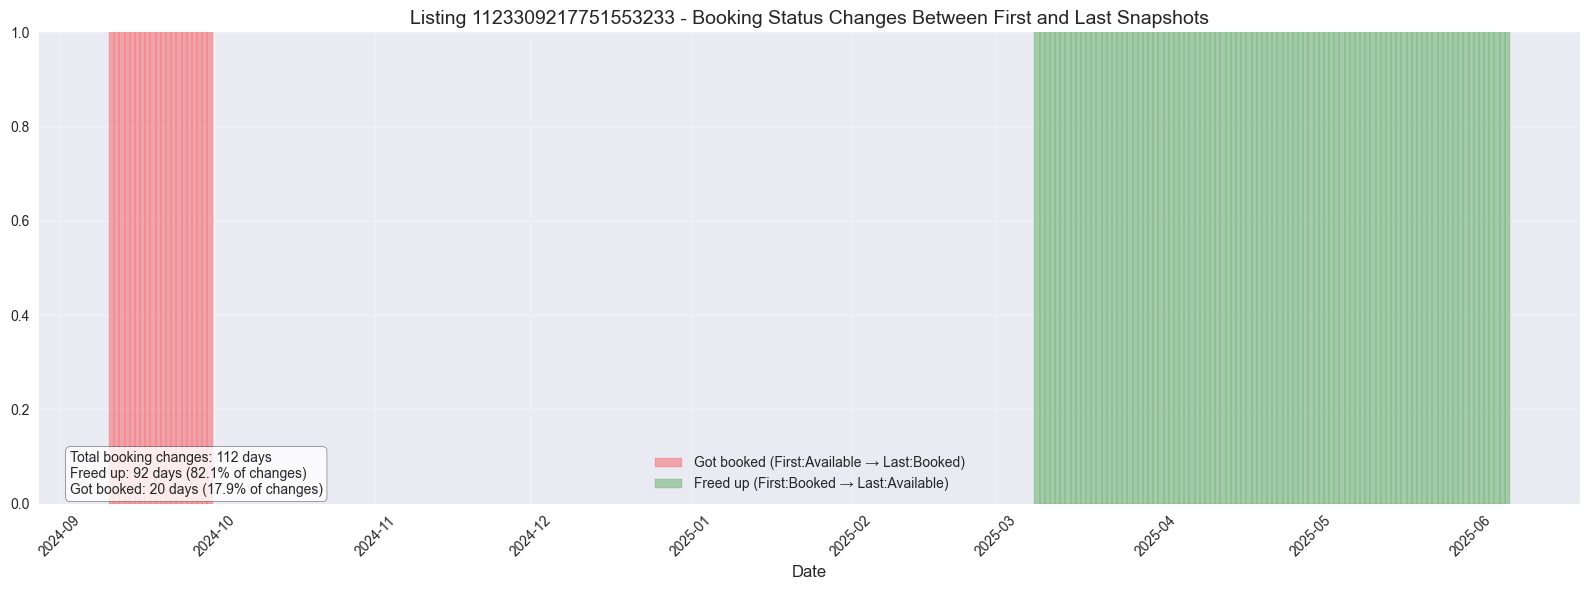

Processing listing 16/20: ID 1009118964193816022


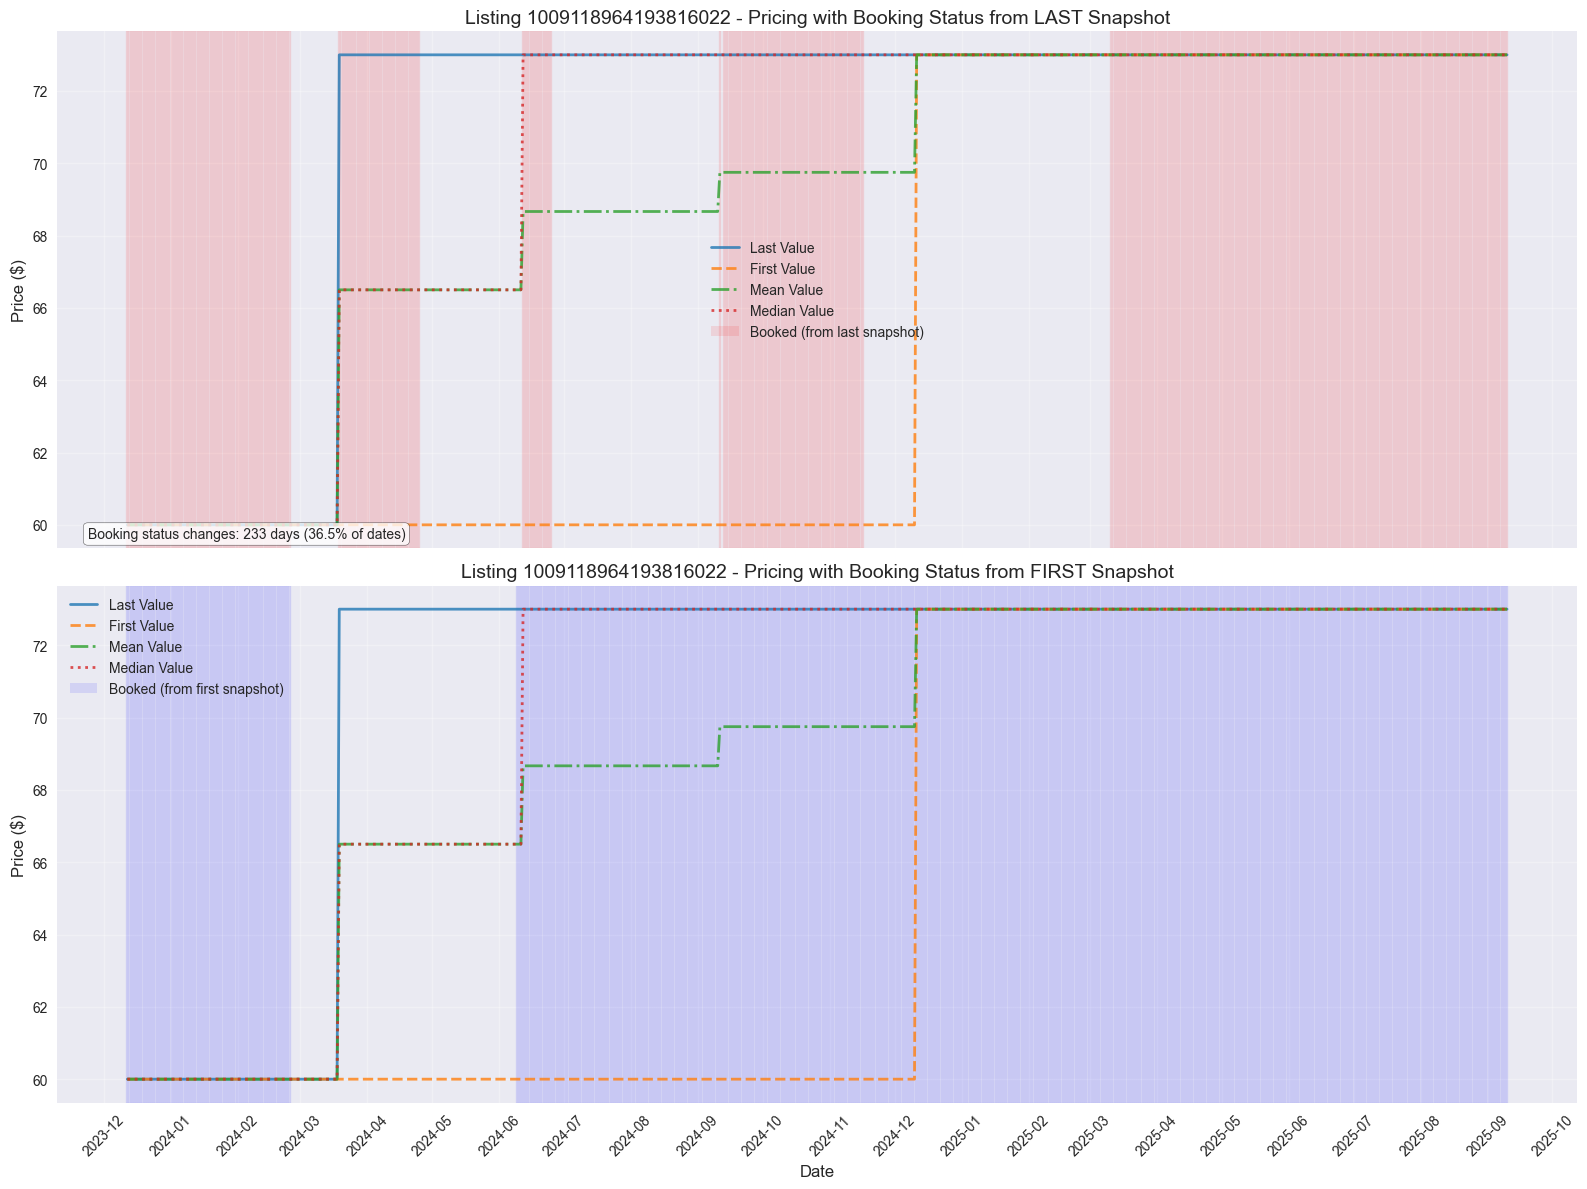

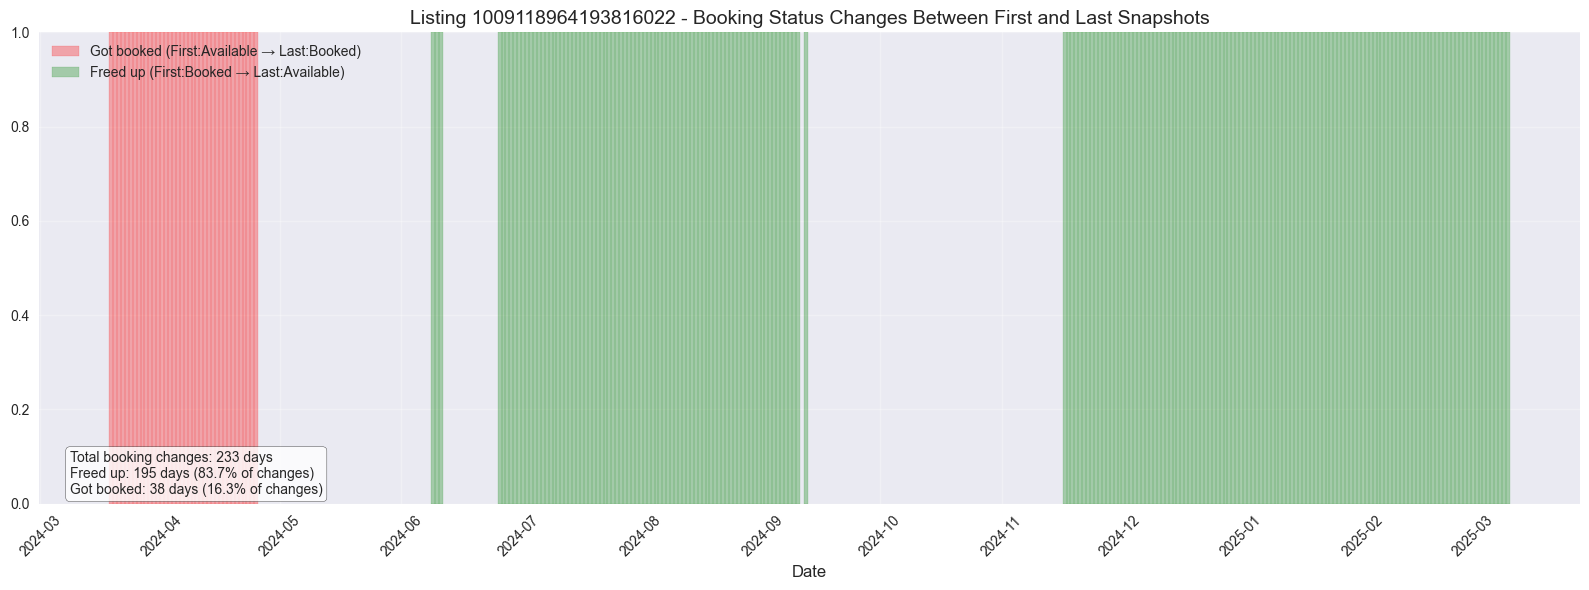

Processing listing 17/20: ID 1187510081549410845


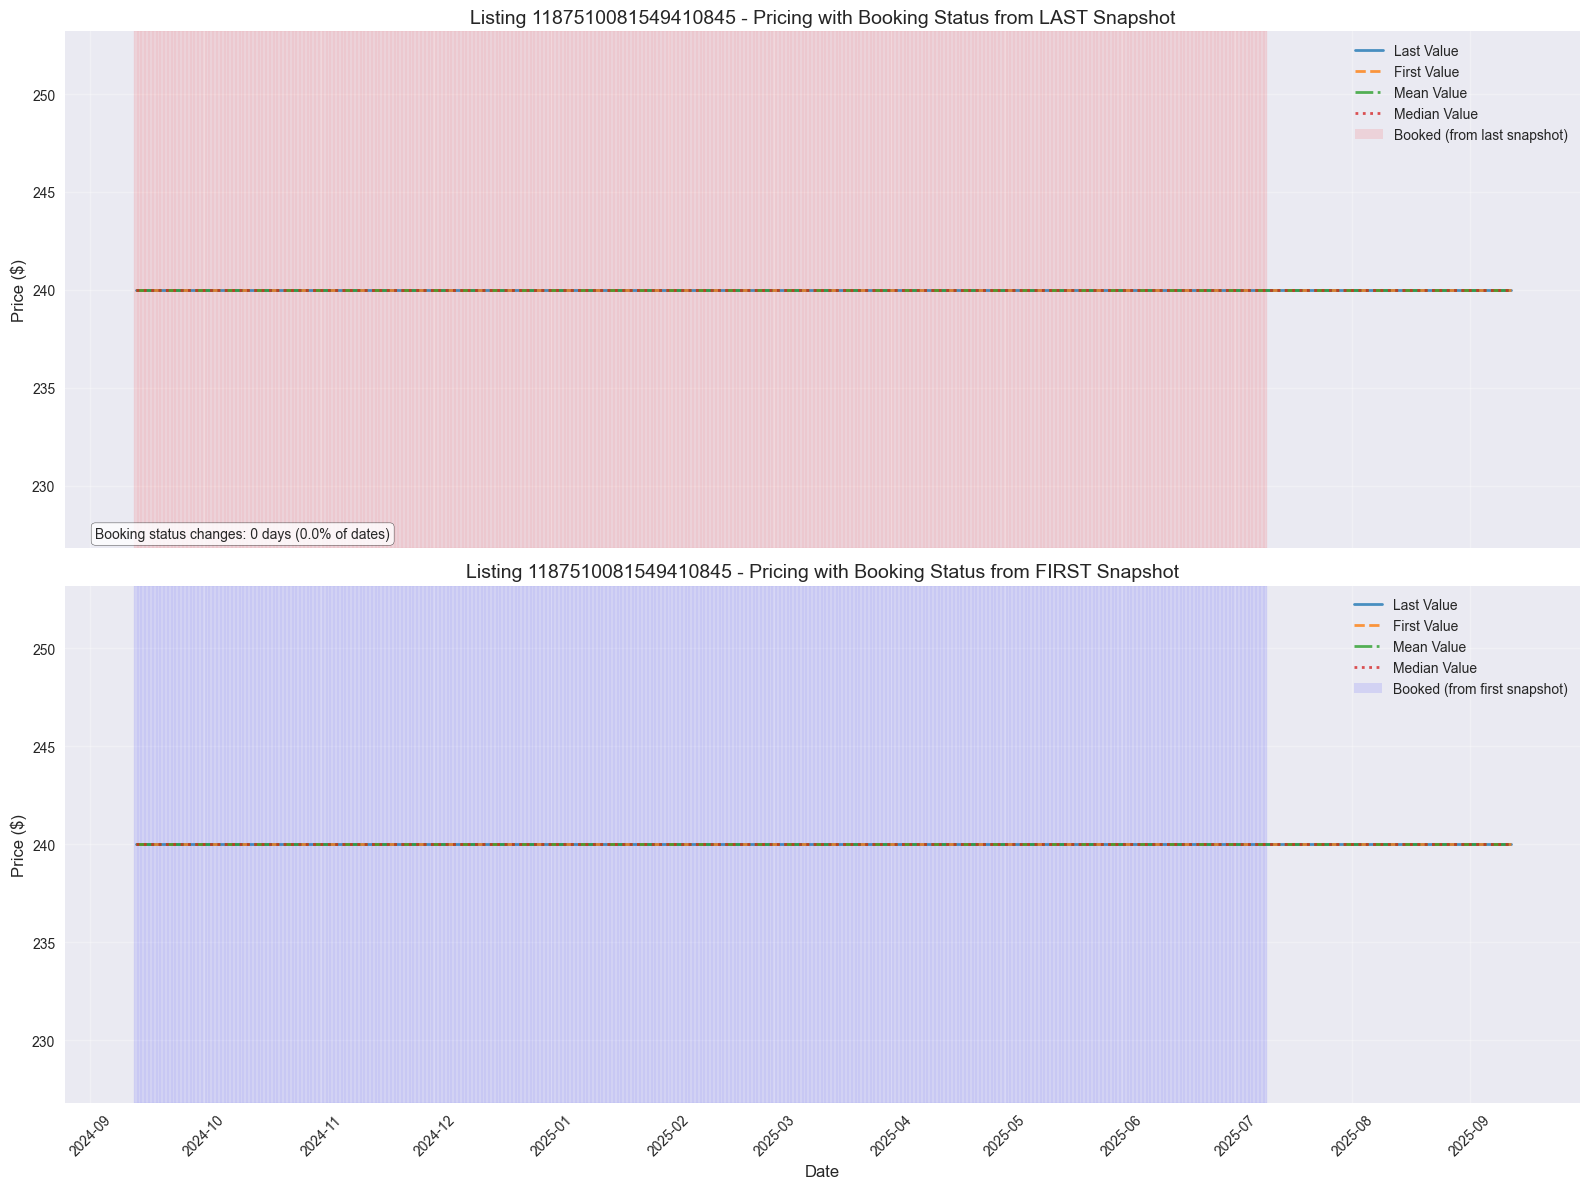

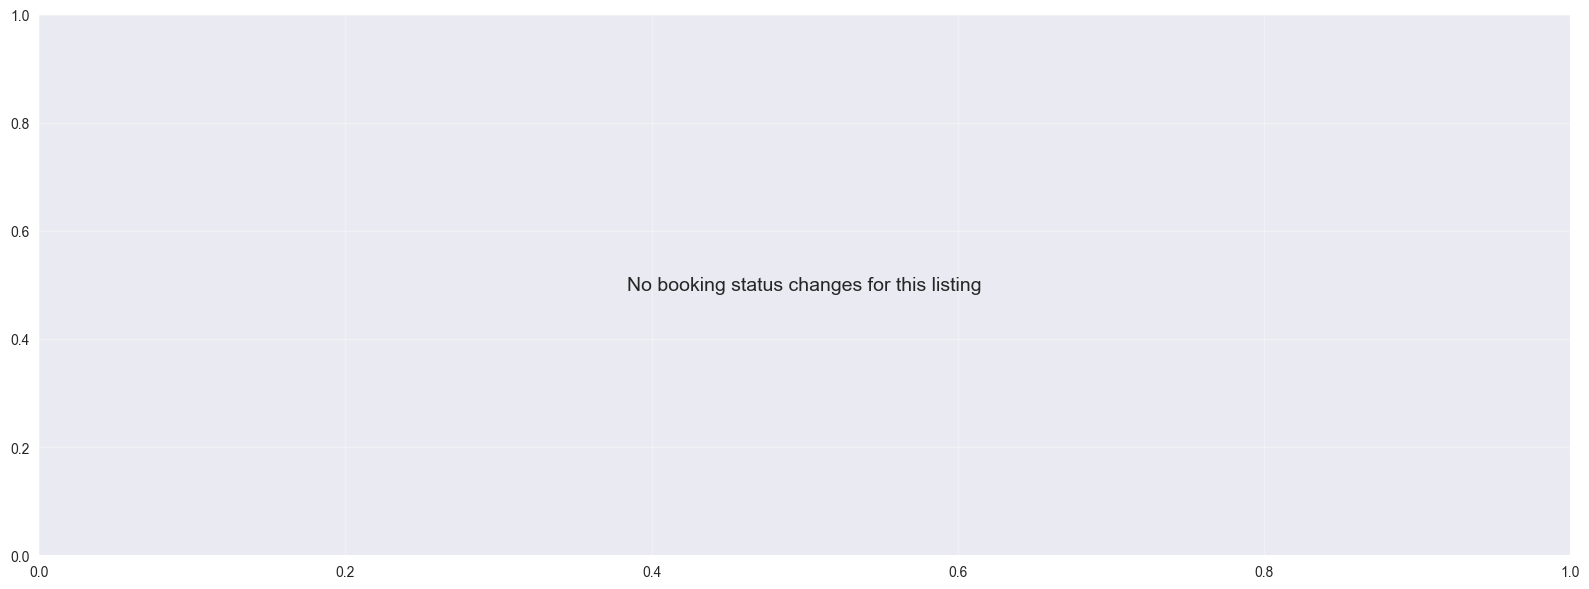

Processing listing 18/20: ID 24056143


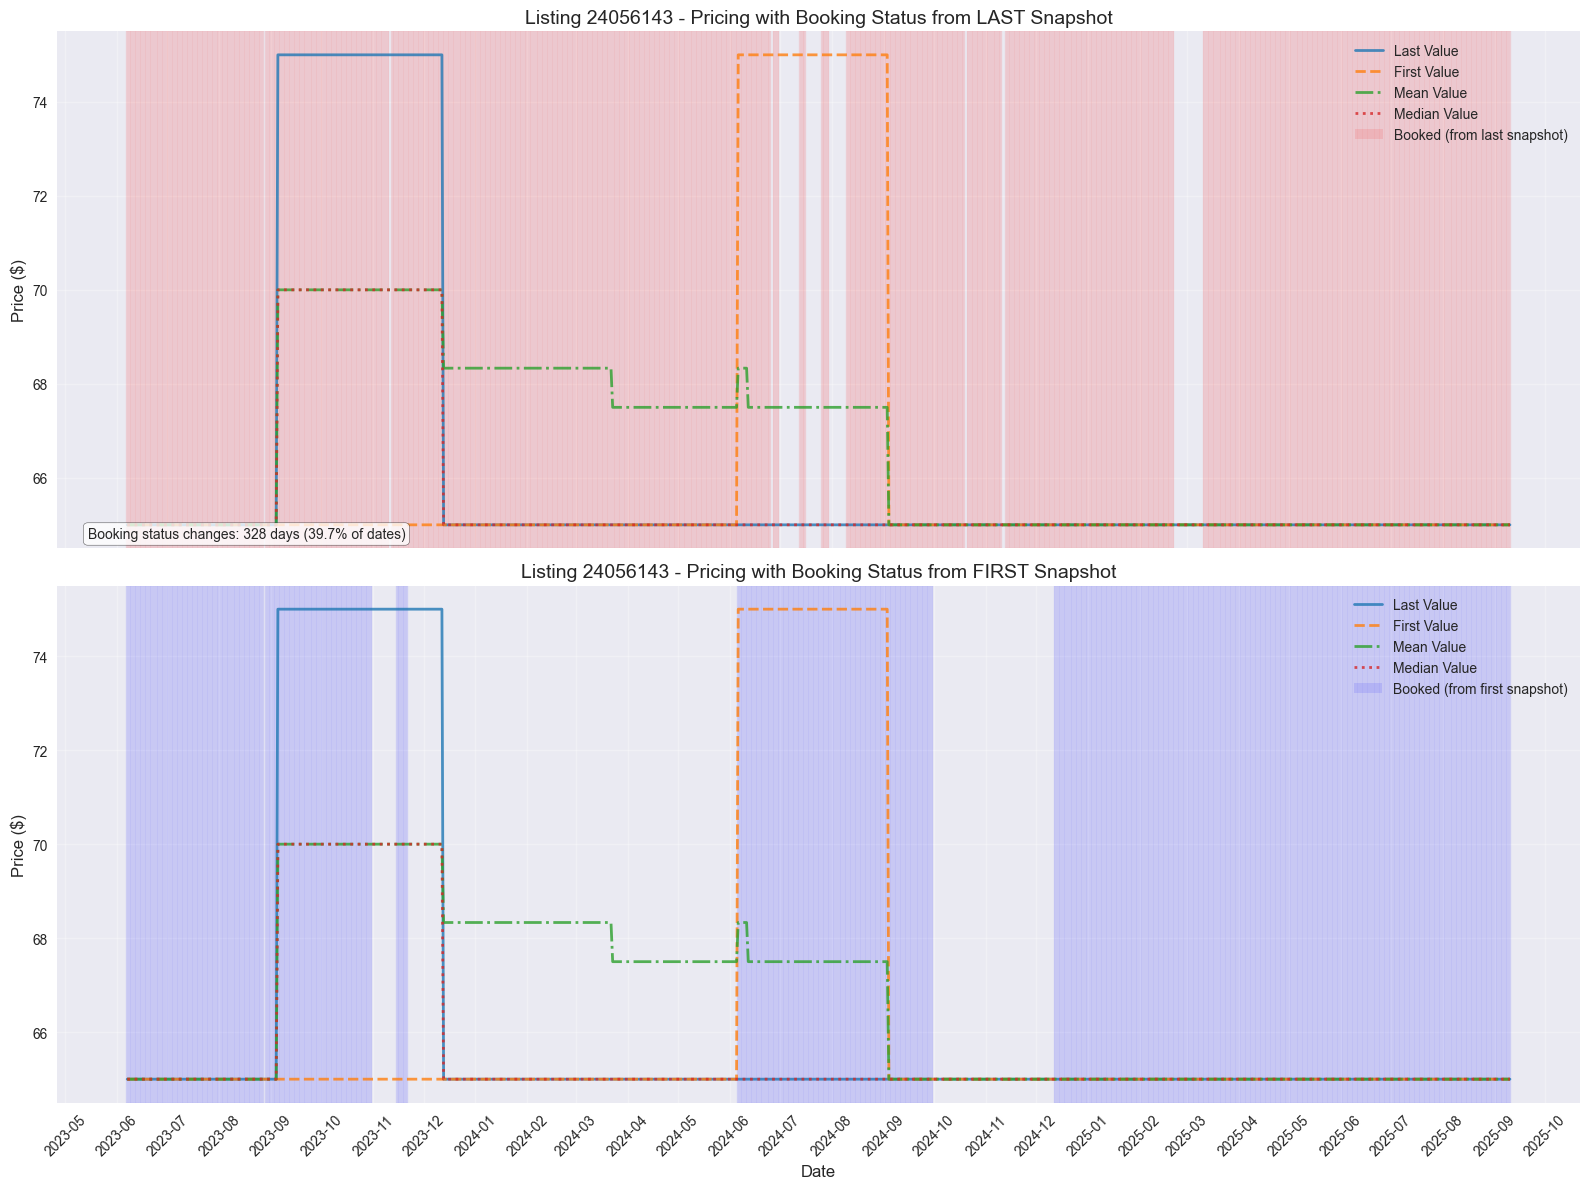

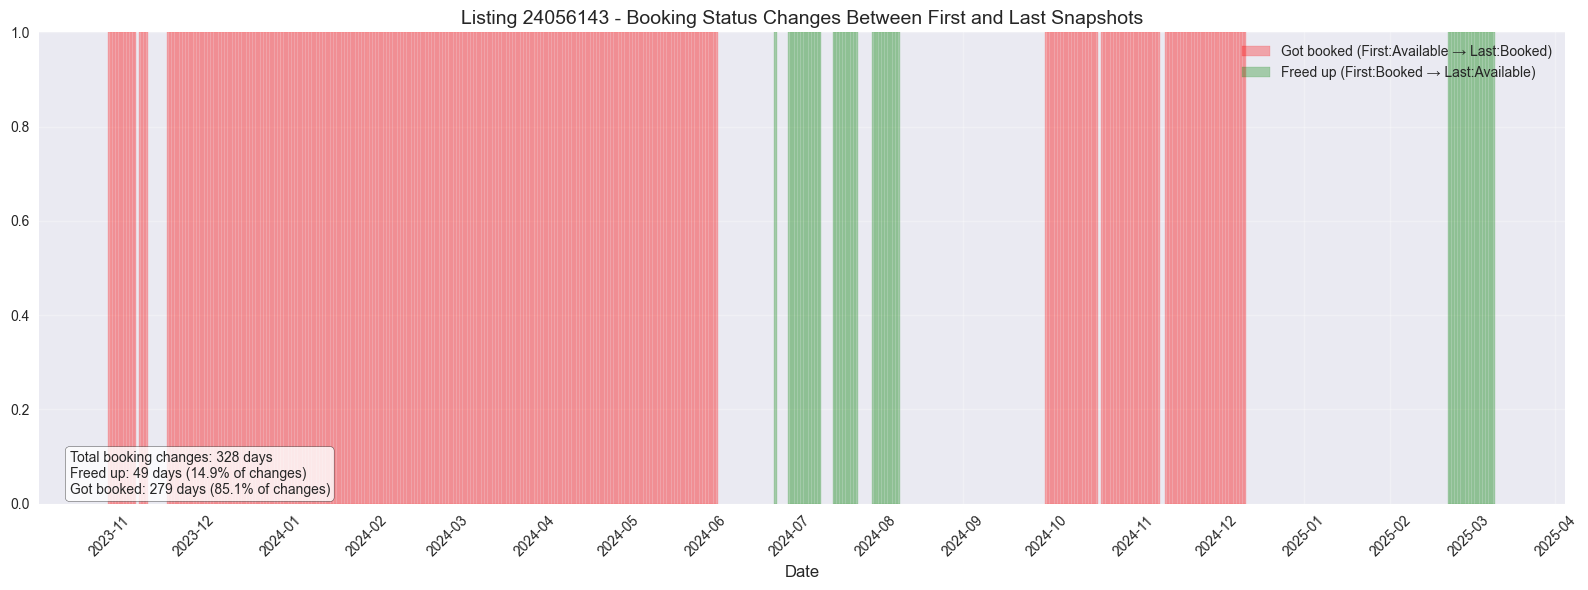

Processing listing 19/20: ID 28133054


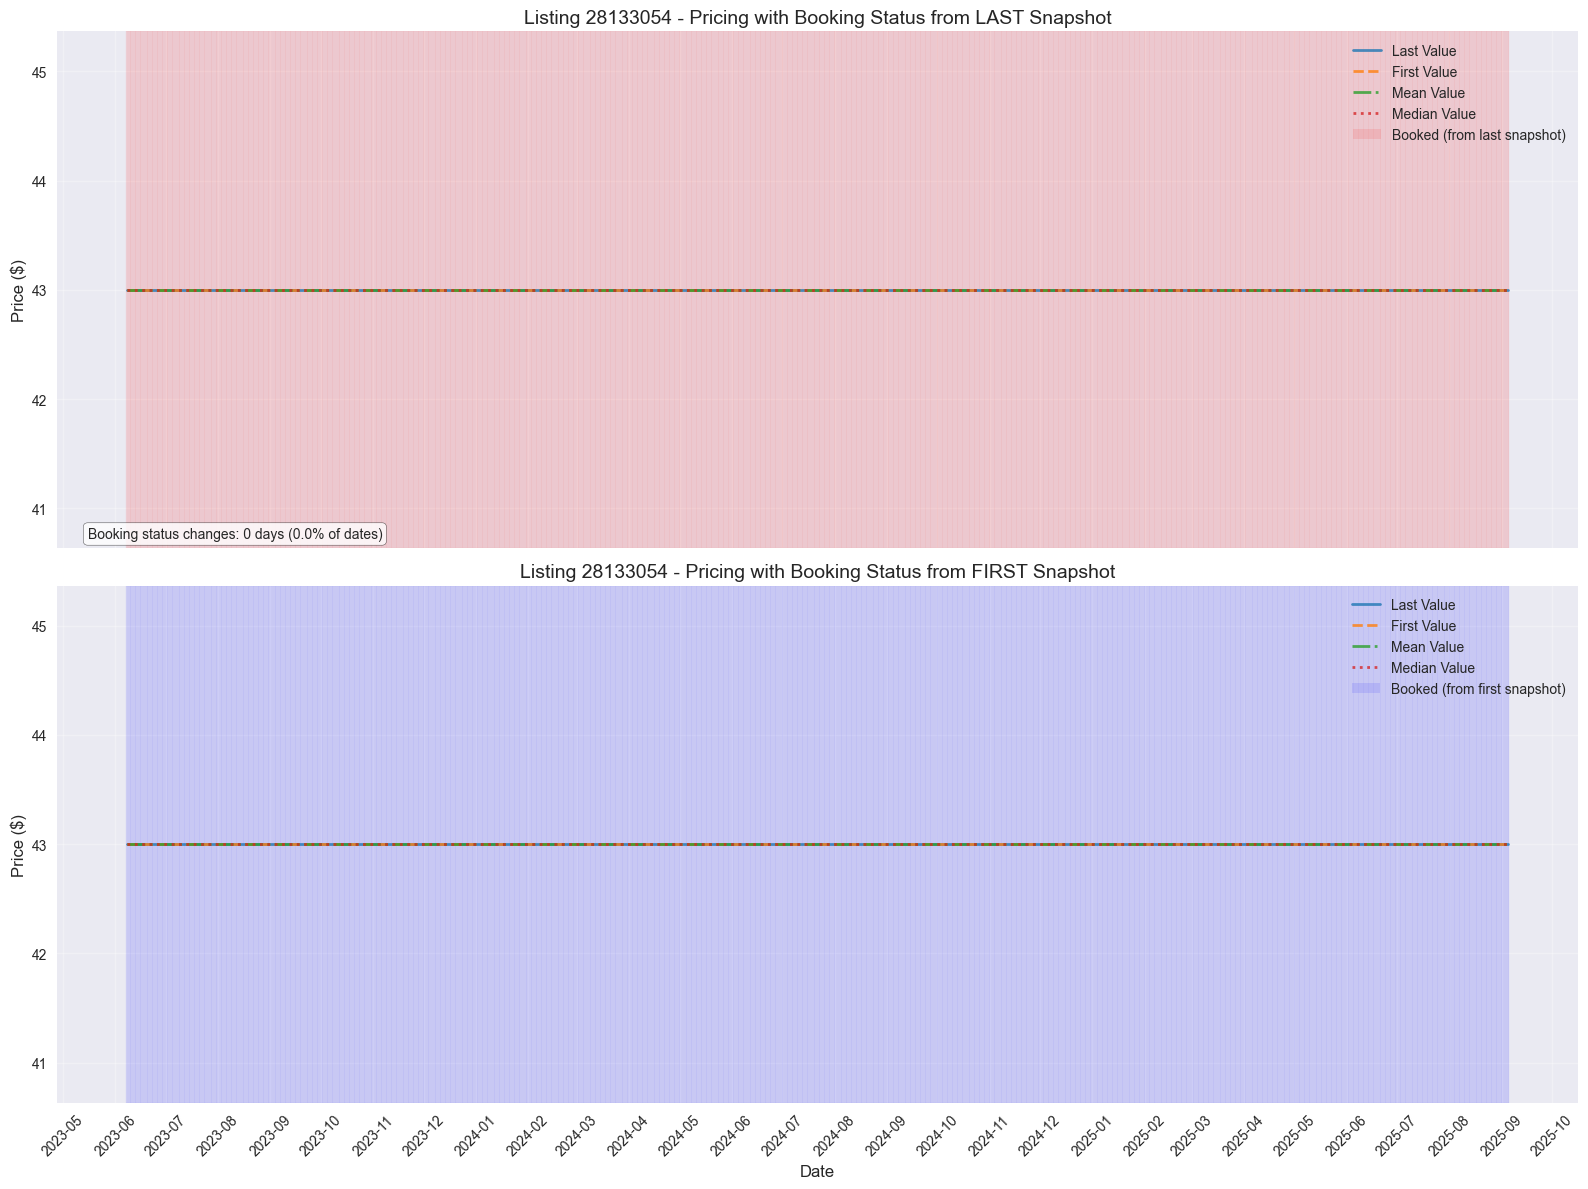

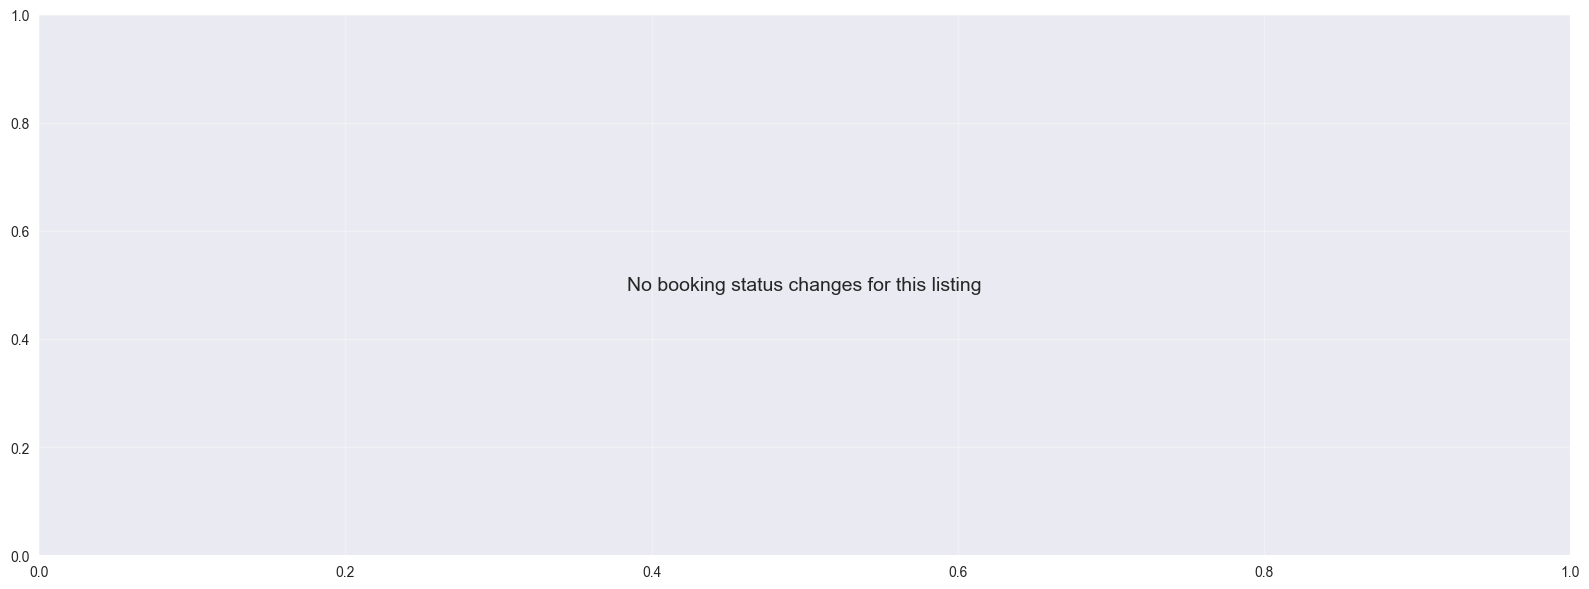

Processing listing 20/20: ID 1046953206709746429


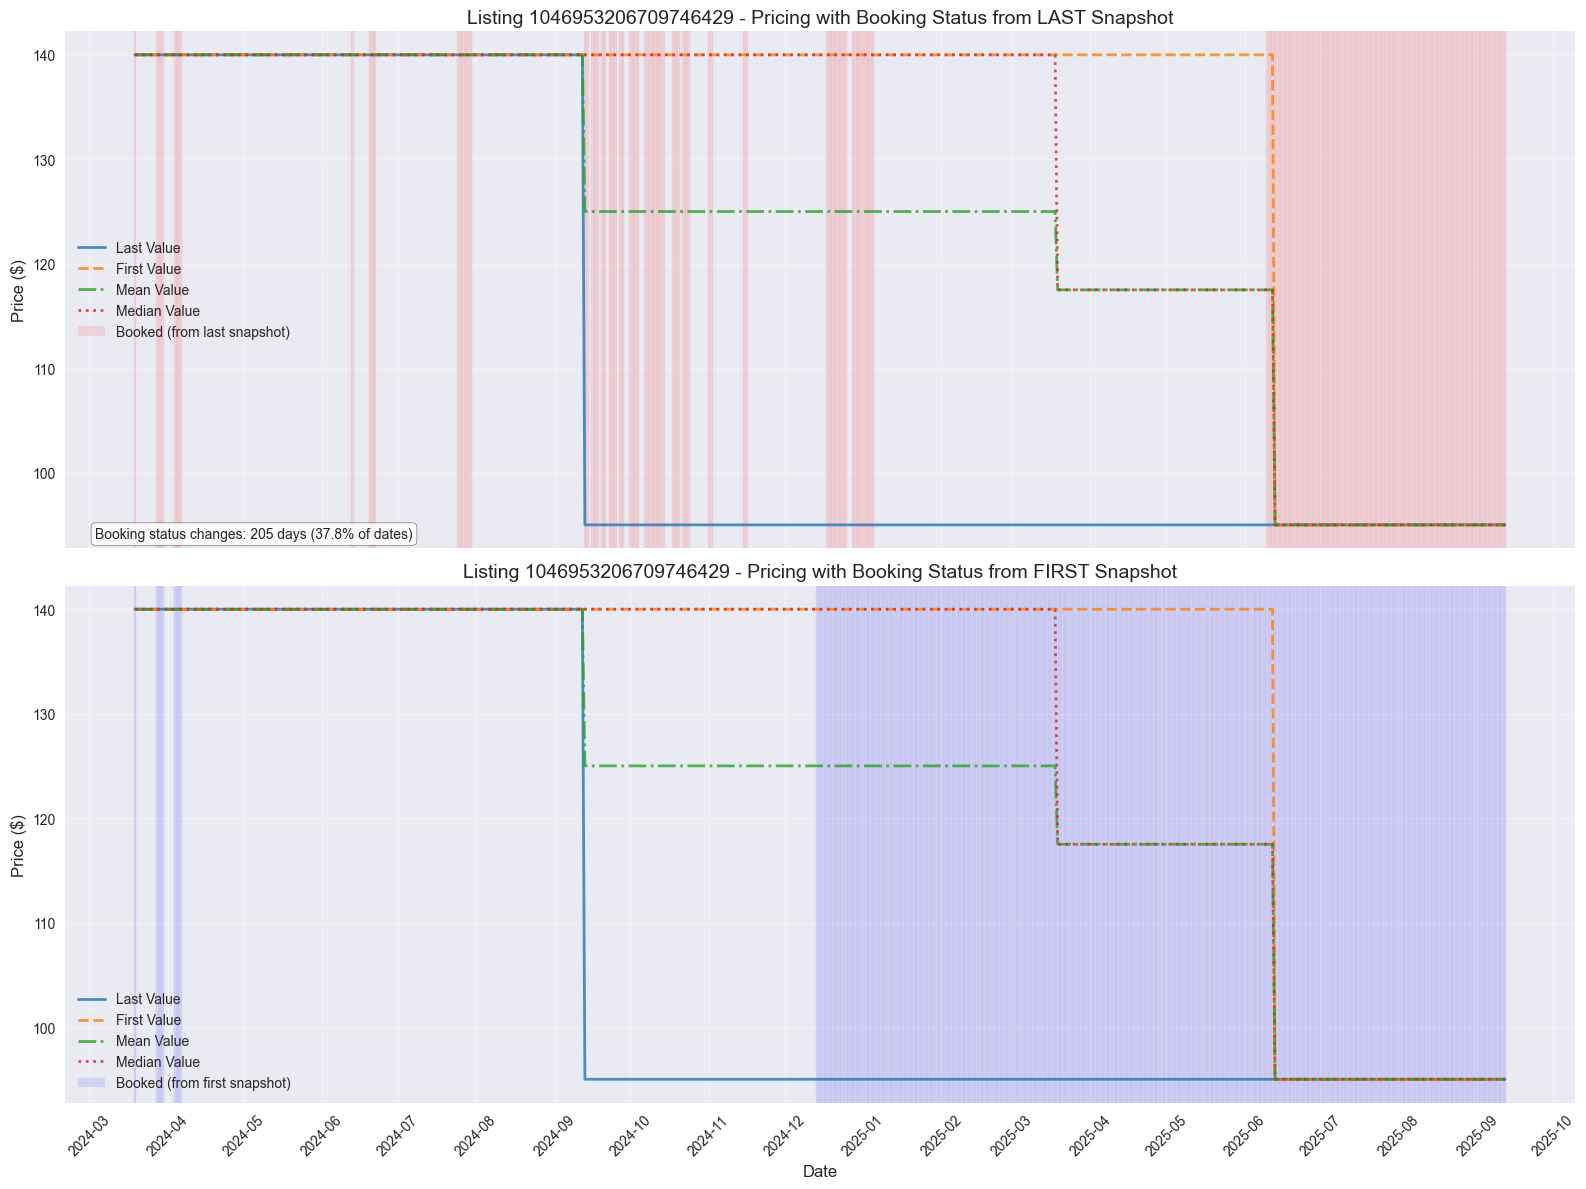

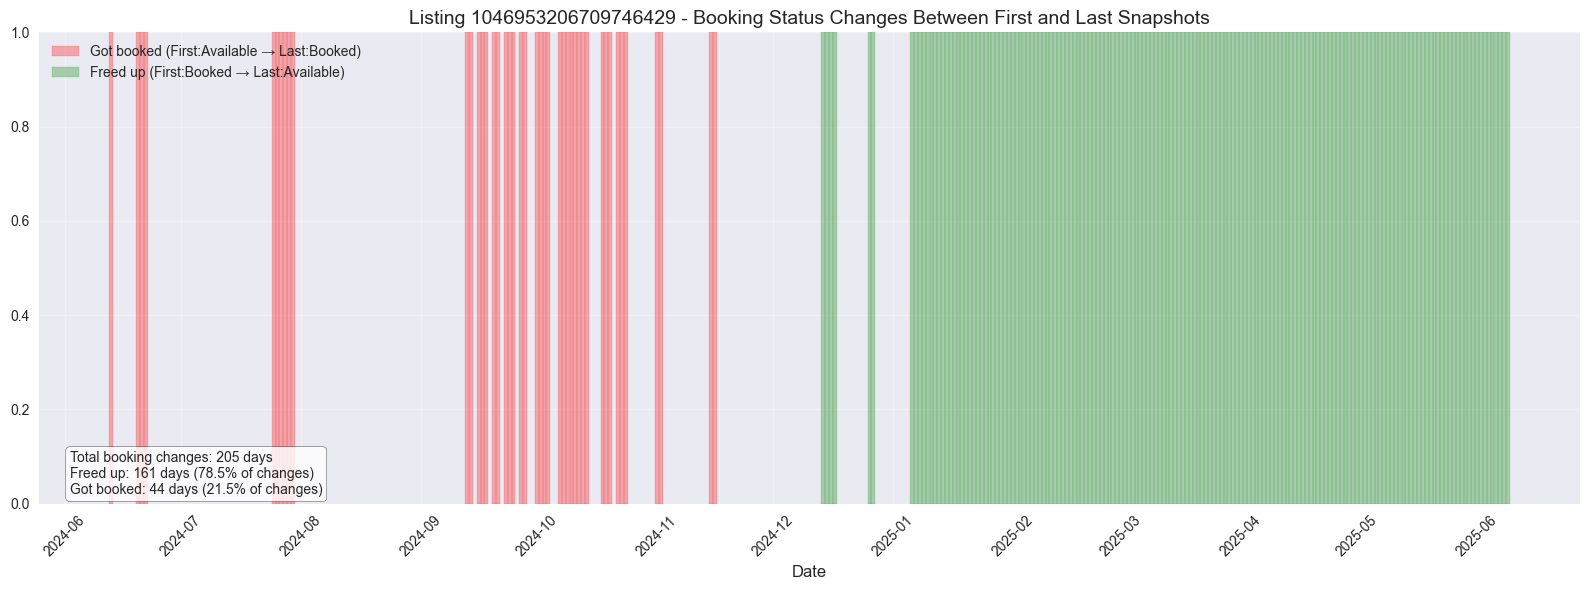


Overall Booking Status Statistics:
Total days analyzed: 13616
Days with booking status changes: 2149 (15.78%)
Freed up (first:booked → last:available): 1332 (61.98% of changes)
Got booked (first:available → last:booked): 817 (38.02% of changes)


In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

def compare_booking_sources(base_path, city, num_listings=20):
    """
    Compare time series with booking status from last snapshot vs first snapshot.
    
    Parameters:
    base_path (str): Path to the root directory
    city (str): Name of the city to process
    num_listings (int): Number of listings to sample
    """
    # Get all date folders for the specified city
    city_path = Path(base_path) / city
    date_folders = sorted([d for d in city_path.iterdir() if d.is_dir()])
    
    print(f"Processing {len(date_folders)} folders for {city}...")
    
    # First get a list of all listing IDs that appear in the most recent snapshot
    latest_folder = date_folders[-1]
    latest_calendar = pd.read_csv(latest_folder / 'calendar.csv', low_memory=False)
    
    # Sample random listing_ids
    sample_listings = latest_calendar['listing_id'].sample(num_listings, random_state=42).tolist()
    print(f"Sampled {num_listings} listings for analysis")
    
    # Initialize DataFrame to store all data for sampled listings
    all_data = pd.DataFrame()
    
    # Process each date folder
    for date_folder in date_folders:
        source_date = pd.to_datetime(date_folder.name)
        print(f"Reading data from {date_folder.name}")
        
        calendar_file = date_folder / 'calendar.csv'
        if calendar_file.exists():
            # Read necessary columns including 'available'
            df = pd.read_csv(calendar_file, low_memory=False, 
                            usecols=['listing_id', 'date', 'price', 'available'],
                            dtype={'listing_id': int, 'date': str, 'price': str, 'available': str})
            
            # Filter for sampled listings
            sample_data = df[df['listing_id'].isin(sample_listings)].copy()
            
            if not sample_data.empty:
                # Convert date column to datetime
                sample_data['date'] = pd.to_datetime(sample_data['date'])
                
                # Clean price column
                sample_data['price'] = sample_data['price'].str.replace('$', '').str.replace(',', '').astype(float)
                
                # Add source date
                sample_data['source_date'] = source_date
                
                # Convert availability to boolean
                sample_data['is_available'] = sample_data['available'].map({'t': True, 'f': False})
                
                # Append to all_data
                all_data = pd.concat([all_data, sample_data])
    
    # Create output directory
    output_dir = Path("booking_source_comparison")
    output_dir.mkdir(exist_ok=True)
    
    # Set plot style
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")
    
    # Analyze each listing
    for i, listing_id in enumerate(sample_listings, 1):
        print(f"Processing listing {i}/{num_listings}: ID {listing_id}")
        
        # Filter for this listing
        listing_df = all_data[all_data['listing_id'] == listing_id].copy()
        
        if listing_df.empty:
            print(f"No data found for listing {listing_id}")
            continue
        
        # Prepare different merging strategies
        # 1. Last value approach (most recent snapshot)
        last_values = listing_df.sort_values(['date', 'source_date']).drop_duplicates(subset=['date'], keep='last')
        
        # 2. First value approach (earliest snapshot)
        first_values = listing_df.sort_values(['date', 'source_date']).drop_duplicates(subset=['date'], keep='first')
        
        # 3. Mean price approach
        mean_values = listing_df.groupby('date')['price'].mean().reset_index()
        
        # 4. Median price approach
        median_values = listing_df.groupby('date')['price'].median().reset_index()
        
        # Get booking status from latest and earliest snapshots
        last_booking = last_values[['date', 'is_available']]
        first_booking = first_values[['date', 'is_available']]
        
        # Create two graphs - one with each booking source
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
        
        # ------- First Graph: Last Snapshot Booking Status -------
        
        # Plot availability background from the LAST snapshot
        unavailable_dates_last = last_booking[~last_booking['is_available']]['date']
        
        for date in unavailable_dates_last:
            ax1.axvspan(date - pd.Timedelta(hours=12), date + pd.Timedelta(hours=12), 
                      alpha=0.1, color='red', label='_nolegend_')
        
        # Plot all pricing strategies
        strategies = {
            'Last Value': last_values[['date', 'price']],
            'First Value': first_values[['date', 'price']],
            'Mean Value': mean_values,
            'Median Value': median_values
        }
        
        lines = ['-', '--', '-.', ':']
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        
        for (strategy_name, strategy_df), line, color in zip(strategies.items(), lines, colors):
            ax1.plot(strategy_df['date'], strategy_df['price'], 
                    linestyle=line, label=strategy_name, color=color, 
                    alpha=0.8, linewidth=2)
        
        ax1.set_title(f'Listing {listing_id} - Pricing with Booking Status from LAST Snapshot', fontsize=14)
        ax1.set_ylabel('Price ($)', fontsize=12)
        
        # Custom legend with booking info
        from matplotlib.patches import Patch
        handles, labels = ax1.get_legend_handles_labels()
        handles.append(Patch(facecolor='red', alpha=0.1, label='Booked (from last snapshot)'))
        ax1.legend(handles=handles, fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # Calculate and display booking changes
        booking_comparison = pd.merge(last_booking, first_booking, 
                                     on='date', suffixes=('_last', '_first'))
        booking_changes = (booking_comparison['is_available_last'] != booking_comparison['is_available_first']).sum()
        total_dates = len(booking_comparison)
        change_percent = booking_changes / total_dates * 100 if total_dates > 0 else 0
        
        ax1.annotate(f"Booking status changes: {booking_changes} days ({change_percent:.1f}% of dates)", 
                    xy=(0.02, 0.02), xycoords='axes fraction', 
                    fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
        
        # ------- Second Graph: First Snapshot Booking Status -------
        
        # Plot availability background from the FIRST snapshot
        unavailable_dates_first = first_booking[~first_booking['is_available']]['date']
        
        for date in unavailable_dates_first:
            ax2.axvspan(date - pd.Timedelta(hours=12), date + pd.Timedelta(hours=12), 
                      alpha=0.1, color='blue', label='_nolegend_')
        
        # Plot all pricing strategies again on the second graph
        for (strategy_name, strategy_df), line, color in zip(strategies.items(), lines, colors):
            ax2.plot(strategy_df['date'], strategy_df['price'], 
                    linestyle=line, label=strategy_name, color=color, 
                    alpha=0.8, linewidth=2)
        
        ax2.set_title(f'Listing {listing_id} - Pricing with Booking Status from FIRST Snapshot', fontsize=14)
        ax2.set_xlabel('Date', fontsize=12)
        ax2.set_ylabel('Price ($)', fontsize=12)
        
        # Custom legend with booking info for second graph
        handles, labels = ax2.get_legend_handles_labels()
        handles.append(Patch(facecolor='blue', alpha=0.1, label='Booked (from first snapshot)'))
        ax2.legend(handles=handles, fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        # Format x-axis with month intervals
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax2.xaxis.set_major_locator(mdates.MonthLocator())
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.savefig(output_dir / f"listing_{listing_id}_booking_source_comparison.png", dpi=300)
        plt.show()
        plt.close()
        
        # Create a third graph showing only booking status changes
        plt.figure(figsize=(16, 6))
        
        # Plot dates where booking status changed
        booking_comparison['status_changed'] = booking_comparison['is_available_last'] != booking_comparison['is_available_first']
        changed_dates = booking_comparison[booking_comparison['status_changed']]['date']
        
        if not changed_dates.empty:
            # Color code by direction of change
            for _, row in booking_comparison[booking_comparison['status_changed']].iterrows():
                if row['is_available_last'] and not row['is_available_first']:
                    # Changed from booked (first) to available (last)
                    color = 'green'
                    label = 'Freed up (First:Booked → Last:Available)'
                else:
                    # Changed from available (first) to booked (last)
                    color = 'red'
                    label = 'Got booked (First:Available → Last:Booked)'
                
                plt.axvspan(row['date'] - pd.Timedelta(hours=12), row['date'] + pd.Timedelta(hours=12), 
                           alpha=0.3, color=color, label=label)
            
            # Remove duplicate labels
            handles, labels = plt.gca().get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            plt.legend(by_label.values(), by_label.keys(), fontsize=10)
            
            plt.title(f'Listing {listing_id} - Booking Status Changes Between First and Last Snapshots', fontsize=14)
            plt.xlabel('Date', fontsize=12)
            plt.ylabel('', fontsize=12)
            
            # Format x-axis with month intervals
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
            plt.xticks(rotation=45)
            
            # Add annotation with summary statistics
            freed_up = sum((booking_comparison['is_available_last'] == True) & 
                         (booking_comparison['is_available_first'] == False))
            got_booked = sum((booking_comparison['is_available_last'] == False) & 
                           (booking_comparison['is_available_first'] == True))
            
            plt.annotate(
                f"Total booking changes: {booking_changes} days\n" +
                f"Freed up: {freed_up} days ({freed_up/booking_changes*100:.1f}% of changes)\n" +
                f"Got booked: {got_booked} days ({got_booked/booking_changes*100:.1f}% of changes)",
                xy=(0.02, 0.02), xycoords='axes fraction', 
                fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
        else:
            plt.text(0.5, 0.5, 'No booking status changes for this listing', 
                    horizontalalignment='center', verticalalignment='center',
                    transform=plt.gca().transAxes, fontsize=14)
        
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(output_dir / f"listing_{listing_id}_booking_changes.png", dpi=300)
        plt.show()
        plt.close()
    
    # Calculate overall statistics on booking status changes
    total_changes = 0
    total_dates = 0
    freed_up_total = 0
    got_booked_total = 0
    
    for listing_id in sample_listings:
        listing_df = all_data[all_data['listing_id'] == listing_id]
        
        if not listing_df.empty:
            # Get booking status from latest and earliest snapshots
            last_booking = listing_df.sort_values(['date', 'source_date']).drop_duplicates(subset=['date'], keep='last')[['date', 'is_available']]
            first_booking = listing_df.sort_values(['date', 'source_date']).drop_duplicates(subset=['date'], keep='first')[['date', 'is_available']]
            
            # Compare booking statuses
            booking_comparison = pd.merge(last_booking, first_booking, 
                                         on='date', suffixes=('_last', '_first'))
            changes = (booking_comparison['is_available_last'] != booking_comparison['is_available_first']).sum()
            total_changes += changes
            total_dates += len(booking_comparison)
            
            # Count by direction of change
            freed_up_total += sum((booking_comparison['is_available_last'] == True) & 
                               (booking_comparison['is_available_first'] == False))
            got_booked_total += sum((booking_comparison['is_available_last'] == False) & 
                                 (booking_comparison['is_available_first'] == True))
    
    change_percent = total_changes / total_dates * 100 if total_dates > 0 else 0
    
    print("\nOverall Booking Status Statistics:")
    print(f"Total days analyzed: {total_dates}")
    print(f"Days with booking status changes: {total_changes} ({change_percent:.2f}%)")
    
    if total_changes > 0:
        print(f"Freed up (first:booked → last:available): {freed_up_total} ({freed_up_total/total_changes*100:.2f}% of changes)")
        print(f"Got booked (first:available → last:booked): {got_booked_total} ({got_booked_total/total_changes*100:.2f}% of changes)")
    
    return all_data, sample_listings

# Example usage:
base_folder = 'C:/Users/mvk/Documents/DATA_school/thesis/data_new'
city = "paris"
all_data, sample_listings = compare_booking_sources(base_folder, city)